# 1. 라이브러리 호출

In [92]:
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException
import time
import re
import csv 
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from matplotlib import font_manager
import seaborn as sns

from bs4 import BeautifulSoup
from tqdm import tqdm

# 2. 전처리한 리뷰들 불러오기

## 2-(1) 블로그 리뷰 불러오기

In [93]:
#전처리한 블로그 리뷰 csv파일 불러오기
processed_blog_review_list=pd.read_csv('processed_place_blog_review.csv',encoding='utf-8')
processed_blog_review1=processed_blog_review_list[['num', 'name','blog or review','blog name','like_count_list','command_count_list','date_list','img_count','neighber_count','last_content_date','blog review']]

In [94]:
processed_blog_review1.shape

(2861, 11)

## 2-(2) 네이버 플레이스 방문자 리뷰 불러오기

In [95]:
#전처리한 방문자리뷰 csv파일 불러오기
processed_visitor_review_list=pd.read_csv('processed_place_visitor_review.csv',encoding='utf-8')
processed_visitor_review1=processed_visitor_review_list[['num','name','blog or review','visitor review']]

In [96]:
processed_visitor_review1.shape

(3231, 4)

# 3. 허위 리뷰 제거

## 3-(1) 관련 라이브러리 호출

In [97]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#분류를 위한 모듈 호출
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score   

import xgboost
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from yellowbrick.classifier import ROCAUC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## 3-(2) 데이터 컬럼 수정

In [98]:
#데이터 복사
blog_review = processed_blog_review1.copy()

In [99]:
blog_review.head(5)

num         name blog or review                              blog name  \
0    1  배곧 또잇카페 배곧점         블로그 리뷰                   TTOEATCAFE 배곧카페 뷰맛집!   
1    2  배곧 또잇카페 배곧점         블로그 리뷰                      배곧 한울공원 뷰 [또잇카페]    
2    3  배곧 또잇카페 배곧점         블로그 리뷰  배곧카페 TTOEATCAFE 또잇 : 배곧한울공원카페 / 배곧디저트   
3    4  배곧 또잇카페 배곧점         블로그 리뷰            시흥 배곧카페 또잇카페, 정왕동 신상 디저트 카페   
4    5  배곧 또잇카페 배곧점         블로그 리뷰                      시흥 배곧 카페 추천: 또잇카페   

  like_count_list  command_count_list            date_list  img_count  \
0               5                   6   2021. 8. 21. 13:36         21   
1               7                   4  2021. 11. 14. 22:39         23   
2               5                   2   2021. 11. 15. 8:39         30   
3              22                  18  2021. 11. 11. 22:01         22   
4               7                   1  2021. 10. 26. 13:19         16   

  neighber_count last_content_date  \
0          1,071        2021-11-16   
1            191        2021-11-14   
2            111        2021-11-15   
3            547        2021-11-16   
4            311        2021-11-16   

                                         blog review  
0  배곧 한울공원이 산책하기에 너무 좋은 곳이라 자주 가요오후 시간에 산책하면 노을지는...  
1  안녕 여러분 주말에 배곧 한울공원에 갔다가 뷰맛집 케이쿠 맛집이라는 또잇카페를 다녀...  
2  주말에 다녀 오기 딱 좋은 카페를 발견했다 생명공원과 한울공원 가까이에 있는 배곧 ...  
3  요즘 새로 생긴 신상 카페 투어 중인 친구와 저는 오랜만에 배곧에서 점심을 먹고 디...  
4  시댁 갔다 오빠랑 어 머님이랑 셋이 방문한 배곧 카페 오빠한테 폭풍 잔소리 한 덕분...

In [100]:
#인덱스 Columns 생성(기존의 num data 필요없음->index로 변환)
new_num = []
for i in range(0, len(blog_review)):
        new_num.append(i)
len(new_num)

blog_review['index'] = new_num

blog_review.head(5)

num         name blog or review                              blog name  \
0    1  배곧 또잇카페 배곧점         블로그 리뷰                   TTOEATCAFE 배곧카페 뷰맛집!   
1    2  배곧 또잇카페 배곧점         블로그 리뷰                      배곧 한울공원 뷰 [또잇카페]    
2    3  배곧 또잇카페 배곧점         블로그 리뷰  배곧카페 TTOEATCAFE 또잇 : 배곧한울공원카페 / 배곧디저트   
3    4  배곧 또잇카페 배곧점         블로그 리뷰            시흥 배곧카페 또잇카페, 정왕동 신상 디저트 카페   
4    5  배곧 또잇카페 배곧점         블로그 리뷰                      시흥 배곧 카페 추천: 또잇카페   

  like_count_list  command_count_list            date_list  img_count  \
0               5                   6   2021. 8. 21. 13:36         21   
1               7                   4  2021. 11. 14. 22:39         23   
2               5                   2   2021. 11. 15. 8:39         30   
3              22                  18  2021. 11. 11. 22:01         22   
4               7                   1  2021. 10. 26. 13:19         16   

  neighber_count last_content_date  \
0          1,071        2021-11-16   
1            191        2021-11-14   
2            111        2021-11-15   
3            547        2021-11-16   
4            311        2021-11-16   

                                         blog review  index  
0  배곧 한울공원이 산책하기에 너무 좋은 곳이라 자주 가요오후 시간에 산책하면 노을지는...      0  
1  안녕 여러분 주말에 배곧 한울공원에 갔다가 뷰맛집 케이쿠 맛집이라는 또잇카페를 다녀...      1  
2  주말에 다녀 오기 딱 좋은 카페를 발견했다 생명공원과 한울공원 가까이에 있는 배곧 ...      2  
3  요즘 새로 생긴 신상 카페 투어 중인 친구와 저는 오랜만에 배곧에서 점심을 먹고 디...      3  
4  시댁 갔다 오빠랑 어 머님이랑 셋이 방문한 배곧 카페 오빠한테 폭풍 잔소리 한 덕분...      4

## 3-(3) 블로그 리뷰 라벨링(spam_nonspam)

### 3-(3)-1 허위 리뷰 키워드 불러오기

In [101]:
#허위 리뷰 키워드가 적힌 텍스트 파일 불러오기
spam_dictionary = pd.read_csv('File/spam_words.txt', sep='\n')

In [102]:
#집합형으로 정리
spam=set(spam_dictionary.words) 

In [103]:
#허위 사전 단어 변환
spam_words = list(spam)

In [104]:
spam_words

['협찬을', '문의가', '제휴', '작성되었습니다', '부탁이', '원고료를', '제공받아', '업체로부터', '톡톡으로']

### 3-(3)-2 허위 리뷰 추출

In [105]:
#허위 리뷰 사전에 있는 키워드가 들어간 리뷰 추출
spam_blog = blog_review[blog_review['blog review'].str.contains(spam_words[0], na=False)]
for i in range(1, len(spam_words)): 
    temp = blog_review[blog_review['blog review'].str.contains(spam_words[i], na=False)]
    spam_blog = pd.concat([spam_blog, temp])

spam_blog

num             name blog or review  \
2582   29   배곧 고기원칙 배곧신도시점         블로그 리뷰   
574    35  배곧 카페 검은순수 배곧본점         블로그 리뷰   
1818   19       배곧 그레몽디저트샵         블로그 리뷰   
2582   29   배곧 고기원칙 배곧신도시점         블로그 리뷰   
601    62  배곧 카페 검은순수 배곧본점         블로그 리뷰   
...   ...              ...            ...   
2573   20   배곧 고기원칙 배곧신도시점         블로그 리뷰   
2575   22   배곧 고기원칙 배곧신도시점         블로그 리뷰   
2609   60   배곧 고기원칙 배곧신도시점         블로그 리뷰   
755     5         배곧 엣홈파스타         블로그 리뷰   
2582   29   배곧 고기원칙 배곧신도시점         블로그 리뷰   

                                        blog name like_count_list  \
2582                배곧 삼겹살은 고기원칙 72시간 숙성시킨 고기 맛집               12   
574               크로플 찐 맛집 시흥 크로플 카페 '검은순수' 재방문후기              32   
1818                           🐻 9월 베이킹클래스 모집안내 🐻               2   
2582                배곧 삼겹살은 고기원칙 72시간 숙성시킨 고기 맛집               12   
601   배곧카페) 놀이방이 있는 카페, 독서모임에 참여하고 싶다면 검은순수(와플맛집)               8   
...                                           ...             ...   
2573           정왕동 맛집 시흥 아브뉴프랑 삼겹살에 반한 고깃집 [고기원칙]              20   
2575     배곧 맛집 시흥프리미엄아울렛가면 꼭 먹는 삼겹살, 고깃집 하면 생각나는곳              73   
2609                          배곧 맛집 고기원칙 숙성전문 고기집              92   
755     # 5 생면파스타 한번 빠지면 헤어나올수 없지 : 배곧맛집  '엣홈파스타'               6   
2582                배곧 삼겹살은 고기원칙 72시간 숙성시킨 고기 맛집               12   

      command_count_list            date_list  img_count neighber_count  \
2582                   3    2021. 11. 7. 2:07         34            734   
574                   17     2021. 7. 9. 7:50         44          1,260   
1818                 128   2021. 5. 26. 10:18          5             59   
2582                   3    2021. 11. 7. 2:07         34            734   
601                    0   2020. 7. 16. 10:46         28          1,207   
...                  ...                  ...        ...            ...   
2573                   7   2020. 11. 4. 16:29         32          2,421   
2575                  40   2020. 10. 20. 0:29         35          1,321   
2609                 103    2021. 4. 23. 7:46         34          4,508   
755                    6  2021. 10. 18. 20:13          6             15   
2582                   3    2021. 11. 7. 2:07         34            734   

     last_content_date                                        blog review  \
2582        2021-11-17  안녕하세요. 먹 스 타입니다. 어저께는 배곧 신도시의 고기 원칙이라는 고깃집에 방문...   
574         2021-11-16  맛집 다녀온 켈리씨입니다. 오늘은 지난번 크로플 찐 맛집으로 소개해드린 시흥 크로플...   
1818        2021-11-16  안녕하세요. 그레몽 디저트 샵입니다. 개인 수업으로만 진행하다 보니 품목 업로드를 ...   
2582        2021-11-17  안녕하세요. 먹 스 타입니다. 어저께는 배곧 신도시의 고기 원칙이라는 고깃집에 방문...   
601         2021-11-10  주소 : 경기 시흥시 배곧 4로 103 대경프라자 1층 110호 영업시간 : 11:...   
...                ...                                                ...   
2573        2021-04-21  신시아에 쇼핑하러 갔다가 바로 근처가 친구 네 동네 더라고요급으로 연락했는데 다행히...   
2575        2021-10-07  배곧 맛집 시흥 프리미엄 아울렛 가면 꼭 먹는 삼겹살 고깃집 하면 생각나는 곳 시흥...   
2609        2021-11-17  친구랑 볼일 보러 배곧 신도시에 잠시 갔는데 골목 안쪽이 전부 먹자골목이더라고요 그...   
755         2021-11-16  안녕하세요. 이웃님들 첫 맛집 후기를 들고 왔습니다. 저는 진짜 길 가다 들어갔던 ...   
2582        2021-11-17  안녕하세요. 먹 스 타입니다. 어저께는 배곧 신도시의 고기 원칙이라는 고깃집에 방문...   

      index  
2582   2582  
574     574  
1818   1818  
2582   2582  
601     601  
...     ...  
2573   2573  
2575   2575  
2609   2609  
755     755  
2582   2582  

[91 rows x 12 columns]

### 3-(3)-3 블로그 리뷰 spam_nonspam 라벨링 

In [106]:
#spam 데이터의 index 추출
#spam의 num을 리스트로 출력
number = spam_blog['index']

# 중복된 number 값제거
number = set(number)

# 정렬을 위한 list화-->가독성 + for문 용이
number = list(number)
number.sort()
print(len(number))
print(number)

66
[129, 131, 174, 194, 195, 290, 350, 359, 363, 459, 465, 466, 471, 489, 495, 512, 553, 574, 601, 616, 631, 632, 634, 732, 755, 895, 965, 1183, 1188, 1189, 1191, 1206, 1246, 1347, 1416, 1426, 1429, 1436, 1461, 1462, 1493, 1495, 1503, 1553, 1701, 1818, 1823, 1857, 2050, 2060, 2234, 2236, 2484, 2487, 2555, 2558, 2559, 2570, 2571, 2573, 2575, 2579, 2582, 2609, 2634, 2710]


In [107]:
#spam_nonspam 라벨링
#spam_nonspam 리스트에 해당 글이 스팸인지 아닌지 등록

#spam일 경우 1
#spam이 아닐경우 0
spam_nonspam = []
for i in range(0, len(blog_review)):
    if i in number:
        spam_nonspam.append(1)
    else:
        spam_nonspam.append(0)
len(spam_nonspam)

blog_review['spam_nonspam'] = spam_nonspam
blog_review

num         name blog or review                              blog name  \
0       1  배곧 또잇카페 배곧점         블로그 리뷰                   TTOEATCAFE 배곧카페 뷰맛집!   
1       2  배곧 또잇카페 배곧점         블로그 리뷰                      배곧 한울공원 뷰 [또잇카페]    
2       3  배곧 또잇카페 배곧점         블로그 리뷰  배곧카페 TTOEATCAFE 또잇 : 배곧한울공원카페 / 배곧디저트   
3       4  배곧 또잇카페 배곧점         블로그 리뷰            시흥 배곧카페 또잇카페, 정왕동 신상 디저트 카페   
4       5  배곧 또잇카페 배곧점         블로그 리뷰                      시흥 배곧 카페 추천: 또잇카페   
...   ...          ...            ...                                    ...   
2856   86   배곧 Cafe 다합         블로그 리뷰         시흥 배곧브런치카페 다합 배곧 데이트하고 브런치 먹고~   
2857   87   배곧 Cafe 다합         블로그 리뷰              배곧브런치카페! 다합에서 브런치 먹은후기:)    
2858   88   배곧 Cafe 다합         블로그 리뷰                              브런치맛집  다합   
2859    1    배곧 카페바이마스         블로그 리뷰                            cafe ByMars   
2860    2    배곧 카페바이마스         블로그 리뷰           시흥배곧) 베니스스퀘어 분위기 좋은 카페, 바이마스   

     like_count_list  command_count_list            date_list  img_count  \
0                  5                   6   2021. 8. 21. 13:36         21   
1                  7                   4  2021. 11. 14. 22:39         23   
2                  5                   2   2021. 11. 15. 8:39         30   
3                 22                  18  2021. 11. 11. 22:01         22   
4                  7                   1  2021. 10. 26. 13:19         16   
...              ...                 ...                  ...        ...   
2856              20                   4   2019. 12. 6. 19:33         29   
2857               4                   2   2019. 10. 16. 7:30         36   
2858               1                   3    2020. 7. 16. 0:33         23   
2859              19                   6  2021. 10. 18. 23:41         16   
2860               3                   2    2021. 9. 10. 0:11         19   

     neighber_count last_content_date  \
0             1,071        2021-11-16   
1               191        2021-11-14   
2               111        2021-11-15   
3               547        2021-11-16   
4               311        2021-11-16   
...             ...               ...   
2856          1,227        2020-12-30   
2857            637        2021-11-15   
2858             17        2021-10-10   
2859            616        2021-11-08   
2860            208        2021-11-13   

                                            blog review  index  spam_nonspam  
0     배곧 한울공원이 산책하기에 너무 좋은 곳이라 자주 가요오후 시간에 산책하면 노을지는...      0             0  
1     안녕 여러분 주말에 배곧 한울공원에 갔다가 뷰맛집 케이쿠 맛집이라는 또잇카페를 다녀...      1             0  
2     주말에 다녀 오기 딱 좋은 카페를 발견했다 생명공원과 한울공원 가까이에 있는 배곧 ...      2             0  
3     요즘 새로 생긴 신상 카페 투어 중인 친구와 저는 오랜만에 배곧에서 점심을 먹고 디...      3             0  
4     시댁 갔다 오빠랑 어 머님이랑 셋이 방문한 배곧 카페 오빠한테 폭풍 잔소리 한 덕분...      4             0  
...                                                 ...    ...           ...  
2856  배곧 신도시에는 예쁜 곳도 많고 맛있느 것도 많아서 그런지 데이트하기에 너무 좋은 ...   2856             0  
2857  오늘은 애정이와 배곧 브런치를 먹으러 배곧 다 합 카페에 방문했어요배곧 다 합은 옆...   2857             0  
2858  조용한 동네에 깔끔하게 위치해 있어요. 아기자기한 분위기가 더더욱 좋았어요. 요 화...   2858             0  
2859  계획하고 찾아간 시흥의 카페 바이마스 애플은 못 참고 아이맥은 더 못 참아서 세 컷...   2859             0  
2860  카페 바이마스 경기도 시흥시 서울대학로 278번 길 61 동 280호 : 01092...   2860             0  

[2861 rows x 13 columns]

### 3-(3)-4 spam 데이터 늘리기

In [108]:
# 무지성 spam data 만들기
spam = []
for i in range(len(spam_blog)):
    spam.append(1)
    
spam_blog['spam_nonspam'] = spam

blog_review = pd.concat([blog_review,spam_blog])
blog_review

num            name blog or review  \
0       1     배곧 또잇카페 배곧점         블로그 리뷰   
1       2     배곧 또잇카페 배곧점         블로그 리뷰   
2       3     배곧 또잇카페 배곧점         블로그 리뷰   
3       4     배곧 또잇카페 배곧점         블로그 리뷰   
4       5     배곧 또잇카페 배곧점         블로그 리뷰   
...   ...             ...            ...   
2573   20  배곧 고기원칙 배곧신도시점         블로그 리뷰   
2575   22  배곧 고기원칙 배곧신도시점         블로그 리뷰   
2609   60  배곧 고기원칙 배곧신도시점         블로그 리뷰   
755     5        배곧 엣홈파스타         블로그 리뷰   
2582   29  배곧 고기원칙 배곧신도시점         블로그 리뷰   

                                      blog name like_count_list  \
0                          TTOEATCAFE 배곧카페 뷰맛집!               5   
1                             배곧 한울공원 뷰 [또잇카페]                7   
2         배곧카페 TTOEATCAFE 또잇 : 배곧한울공원카페 / 배곧디저트               5   
3                   시흥 배곧카페 또잇카페, 정왕동 신상 디저트 카페              22   
4                             시흥 배곧 카페 추천: 또잇카페               7   
...                                         ...             ...   
2573         정왕동 맛집 시흥 아브뉴프랑 삼겹살에 반한 고깃집 [고기원칙]              20   
2575   배곧 맛집 시흥프리미엄아울렛가면 꼭 먹는 삼겹살, 고깃집 하면 생각나는곳              73   
2609                        배곧 맛집 고기원칙 숙성전문 고기집              92   
755   # 5 생면파스타 한번 빠지면 헤어나올수 없지 : 배곧맛집  '엣홈파스타'               6   
2582              배곧 삼겹살은 고기원칙 72시간 숙성시킨 고기 맛집               12   

      command_count_list            date_list  img_count neighber_count  \
0                      6   2021. 8. 21. 13:36         21          1,071   
1                      4  2021. 11. 14. 22:39         23            191   
2                      2   2021. 11. 15. 8:39         30            111   
3                     18  2021. 11. 11. 22:01         22            547   
4                      1  2021. 10. 26. 13:19         16            311   
...                  ...                  ...        ...            ...   
2573                   7   2020. 11. 4. 16:29         32          2,421   
2575                  40   2020. 10. 20. 0:29         35          1,321   
2609                 103    2021. 4. 23. 7:46         34          4,508   
755                    6  2021. 10. 18. 20:13          6             15   
2582                   3    2021. 11. 7. 2:07         34            734   

     last_content_date                                        blog review  \
0           2021-11-16  배곧 한울공원이 산책하기에 너무 좋은 곳이라 자주 가요오후 시간에 산책하면 노을지는...   
1           2021-11-14  안녕 여러분 주말에 배곧 한울공원에 갔다가 뷰맛집 케이쿠 맛집이라는 또잇카페를 다녀...   
2           2021-11-15  주말에 다녀 오기 딱 좋은 카페를 발견했다 생명공원과 한울공원 가까이에 있는 배곧 ...   
3           2021-11-16  요즘 새로 생긴 신상 카페 투어 중인 친구와 저는 오랜만에 배곧에서 점심을 먹고 디...   
4           2021-11-16  시댁 갔다 오빠랑 어 머님이랑 셋이 방문한 배곧 카페 오빠한테 폭풍 잔소리 한 덕분...   
...                ...                                                ...   
2573        2021-04-21  신시아에 쇼핑하러 갔다가 바로 근처가 친구 네 동네 더라고요급으로 연락했는데 다행히...   
2575        2021-10-07  배곧 맛집 시흥 프리미엄 아울렛 가면 꼭 먹는 삼겹살 고깃집 하면 생각나는 곳 시흥...   
2609        2021-11-17  친구랑 볼일 보러 배곧 신도시에 잠시 갔는데 골목 안쪽이 전부 먹자골목이더라고요 그...   
755         2021-11-16  안녕하세요. 이웃님들 첫 맛집 후기를 들고 왔습니다. 저는 진짜 길 가다 들어갔던 ...   
2582        2021-11-17  안녕하세요. 먹 스 타입니다. 어저께는 배곧 신도시의 고기 원칙이라는 고깃집에 방문...   

      index  spam_nonspam  
0         0             0  
1         1             0  
2         2             0  
3         3             0  
4         4             0  
...     ...           ...  
2573   2573             1  
2575   2575             1  
2609   2609             1  
755     755             1  
2582   2582             1  

[2952 rows x 13 columns]

In [109]:
# 무지성 spam data 만들기
spam = []
for i in range(len(spam_blog)):
    spam.append(1)
    
spam_blog['spam_nonspam'] = spam

blog_review = pd.concat([blog_review,spam_blog])
blog_review

num            name blog or review  \
0       1     배곧 또잇카페 배곧점         블로그 리뷰   
1       2     배곧 또잇카페 배곧점         블로그 리뷰   
2       3     배곧 또잇카페 배곧점         블로그 리뷰   
3       4     배곧 또잇카페 배곧점         블로그 리뷰   
4       5     배곧 또잇카페 배곧점         블로그 리뷰   
...   ...             ...            ...   
2573   20  배곧 고기원칙 배곧신도시점         블로그 리뷰   
2575   22  배곧 고기원칙 배곧신도시점         블로그 리뷰   
2609   60  배곧 고기원칙 배곧신도시점         블로그 리뷰   
755     5        배곧 엣홈파스타         블로그 리뷰   
2582   29  배곧 고기원칙 배곧신도시점         블로그 리뷰   

                                      blog name like_count_list  \
0                          TTOEATCAFE 배곧카페 뷰맛집!               5   
1                             배곧 한울공원 뷰 [또잇카페]                7   
2         배곧카페 TTOEATCAFE 또잇 : 배곧한울공원카페 / 배곧디저트               5   
3                   시흥 배곧카페 또잇카페, 정왕동 신상 디저트 카페              22   
4                             시흥 배곧 카페 추천: 또잇카페               7   
...                                         ...             ...   
2573         정왕동 맛집 시흥 아브뉴프랑 삼겹살에 반한 고깃집 [고기원칙]              20   
2575   배곧 맛집 시흥프리미엄아울렛가면 꼭 먹는 삼겹살, 고깃집 하면 생각나는곳              73   
2609                        배곧 맛집 고기원칙 숙성전문 고기집              92   
755   # 5 생면파스타 한번 빠지면 헤어나올수 없지 : 배곧맛집  '엣홈파스타'               6   
2582              배곧 삼겹살은 고기원칙 72시간 숙성시킨 고기 맛집               12   

      command_count_list            date_list  img_count neighber_count  \
0                      6   2021. 8. 21. 13:36         21          1,071   
1                      4  2021. 11. 14. 22:39         23            191   
2                      2   2021. 11. 15. 8:39         30            111   
3                     18  2021. 11. 11. 22:01         22            547   
4                      1  2021. 10. 26. 13:19         16            311   
...                  ...                  ...        ...            ...   
2573                   7   2020. 11. 4. 16:29         32          2,421   
2575                  40   2020. 10. 20. 0:29         35          1,321   
2609                 103    2021. 4. 23. 7:46         34          4,508   
755                    6  2021. 10. 18. 20:13          6             15   
2582                   3    2021. 11. 7. 2:07         34            734   

     last_content_date                                        blog review  \
0           2021-11-16  배곧 한울공원이 산책하기에 너무 좋은 곳이라 자주 가요오후 시간에 산책하면 노을지는...   
1           2021-11-14  안녕 여러분 주말에 배곧 한울공원에 갔다가 뷰맛집 케이쿠 맛집이라는 또잇카페를 다녀...   
2           2021-11-15  주말에 다녀 오기 딱 좋은 카페를 발견했다 생명공원과 한울공원 가까이에 있는 배곧 ...   
3           2021-11-16  요즘 새로 생긴 신상 카페 투어 중인 친구와 저는 오랜만에 배곧에서 점심을 먹고 디...   
4           2021-11-16  시댁 갔다 오빠랑 어 머님이랑 셋이 방문한 배곧 카페 오빠한테 폭풍 잔소리 한 덕분...   
...                ...                                                ...   
2573        2021-04-21  신시아에 쇼핑하러 갔다가 바로 근처가 친구 네 동네 더라고요급으로 연락했는데 다행히...   
2575        2021-10-07  배곧 맛집 시흥 프리미엄 아울렛 가면 꼭 먹는 삼겹살 고깃집 하면 생각나는 곳 시흥...   
2609        2021-11-17  친구랑 볼일 보러 배곧 신도시에 잠시 갔는데 골목 안쪽이 전부 먹자골목이더라고요 그...   
755         2021-11-16  안녕하세요. 이웃님들 첫 맛집 후기를 들고 왔습니다. 저는 진짜 길 가다 들어갔던 ...   
2582        2021-11-17  안녕하세요. 먹 스 타입니다. 어저께는 배곧 신도시의 고기 원칙이라는 고깃집에 방문...   

      index  spam_nonspam  
0         0             0  
1         1             0  
2         2             0  
3         3             0  
4         4             0  
...     ...           ...  
2573   2573             1  
2575   2575             1  
2609   2609             1  
755     755             1  
2582   2582             1  

[3043 rows x 13 columns]

In [110]:
#데이터에 null값 여부 확인
blog_review.isnull().sum()

num                   0
name                  0
blog or review        0
blog name             0
like_count_list       0
command_count_list    0
date_list             0
img_count             0
neighber_count        0
last_content_date     0
blog review           0
index                 0
spam_nonspam          0
dtype: int64

## 3-(4) 블로그 리뷰 전처리

### 3-(4)-1 neighber_count, like_count : string->int

In [111]:
#neighber_count 값을 string에서 int값으로
#1000 이산의 수는 중간에 , 가 들어간 문자형 데이터
neighber_count = blog_review['neighber_count'].values
neighber_count = list(neighber_count)

trans_neighber_count = []

for trans in neighber_count:
    try:
        trans = int(trans)
    except:
        trans = trans.replace(',','')
        trans = int(trans)
    trans_neighber_count.append(trans)

print('neighber_count',type(trans_neighber_count[0]))

neighber_count <class 'int'>


In [112]:
#like_count 값이 string-->int값으로 변형이 요구    
#1000 이산의 수는 중간에 , 가 들어간 문자형 데이터
like_count = blog_review['like_count_list'].values
like_count = list(like_count)

trans_like_count = []

for trans in like_count:
    try:
        trans = int(trans)
    except:
        trans = trans.replace(',','')
        trans = int(trans)
    trans_like_count.append(trans)
    
print('like_count',type(trans_like_count[0]))
len(trans_like_count)

like_count <class 'int'>


3043

### 3-(4)-2 date_list : 년, 월, 일, 시, 분 형태로 변환

In [113]:
date_list = list(blog_review['date_list'].values)

#당일에 작성된 data의 경우 00시간 전 형태로 날짜가 뜸
#해당 data는 당일 00:00로 변경
#2861개 중 단 7개의 data라 00시로 변경해도 이상 없다고 가정
count=0
for date in date_list:
    if '시간' in date:
        print(date)
        count+=1
print(count)


#00시간 전 이라는 data를 기존의 시간데이터로 변경
date_list_v1 = []
for date in date_list:
    if '시간' in date:
        date = '2021. 11. 17. 00:00'
        date_list_v1.append(date)
    else:
        date_list_v1.append(date)

count=0
for date in date_list_v1:
    if '시간' in date:
        print(date)
        count+=1
print(count)

19시간 전
22시간 전
22시간 전
6시간 전
21시간 전
11시간 전
8시간 전
7
0


In [114]:
#date_list : 값 년, 월, 일, 시, 분 단위로 분할
date_list_year = []
date_list_month = []
date_list_day = []
date_list_time = []
date_list_minute = []
for date in date_list_v1:
    date = date.replace(':', '.')
    date = date.replace(' ', '')
    d_list = date.split('.')
    year = int(d_list[0])
    month = int(d_list[1])
    day = int(d_list[2] )
    time = int(d_list[3])
    minute = int(d_list[4])
    date_list_year.append(year)
    date_list_month.append(month)
    date_list_day.append(day)
    date_list_time.append(time)
    date_list_minute.append(minute)

### 3-(4)-3 last_content_date : 년, 월, 일 형태로 변환

In [115]:
#last_content_date의 값 변경
print(type(blog_review['last_content_date'][0]))

last_content_date = blog_review['last_content_date'].values

#00시간 전 이라는 형태의 data는 없음
count=0
for date in last_content_date:
    if '시간' in date:
        print(date)
        count+=1
print(count)
print(last_content_date[0])

<class 'str'>
0
2021-11-16


In [116]:
last_content_date_year = []
last_content_date_month = []
last_content_date_day = []
for date in last_content_date:
    date_list = date.split('-')
    year = int(date_list[0])
    month = int(date_list[1])
    day = int(date_list[2])
    last_content_date_year.append(year)
    last_content_date_month.append(month)
    last_content_date_day.append(day)

### 3-(4)-4 전처리된 데이터 반영 및 기존 데이터 삭제

In [117]:
#dataframe에 변경값 반영
blog_review['like_count_list'] = trans_like_count
blog_review['neighber_count'] = trans_neighber_count

#기존 date_list 삭제 및 변경
blog_review = blog_review.drop(['date_list'], axis=1)
blog_review['date_list_year'] = date_list_year
blog_review['date_list_month'] = date_list_month
blog_review['date_list_day'] = date_list_day
blog_review['date_list_time'] = date_list_time
blog_review['date_list_minute'] = date_list_minute

#기존 last_content_date  삭제 및 변경
blog_review = blog_review.drop(['last_content_date'], axis=1)
blog_review['last_content_date_year'] = last_content_date_day
blog_review['last_content_date_month'] = last_content_date_month
blog_review['last_content_date_day'] = last_content_date_day

blog_review

num            name blog or review  \
0       1     배곧 또잇카페 배곧점         블로그 리뷰   
1       2     배곧 또잇카페 배곧점         블로그 리뷰   
2       3     배곧 또잇카페 배곧점         블로그 리뷰   
3       4     배곧 또잇카페 배곧점         블로그 리뷰   
4       5     배곧 또잇카페 배곧점         블로그 리뷰   
...   ...             ...            ...   
2573   20  배곧 고기원칙 배곧신도시점         블로그 리뷰   
2575   22  배곧 고기원칙 배곧신도시점         블로그 리뷰   
2609   60  배곧 고기원칙 배곧신도시점         블로그 리뷰   
755     5        배곧 엣홈파스타         블로그 리뷰   
2582   29  배곧 고기원칙 배곧신도시점         블로그 리뷰   

                                      blog name  like_count_list  \
0                          TTOEATCAFE 배곧카페 뷰맛집!                5   
1                             배곧 한울공원 뷰 [또잇카페]                 7   
2         배곧카페 TTOEATCAFE 또잇 : 배곧한울공원카페 / 배곧디저트                5   
3                   시흥 배곧카페 또잇카페, 정왕동 신상 디저트 카페               22   
4                             시흥 배곧 카페 추천: 또잇카페                7   
...                                         ...              ...   
2573         정왕동 맛집 시흥 아브뉴프랑 삼겹살에 반한 고깃집 [고기원칙]               20   
2575   배곧 맛집 시흥프리미엄아울렛가면 꼭 먹는 삼겹살, 고깃집 하면 생각나는곳               73   
2609                        배곧 맛집 고기원칙 숙성전문 고기집               92   
755   # 5 생면파스타 한번 빠지면 헤어나올수 없지 : 배곧맛집  '엣홈파스타'                6   
2582              배곧 삼겹살은 고기원칙 72시간 숙성시킨 고기 맛집                12   

      command_count_list  img_count  neighber_count  \
0                      6         21            1071   
1                      4         23             191   
2                      2         30             111   
3                     18         22             547   
4                      1         16             311   
...                  ...        ...             ...   
2573                   7         32            2421   
2575                  40         35            1321   
2609                 103         34            4508   
755                    6          6              15   
2582                   3         34             734   

                                            blog review  index  spam_nonspam  \
0     배곧 한울공원이 산책하기에 너무 좋은 곳이라 자주 가요오후 시간에 산책하면 노을지는...      0             0   
1     안녕 여러분 주말에 배곧 한울공원에 갔다가 뷰맛집 케이쿠 맛집이라는 또잇카페를 다녀...      1             0   
2     주말에 다녀 오기 딱 좋은 카페를 발견했다 생명공원과 한울공원 가까이에 있는 배곧 ...      2             0   
3     요즘 새로 생긴 신상 카페 투어 중인 친구와 저는 오랜만에 배곧에서 점심을 먹고 디...      3             0   
4     시댁 갔다 오빠랑 어 머님이랑 셋이 방문한 배곧 카페 오빠한테 폭풍 잔소리 한 덕분...      4             0   
...                                                 ...    ...           ...   
2573  신시아에 쇼핑하러 갔다가 바로 근처가 친구 네 동네 더라고요급으로 연락했는데 다행히...   2573             1   
2575  배곧 맛집 시흥 프리미엄 아울렛 가면 꼭 먹는 삼겹살 고깃집 하면 생각나는 곳 시흥...   2575             1   
2609  친구랑 볼일 보러 배곧 신도시에 잠시 갔는데 골목 안쪽이 전부 먹자골목이더라고요 그...   2609             1   
755   안녕하세요. 이웃님들 첫 맛집 후기를 들고 왔습니다. 저는 진짜 길 가다 들어갔던 ...    755             1   
2582  안녕하세요. 먹 스 타입니다. 어저께는 배곧 신도시의 고기 원칙이라는 고깃집에 방문...   2582             1   

      date_list_year  date_list_month  date_list_day  date_list_time  \
0               2021                8             21              13   
1               2021               11             14              22   
2               2021               11             15               8   
3               2021               11             11              22   
4               2021               10             26              13   
...              ...              ...            ...             ...   
2573            2020               11              4              16   
2575            2020               10             20               0   
2609            2021                4             23               7   
755             2021               10             18              20   
2582            2021               11              7               2   

      date_list_minute  last_content_date_year  last_content_date_month  \
0                   36                      16                       11   
1                   39 

### 3-(4)-5 분석할 데이터만 추출해서 새로운 데이터로 저장

In [118]:
#위의 데이터 프레임중 필요한 데이터만 추출
analysis_data = [list(blog_review['like_count_list']),list(blog_review['command_count_list']),list(blog_review['img_count']),list(blog_review['neighber_count']),list(blog_review['date_list_year']),list(blog_review['date_list_month']),list(blog_review['date_list_day']),list(blog_review['date_list_time']),list(blog_review['date_list_minute']),list(blog_review['last_content_date_year']),list(blog_review['last_content_date_month']),list(blog_review['last_content_date_day']),list(blog_review['spam_nonspam'])]
analysis_data

ana_df=pd.DataFrame(analysis_data, index = ['like_count_list','command_count_list', 'img_count', 'neighber_count', 'date_list_year', 'date_list_month', 'date_list_day', 'date_list_time', 'date_list_minute', 'last_content_date_year', 'last_content_date_month', 'last_content_date_day', 'spam_nonspam'])
ana_df = ana_df.T
ana_df

like_count_list  command_count_list  img_count  neighber_count  \
0                   5                   6         21            1071   
1                   7                   4         23             191   
2                   5                   2         30             111   
3                  22                  18         22             547   
4                   7                   1         16             311   
...               ...                 ...        ...             ...   
3038               20                   7         32            2421   
3039               73                  40         35            1321   
3040               92                 103         34            4508   
3041                6                   6          6              15   
3042               12                   3         34             734   

      date_list_year  date_list_month  date_list_day  date_list_time  \
0               2021                8             21              13   
1               2021               11             14              22   
2               2021               11             15               8   
3               2021               11             11              22   
4               2021               10             26              13   
...              ...              ...            ...             ...   
3038            2020               11              4              16   
3039            2020               10             20               0   
3040            2021                4             23               7   
3041            2021               10             18              20   
3042            2021               11              7               2   

      date_list_minute  last_content_date_year  last_content_date_month  \
0                   36                      16                       11   
1                   39                      14                       11   
2                   39                      15                       11   
3                    1                      16                       11   
4                   19                      16                       11   
...                ...                     ...                      ...   
3038                29                      21                        4   
3039                29                       7                       10   
3040                46                      17                       11   
3041                13                      16                       11   
3042                 7                      17                       11   

      last_content_date_day  spam_nonspam  
0                        16             0  
1                        14             0  
2                        15             0  
3                        16             0  
4                        16             0  
...                     ...           ...  
3038                     21             1  
3039                      7             1  
3040                     17             1  
3041                     16             1  
3042                     17             1  

[3043 rows x 13 columns]

## 3-(5) 데이터 특성 파악

### 3-(5)-1 데이터 특성 파악

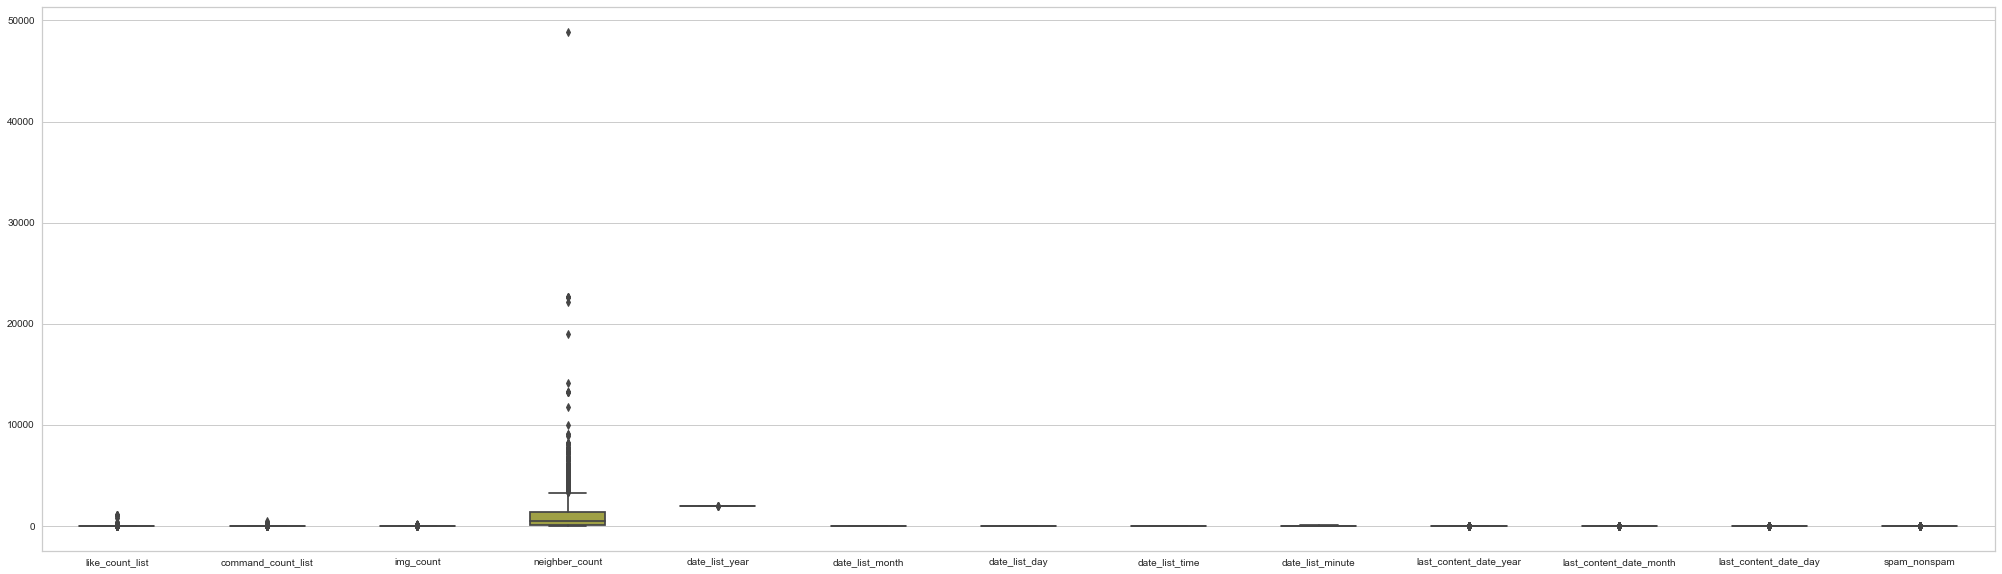

In [119]:
fig, ax = plt.subplots(figsize=(35, 10))
boxplot = sns.boxplot(data=ana_df,ax=ax, width=0.5)
boxplot.tick_params(labelsize=10)
plt.savefig('boxplot.png')

c:\Users\jhu56\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


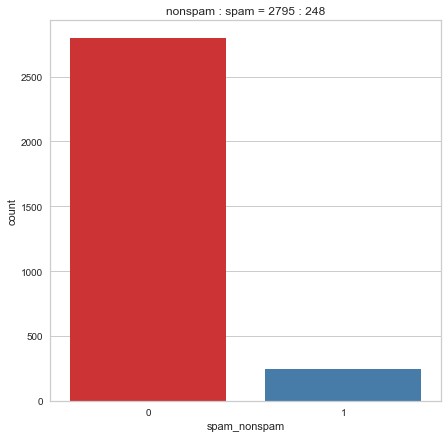

In [120]:
#라벨 분포 파악
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
sns.countplot(ana_df['spam_nonspam'], palette='Set1', ax=ax)
ax.set_title("nonspam : spam = {} : {}".format(*ana_df['spam_nonspam'].value_counts()))
plt.show()

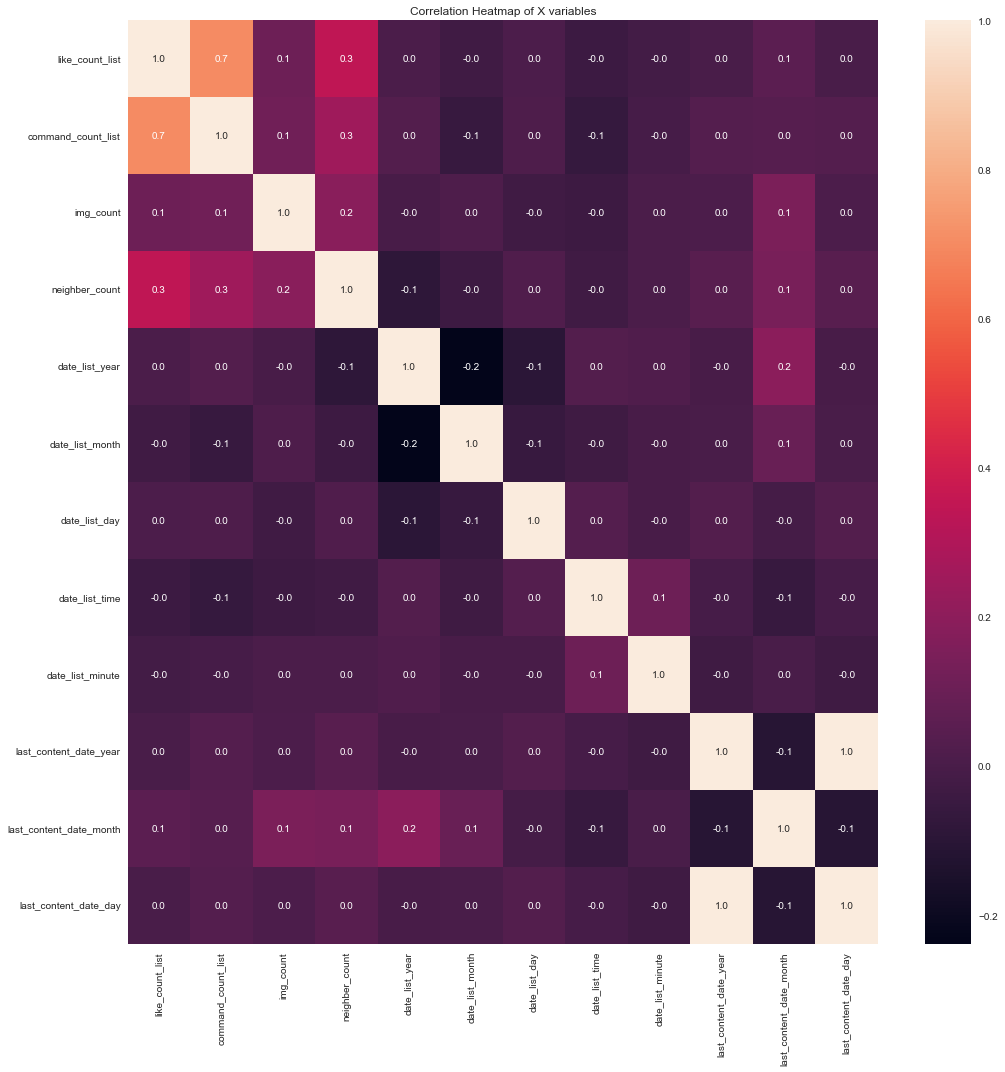

In [121]:
#각 컬럼 값에 대한 값 변화 확인
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax = sns.heatmap(ana_df.drop(['spam_nonspam'], axis=1).corr(), annot=True, fmt='.1f')
ax.set_title("Correlation Heatmap of X variables")
plt.tight_layout()
plt.show(fig)

### 3-(5)-2  train, test, stratify 변수 분할

In [122]:
X = ana_df.drop('spam_nonspam', axis=1)
y = ana_df['spam_nonspam'].values
y = y.astype('int')

In [123]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=2019,
                                                    stratify = y)

## 3-(6) Classification 모델 모델링

### 3-(6)-1 DecisionTree

In [124]:
from sklearn.tree import DecisionTreeClassifier

In [125]:
dtc = DecisionTreeClassifier(random_state = 2021)

#GridSearchCV의 param_grid 설정
#불순도 함수 : gini, entropy
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 4, 6, 8, 10, None]}

#param_grid 2X6=12
#cv=20 이므로 12X20=240번의 학습/평가가 이루어짐
dtc_cv = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=20)

dtc_cv.fit(X_train, y_train)

GridSearchCV(cv=20, estimator=DecisionTreeClassifier(random_state=2021),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None]})

In [126]:
#best_params_ : 최고 점수를 낸 파라미터
#best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형

print('Best parameters (Grid Search): \n',dtc_cv.best_params_)
print(dtc_cv.best_estimator_)

Best parameters (Grid Search): 
 {'criterion': 'entropy', 'max_depth': None}
DecisionTreeClassifier(criterion='entropy', random_state=2021)


### Decision Tree 분류 성능 측정(Accuracy, Precision, Recall, F1)

In [127]:
y_pred = dtc_cv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

acc = accuracy_score(y_test, y_pred)
print('[Accuracy]: {:.2f}%'.format(acc * 100))
pre = precision_score(y_test, y_pred)
print('[Precision]: {:.5f}%'.format(pre * 100))
rec = recall_score(y_test, y_pred)
print('[Recall]: {:.5f}%'.format(rec * 100))
f1 = f1_score(y_test, y_pred)
print('[F1_score]: {:.5f}%'.format(f1 * 100))

[[545  14]
 [  3  47]]
[Accuracy]: 97.21%
[Precision]: 77.04918%
[Recall]: 94.00000%
[F1_score]: 84.68468%


### Decision Tree 변수 중요도

[0.09450625 0.0699832  0.20385009 0.20533876 0.02999459 0.04369417
 0.05844808 0.06897959 0.09769823 0.05622651 0.03010432 0.0411762 ]


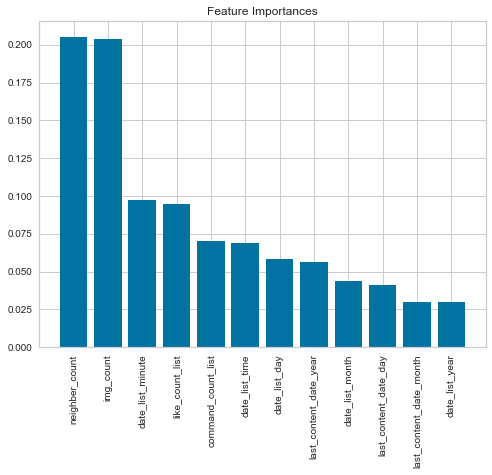

In [128]:
#시각화할 변수 개수 설정
topK = 12

#내림차순 정렬
importances = dtc_cv.best_estimator_.feature_importances_
index = np.argsort(importances)[::-1]
print(importances)

plt.figure(figsize=(8, 6))
plt.title('Feature Importances')
plt.bar(range(topK),
        importances[index][:topK],
        align='center')
plt.xticks(range(topK), X.columns[index][:topK], rotation=90)
plt.xlim([-1, topK])
plt.show()

### ROC 분석을 통한 AUC 수치 확인

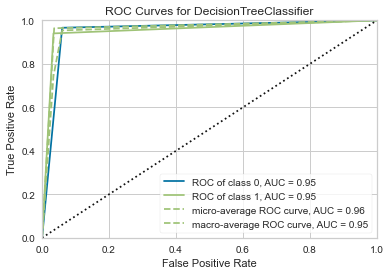

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [129]:
visualizer_dtc_cv = ROCAUC(dtc)

visualizer_dtc_cv.fit(X_train, y_train)       
visualizer_dtc_cv.score(X_test, y_test)
visualizer_dtc_cv.show()     

### 3-(6)-2 Random Forest

In [130]:
rf = RandomForestClassifier(random_state=2019)

#GridSearchCV의 param_grid 설정
#n_estimators : 최대 트리의 개수
#불순도 함수 : gini, entropy
param_grid = {'n_estimators': [5, 10, 15, 20, 25, 30, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [2, 4, 6]}

#param_grid 7X2X3=42
#cv=10 이므로 10X42=420번의 학습/평가가 이루어짐
rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10)

rf_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2019),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 100]})

In [131]:
#best_params_ : 최고 점수를 낸 파라미터
#best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형

print('Best parameters (Grid Search): \n',rf_cv.best_params_)
print(rf_cv.best_estimator_)

Best parameters (Grid Search): 
 {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 10}
RandomForestClassifier(max_depth=6, n_estimators=10, random_state=2019)


### Random Forest 분류 성능 측정(Accuracy, Precision, Recall, F1) 

In [132]:
y_pred = rf_cv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

acc = accuracy_score(y_test, y_pred)
print('[Accuracy]: {:.2f}%'.format(acc * 100))
pre = precision_score(y_test, y_pred)
print('[Precision]: {:.5f}%'.format(pre * 100))
rec = recall_score(y_test, y_pred)
print('[Recall]: {:.5f}%'.format(rec * 100))
f1 = f1_score(y_test, y_pred)
print('[F1_score]: {:.5f}%'.format(f1 * 100))

[[559   0]
 [ 42   8]]
[Accuracy]: 93.10%
[Precision]: 100.00000%
[Recall]: 16.00000%
[F1_score]: 27.58621%


### Random Forest 변수 중요도

[0.13511683 0.08231393 0.18753739 0.17948648 0.0202106  0.08284756
 0.07696413 0.03917776 0.08415929 0.02880748 0.01864143 0.06473712]


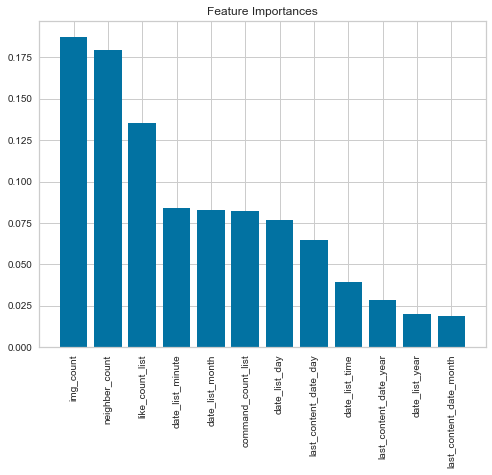

In [133]:
#시각화할 변수 개수 설정
topK = 12

#내림차순 정렬
importances = rf_cv.best_estimator_.feature_importances_
index = np.argsort(importances)[::-1]
print(importances)

plt.figure(figsize=(8, 6))
plt.title('Feature Importances')
plt.bar(range(topK),
        importances[index][:topK],
        align='center')
plt.xticks(range(topK), X.columns[index][:topK], rotation=90)
plt.xlim([-1, topK])
plt.show()

### ROC 분석을 통한 AUC 수치 확인

c:\Users\jhu56\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


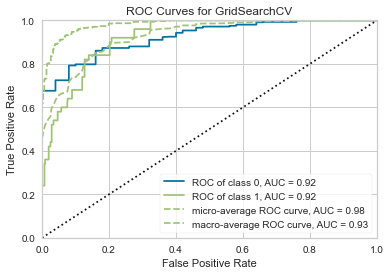

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [134]:
visualizer_rf_cv = ROCAUC(rf_cv, clases=["1","2"])

visualizer_rf_cv.fit(X_train, y_train)   
visualizer_rf_cv.score(X_test, y_test)      
visualizer_rf_cv.show()     

### 3-(6)-3 Logistic Regression

In [135]:
log = LogisticRegression(random_state=2019)

log.fit(X_train, y_train)

c:\Users\jhu56\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=2019)

### Logistic Regression 분류 성능 측정(Accuracy, Precision, Recall, F1) 

In [136]:
y_pred = log.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

acc = accuracy_score(y_test, y_pred)
print('[Accuracy]: {:.2f}%'.format(acc * 100))
pre = precision_score(y_test, y_pred)
print('[Precision]: {:.5f}%'.format(pre * 100))
rec = recall_score(y_test, y_pred)
print('[Recall]: {:.5f}%'.format(rec * 100))
f1 = f1_score(y_test, y_pred)
print('[F1_score]: {:.5f}%'.format(f1 * 100))

[[559   0]
 [ 50   0]]
[Accuracy]: 91.79%
[Precision]: 0.00000%
[Recall]: 0.00000%
[F1_score]: 0.00000%


c:\Users\jhu56\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ROC 분석을 통한 AUC 수치 확인

c:\Users\jhu56\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


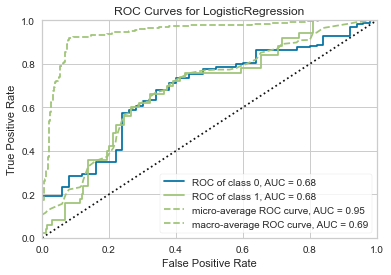

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [137]:
visualizer_log = ROCAUC(log, clases=["1","2"])

visualizer_log.fit(X_train, y_train)       
visualizer_log.score(X_test, y_test)        
visualizer_log.show()     

### 3-(6)-4  Xgboost Classifier

In [138]:
xg = XGBClassifier(random_state = 2021)

#GridSearchCV의 param_grid 설정
#n_estimators : 학습기의 개수(반복 횟수)
#불순도 함수 : gini, entropy
#min_child_weight : 이것을 기준으로 추가 분기 결정
#colsample_bytree : 각 트리마다의 feature 샘플링 비율
param_grid = {'n_estimators': [5, 10, 15, 20, 25, 30, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [2, 4, 6],
             'learning_rate':[0.1, 0.3],
             'min_child_weight':[1,3], 
              'colsample_bytree':[0.5,0.75]}

#param_grid 7X2X3X2X2X2=336
#cv=10 이므로 336X410=3360번의 학습/평가가 이루어짐
xg_cv = GridSearchCV(estimator=xg, param_grid=param_grid, cv=10)

xg_cv.fit(X_train, y_train)

[19:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could b

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [139]:
#best_params_ : 최고 점수를 낸 파라미터
#best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형

print('Best parameters (Grid Search): \n',xg_cv.best_params_)
print(xg_cv.best_estimator_)

Best parameters (Grid Search): 
 {'colsample_bytree': 0.5, 'criterion': 'gini', 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              criterion='gini', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=2021, reg_alpha=0, ...)


### Xgboost Classifier 분류 성능 측정(Accuracy, Precision, Recall, F1) 

In [140]:
y_pred = xg_cv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

acc = accuracy_score(y_test, y_pred)
print('[Accuracy]: {:.2f}%'.format(acc * 100))
pre = precision_score(y_test, y_pred)
print('[Precision]: {:.5f}%'.format(pre * 100))
rec = recall_score(y_test, y_pred)
print('[Recall]: {:.5f}%'.format(rec * 100))
f1 = f1_score(y_test, y_pred)
print('[F1_score]: {:.5f}%'.format(f1 * 100))

[[558   1]
 [  3  47]]
[Accuracy]: 99.34%
[Precision]: 97.91667%
[Recall]: 94.00000%
[F1_score]: 95.91837%


### Xgboost Classifier 변수 중요도

[0.06976634 0.06087043 0.09347754 0.09785292 0.11936161 0.06608701
 0.06839172 0.0703747  0.08991265 0.07908162 0.1184684  0.06635504]


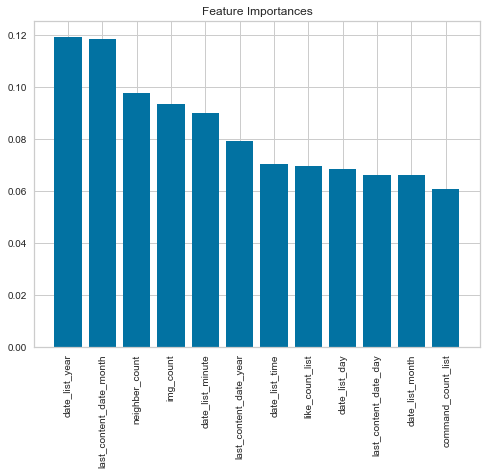

In [141]:
#시각화할 변수 개수 설정
topK = 12

#내림차순 정렬
importances = xg_cv.best_estimator_.feature_importances_
index = np.argsort(importances)[::-1]
print(importances)

plt.figure(figsize=(8, 6))
plt.title('Feature Importances')
plt.bar(range(topK),
        importances[index][:topK],
        align='center')
plt.xticks(range(topK), X.columns[index][:topK], rotation=90)
plt.xlim([-1, topK])
plt.show()

### ROC 분석을 통한 AUC 수치 확인 

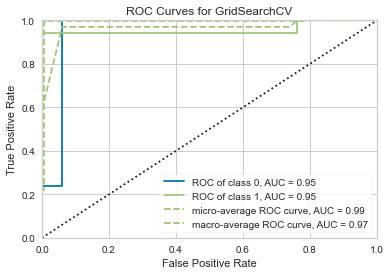

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [142]:
visualizer_xg_cv = ROCAUC(xg_cv, clases=["1","2"])

visualizer_xg_cv.fit(X_train, y_train)        
visualizer_xg_cv.score(X_test, y_test)  
visualizer_xg_cv.show()     

## 3-(7) Xgboost Classifier 를 이용한 허위리뷰 제거

In [143]:
update_spam_nonspam = xg_cv.best_estimator_.predict(X)
update_spam_nonspam = list(update_spam_nonspam)
blog_review['spam_nonspam'] = update_spam_nonspam

In [144]:
#중복값 삭제
processed_blog_review = blog_review.drop_duplicates(keep = 'first')
len(processed_blog_review)

2861

In [145]:
#허위 리뷰 키워드가 들어가진 허위 리뷰 리스트 생성
processed_spam_review = processed_blog_review[processed_blog_review['blog review'].str.contains(spam_words[0], na=False)]
for i in range(1, len(spam_words)): 
    temp = processed_blog_review[processed_blog_review['blog review'].str.contains(spam_words[i], na=False)]
    processed_spam_review = pd.concat([processed_spam_review, temp])
print(len(processed_spam_review))

91


In [146]:
#모델에 의해 spam으로 판별된 추가적인 데이터 생성
spam_review_result = processed_blog_review[processed_blog_review['spam_nonspam'] == 1]
processed_spam_review = pd.concat([processed_spam_review,spam_review_result])
print(len(processed_spam_review))

157


In [147]:
#중복값 삭제
print(len(processed_spam_review))
processed_spam_review = processed_spam_review.drop_duplicates(keep = 'first')
print(len(processed_spam_review))

157
67


### 3-(7)-1 허위 리뷰 데이터 저장

In [148]:
processed_spam_review.to_csv('processed_spam_review.csv', encoding="utf-8-sig")

### 3-(7)-2 기존 블로그 리뷰에서 허위 리뷰 삭제 

In [149]:
spam_review_num = set(processed_spam_review['index'])
spam_review_num = list(spam_review_num)
len(spam_review_num)

67

In [150]:
processed_blog_review[0:3]

num         name blog or review                              blog name  \
0    1  배곧 또잇카페 배곧점         블로그 리뷰                   TTOEATCAFE 배곧카페 뷰맛집!   
1    2  배곧 또잇카페 배곧점         블로그 리뷰                      배곧 한울공원 뷰 [또잇카페]    
2    3  배곧 또잇카페 배곧점         블로그 리뷰  배곧카페 TTOEATCAFE 또잇 : 배곧한울공원카페 / 배곧디저트   

   like_count_list  command_count_list  img_count  neighber_count  \
0                5                   6         21            1071   
1                7                   4         23             191   
2                5                   2         30             111   

                                         blog review  index  spam_nonspam  \
0  배곧 한울공원이 산책하기에 너무 좋은 곳이라 자주 가요오후 시간에 산책하면 노을지는...      0             0   
1  안녕 여러분 주말에 배곧 한울공원에 갔다가 뷰맛집 케이쿠 맛집이라는 또잇카페를 다녀...      1             0   
2  주말에 다녀 오기 딱 좋은 카페를 발견했다 생명공원과 한울공원 가까이에 있는 배곧 ...      2             0   

   date_list_year  date_list_month  date_list_day  date_list_time  \
0            2021                8             21              13   
1            2021               11             14              22   
2            2021               11             15               8   

   date_list_minute  last_content_date_year  last_content_date_month  \
0                36                      16                       11   
1                39                      14                       11   
2                39                      15                       11   

   last_content_date_day  
0                     16  
1                     14  
2                     15

In [151]:
i = 0
for num in spam_review_num:
    spam_review = processed_blog_review[processed_blog_review['index'] == num].index
    processed_blog_review = processed_blog_review.drop(spam_review)

In [152]:
processed_blog_review[0:3]

num         name blog or review                              blog name  \
0    1  배곧 또잇카페 배곧점         블로그 리뷰                   TTOEATCAFE 배곧카페 뷰맛집!   
1    2  배곧 또잇카페 배곧점         블로그 리뷰                      배곧 한울공원 뷰 [또잇카페]    
2    3  배곧 또잇카페 배곧점         블로그 리뷰  배곧카페 TTOEATCAFE 또잇 : 배곧한울공원카페 / 배곧디저트   

   like_count_list  command_count_list  img_count  neighber_count  \
0                5                   6         21            1071   
1                7                   4         23             191   
2                5                   2         30             111   

                                         blog review  index  spam_nonspam  \
0  배곧 한울공원이 산책하기에 너무 좋은 곳이라 자주 가요오후 시간에 산책하면 노을지는...      0             0   
1  안녕 여러분 주말에 배곧 한울공원에 갔다가 뷰맛집 케이쿠 맛집이라는 또잇카페를 다녀...      1             0   
2  주말에 다녀 오기 딱 좋은 카페를 발견했다 생명공원과 한울공원 가까이에 있는 배곧 ...      2             0   

   date_list_year  date_list_month  date_list_day  date_list_time  \
0            2021                8             21              13   
1            2021               11             14              22   
2            2021               11             15               8   

   date_list_minute  last_content_date_year  last_content_date_month  \
0                36                      16                       11   
1                39                      14                       11   
2                39                      15                       11   

   last_content_date_day  
0                     16  
1                     14  
2                     15

### 3-(7)-3 허위 리뷰를 제거한 리뷰 csv 형태로 저장

In [153]:
processed_blog_review.to_csv('processed_place_blog_review2.csv', encoding = "utf-8-sig")

# 4. 식당 리뷰와 관련 없는 내용 제거

In [154]:
#허위 리뷰를 제거한 블로그 리뷰 csv파일 불러오기
processed_blog_review_list=pd.read_csv('processed_place_blog_review2.csv',encoding='utf-8')
processed_blog_review2=processed_blog_review_list[['index','num', 'name','blog or review','blog name','like_count_list','command_count_list', 'img_count','neighber_count','blog review']]

## 4-(1) 관련 라이브러리 호출 

In [155]:
#형태소 분석을 하기위해 필요한 라이브러리
from konlpy.tag import Okt 

#단어 임베딩 라이브러리
from gensim.models import FastText 
from gensim import models
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import fasttext

import urllib.request

## 4-(2) 형태소 분석

In [156]:
okt=Okt()

processed_blog_review_dic3={}

#블로그 리뷰 정보를 담기 위한 최종 배열
processed_blog_review_arr3=[]

#리뷰 내용만을 담기 위한 배열
final_result=[]

stop_words=['은','는','이','가','을','를','에','에게','들','으로','도']

for idx,row in processed_blog_review2.iterrows():
        #순서,식당 이름, 블로그 이름, 블로그 리뷰 내용 가져오기
        index=row['index']
        num=row['num']
        place_name=row['name']
        blog_or_review=row['blog or review']
        blog_name=row['blog name']
        like_count_list=row['like_count_list']
        command_count_list=row['command_count_list']
        img_count=row['img_count']
        neighber_count=row['neighber_count']
        blog_review=row['blog review']
        blog_review_final_result=[]
        
        blog_review_result = okt.morphs(blog_review)
        
        for word in blog_review_result:
            if word not in stop_words:
                blog_review_final_result.append(word)
                
        processed_blog_review_dic3 = {
                'index':index,
                'num': num,
                'name' : place_name,
                'blog or review' : blog_or_review,
                'blog name' : blog_name,
                'like_count_list' : like_count_list,
                'command_count_list' : command_count_list,
                'img_count' : img_count,
                'neighber_count' : neighber_count,
                'blog review' : blog_review_final_result
        }
        
        print("=====================================")
        print("num: "+str(num))
        print("place_name: "+place_name)
        
        
        processed_blog_review_arr3.append(processed_blog_review_dic3)
        final_result.append(blog_review_final_result)

num: 1
place_name: 배곧 또잇카페 배곧점
num: 2
place_name: 배곧 또잇카페 배곧점
num: 3
place_name: 배곧 또잇카페 배곧점
num: 4
place_name: 배곧 또잇카페 배곧점
num: 5
place_name: 배곧 또잇카페 배곧점
num: 6
place_name: 배곧 또잇카페 배곧점
num: 7
place_name: 배곧 또잇카페 배곧점
num: 8
place_name: 배곧 또잇카페 배곧점
num: 9
place_name: 배곧 또잇카페 배곧점
num: 10
place_name: 배곧 또잇카페 배곧점
num: 11
place_name: 배곧 또잇카페 배곧점
num: 12
place_name: 배곧 또잇카페 배곧점
num: 13
place_name: 배곧 또잇카페 배곧점
num: 14
place_name: 배곧 또잇카페 배곧점
num: 15
place_name: 배곧 또잇카페 배곧점
num: 16
place_name: 배곧 또잇카페 배곧점
num: 17
place_name: 배곧 또잇카페 배곧점
num: 18
place_name: 배곧 또잇카페 배곧점
num: 19
place_name: 배곧 또잇카페 배곧점
num: 20
place_name: 배곧 또잇카페 배곧점
num: 21
place_name: 배곧 또잇카페 배곧점
num: 22
place_name: 배곧 또잇카페 배곧점
num: 23
place_name: 배곧 또잇카페 배곧점
num: 24
place_name: 배곧 또잇카페 배곧점
num: 26
place_name: 배곧 또잇카페 배곧점
num: 27
place_name: 배곧 또잇카페 배곧점
num: 28
place_name: 배곧 또잇카페 배곧점
num: 29
place_name: 배곧 또잇카페 배곧점
num: 30
place_name: 배곧 또잇카페 배곧점
num: 31
place_name: 배곧 또잇카페 배곧점
num: 32
place_name: 배곧 또잇카페 배곧점
num: 33
place_nam

## 4-(3) FastText 모델 생성 및 학습

In [157]:
#토큰화한 블로그 리뷰들을 이용하여 FastText 모델 생성
#size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원
#window = 컨텍스트 윈도우 크기
#min_count = 단어 최소 빈도 수 제한
#workers = 학습을 위한 프로세스 수

model = FastText(final_result, size=300, window=5, min_count=2, workers=4)

TypeError: __init__() got an unexpected keyword argument 'size'

In [ ]:
model.wv.most_similar('카페')

[('카페나', 0.9505082368850708),
 ('카페라테', 0.8888834118843079),
 ('카페인', 0.8794620037078857),
 ('카페스플렌디드', 0.8386857509613037),
 ('테일러', 0.8244320154190063),
 ('버튼', 0.8122130632400513),
 ('검은', 0.7542110085487366),
 ('스플렌디드', 0.7507830858230591),
 ('우드', 0.7507485747337341),
 ('식당', 0.7465256452560425)]

In [ ]:
len(model.wv.vocab.keys())

25874

In [ ]:
model.train(final_result, total_examples=len(final_result), epochs=500) 

In [ ]:
model.wv.most_similar('카페')

[('맛집', 0.4473801851272583),
 ('카페스플렌디드', 0.4226754307746887),
 ('곳', 0.42052119970321655),
 ('신도시', 0.41557633876800537),
 ('식당', 0.40235692262649536),
 ('커피', 0.40139758586883545),
 ('인테리어', 0.3973124325275421),
 ('스플렌디드', 0.3883885145187378),
 ('가게', 0.37778598070144653),
 ('레스토랑', 0.3766469955444336)]

In [ ]:
model.wv.similarity('배곧','엄마')

-0.009167237

In [ ]:
#모델 저장
model.save('model')

In [ ]:
#모델 불러오기
model = FastText.load("model")

## 4-(4) Word2Vec pre-trained 한국어 모델 사용-'ko.bin'

In [ ]:
#미리 훈련된 한국어 모델 불러오기
PretrainedFastTextModel = Word2Vec.load('D:/채리/4학년 2학기/딥러닝프레임워크_박성호/팀플/ko.bin')

In [ ]:
PretrainedFastTextModel.wv.most_similar('카페')

[('라운지', 0.5792115926742554),
 ('사이트', 0.5742361545562744),
 ('게시판', 0.5695616006851196),
 ('레스토랑', 0.5676875114440918),
 ('커뮤니티', 0.5630788803100586),
 ('갤러리', 0.557378888130188),
 ('네이버', 0.5541419982910156),
 ('식당', 0.5470826625823975),
 ('포털', 0.5461200475692749),
 ('쇼핑몰', 0.545877993106842)]

In [ ]:
#다운로드 받은 word2vec모델이 형식이 맞지 않아 새로 저장
PretrainedFastTextModel.wv.save_word2vec_format("ko.bin.gz", binary=False)

In [ ]:
#Fine tuning 할 새로운 Word2Vec 모델 생성
#PretrainedFastTextModel과 'vector_size'가 같은 model을 생성

TransferedModel=Word2Vec(size=PretrainedFastTextModel.vector_size, min_count=1)

In [ ]:
TransferedModel.build_vocab([PretrainedFastTextModel.wv.vocab.keys()])

In [ ]:
#주어진 데이터로 새로운 모델의 단어 추가
#update parameter를 True로 설정

TransferedModel.build_vocab(final_result,update=True)

In [ ]:
len(TransferedModel.wv.vocab.keys())

72584

In [ ]:
#Pretrained 모델의 학습 파라미터를 기반으로 새로운 모델의 학습 파라미터 초기화
#학습파라미터를 'filepath'에 있는 값으로 모두 업데이트해줌
#lockf=0.0 : 보통은 학습 파라미터를 update하지 못하도록 lock이 걸려있음
#lockf=1 : 학습 파라미터를 update하도록 lock 해제

file_path1="D:/채리/4학년 2학기/딥러닝프레임워크_박성호/팀플/ko.bin.gz"

TransferedModel.intersect_word2vec_format(file_path1, lockf=1.0, binary=False, encoding='utf-8', unicode_errors='ignore')

In [ ]:
#새로운 데이터 기반의 학습
TransferedModel.train(final_result, total_examples=len(final_result), epochs=500)

(590853413, 642327500)

In [ ]:
TransferedModel.wv.most_similar('카페')

[('곳', 0.5553063750267029),
 ('식당', 0.5160421133041382),
 ('커피', 0.48788052797317505),
 ('맛집', 0.4810330271720886),
 ('가게', 0.47744476795196533),
 ('음식점', 0.4720848798751831),
 ('공간', 0.46648913621902466),
 ('동네', 0.45808830857276917),
 ('레스토랑', 0.4397212862968445),
 ('신도시', 0.42903369665145874)]

In [ ]:
TransferedModel.wv.similarity('배곧','엄마')

0.054697797

In [ ]:
#모델 저장
TransferedModel.save('TransferedModel')

In [ ]:
#모델 불러오기
TransferedModel = Word2Vec.load("TransferedModel")

## 4-(5) FastText pre-trained 한국어 모델 사용-'cc.ko.300.bin.gz'

In [ ]:
#모델 다운로드
urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz', filename='cc.ko.300.bin.gz')

('cc.ko.300.bin.gz', <http.client.HTTPMessage at 0x203c41c1250>)

In [ ]:
#미리 훈련된 한국어 모델 불러오기
PretrainedFastTextModel2=fasttext.load_facebook_model('D:/채리/4학년 2학기/딥러닝프레임워크_박성호/팀플/cc.ko.300.bin.gz')

In [ ]:
#다운로드 받은 fasttext형식이 맞지 않아 새로 저장
PretrainedFastTextModel2.wv.save_word2vec_format("cc.ko.300.bin.gz", binary=False)

In [ ]:
PretrainedFastTextModel2.wv.most_similar('카페')

[('까페', 0.7127674221992493),
 ('페드로키', 0.6023558378219604),
 ('카페나', 0.5754310488700867),
 ('교회홈', 0.5745173692703247),
 ('카페를', 0.572992742061615),
 ('카페는', 0.5614081621170044),
 ('드롭탑', 0.5575875639915466),
 ('카페에', 0.556739866733551),
 ('카페다', 0.552950382232666),
 ('마간다', 0.5501942038536072)]

In [ ]:
PretrainedFastTextModel2.wv.similarity('배곧','엄마')

0.16861778

### 4-(5)-1 주어진 데이터를 활용한 Fine Tuning

In [ ]:
#Fine tuning 할 새로운 Word2Vec 모델 생성(FastText는 fine tuning할 방법이 없음)
#PretrainedFastTextModel2과 'vector_size'가 같은 model을 생성

TransferedModel2=Word2Vec([PretrainedFastTextModel2.wv.vocab.keys()],size=PretrainedFastTextModel2.vector_size, min_count=1)

In [ ]:
#주어진 데이터로 새로운 모델의 단어 추가
#update parameter를 True로 설정

TransferedModel2.build_vocab(final_result,update=True)

In [ ]:
len(TransferedModel2.wv.vocab.keys())

2015764

In [ ]:
#Pretrained 모델의 학습 파라미터를 기반으로 새로운 모델의 학습 파라미터 초기화
#학습파라미터를 'filepath'에 있는 값으로 모두 업데이트해줌
#lockf=0.0 : 보통은 학습 파라미터를 update하지 못하도록 lock이 걸려있음
#lockf=1 : 학습 파라미터를 update하도록 lock 해제

file_path2="D:/채리/4학년 2학기/딥러닝프레임워크_박성호/팀플/cc.ko.300.bin.gz"

TransferedModel2.intersect_word2vec_format(file_path2, lockf=1.0, binary=False, encoding='utf-8', unicode_errors='ignore')

In [ ]:
#새로운 데이터 기반의 학습
TransferedModel2.train(final_result, total_examples=len(final_result), epochs=500)

(590865890, 642327500)

In [ ]:
TransferedModel2.wv.most_similar('카페')

[('배곧', 0.8295024633407593),
 ('.', 0.8186916708946228),
 ('맛집', 0.8122650384902954),
 ('것', 0.8063405156135559),
 ('다', 0.8057481646537781),
 ('너무', 0.8056133985519409),
 ('한', 0.8036484122276306),
 ('곳', 0.7971469759941101),
 ('로', 0.7964716553688049),
 ('의', 0.7937042713165283)]

In [ ]:
TransferedModel2.wv.similarity('배곧','엄마')

0.20305128

In [ ]:
#모델 저장
TransferedModel2.save('TransferedModel2')

In [ ]:
# 모델 불러오기
TransferedModel2 = Word2Vec.load("TransferedModel2")

## 4-(6) FastText 모델을 사용하여 관련없는 내용 제거

### 4-(6)-1 데이터 복사

In [ ]:
temp1=processed_blog_review_arr3.copy() #FastText 모델
temp2=processed_blog_review_arr3.copy() #Word2Vec pre-trained 모델
temp3=processed_blog_review_arr3.copy() #FastText pre-trained 모델

### 4-(6)-2 유사도를 비교할 기준 문장

In [ ]:
test_sentence=temp1[0]['blog review']

In [ ]:
test_sentence

['배곧',
 '한',
 '울',
 '공원',
 '산책',
 '하기에',
 '너무',
 '좋은',
 '곳',
 '이라',
 '자주',
 '가요',
 '오후',
 '시간',
 '산책',
 '하면',
 '노을',
 '지는',
 '모습',
 '보며',
 '공원',
 '걷는',
 '게',
 '얼마나',
 '좋은지',
 '몰라',
 '요',
 '오늘',
 '아이',
 '과',
 '산책',
 '하다가',
 '예쁜',
 '카페',
 '발',
 '견해',
 '서',
 '갔다',
 '왔어요',
 '.',
 '야외',
 '테라스',
 '있고',
 '시원하게',
 '음료',
 '마시기',
 '좋더라고요',
 '주차',
 '공간',
 '넓어서',
 '차',
 '가져가시는',
 '분',
 '에게도',
 '좋답니다',
 '.',
 '또',
 '잇',
 '카페',
 '배곧',
 '점',
 '매장',
 '늘',
 '청결히',
 '하고',
 '계시',
 '고',
 '위생',
 '특히',
 '신경',
 '쓰고',
 '계셔서',
 '안심',
 '하고',
 '이용',
 '할',
 '수',
 '있는',
 '배곧',
 '카페',
 '예',
 '요',
 '매장',
 '들어서면',
 '출입',
 '명부',
 '안심',
 '콜',
 '등록',
 '후',
 '손소독제',
 '필수',
 '또',
 '잇',
 '카페',
 '메뉴판',
 '또',
 '잇',
 '카페',
 '의',
 '사장',
 '님',
 '과',
 '매니저',
 '님',
 '바리스타',
 '디플로마',
 '자격',
 '소유',
 '한',
 '전문가',
 '분들',
 '시더',
 '라',
 '고요',
 '더욱',
 '맛',
 '좋을',
 '것',
 '같아요',
 '.',
 '아메리카노',
 '와',
 '라떼',
 '고소한',
 '맛',
 '특징',
 '예요',
 '커피',
 '의',
 '진한',
 '향',
 '느끼며',
 '뷰',
 '맛집',
 '또',
 '잇',
 '카페',
 '에서',
 '편안한',
 '시간',
 '보낼',
 '수',
 '있답

In [ ]:
len(test_sentence)

618

### 4-(6)-3 유사도의 평균 계산

In [ ]:
fasttext_similarity=[]
for blog_info in temp1:
    blog_review=blog_info['blog review']
    for test_word in test_sentence:
        for word in blog_review:
            if word=='.':
                continue
            similarity=model.wv.similarity(test_word,word)
            fasttext_similarity.append(similarity)
                
fasttext_average = sum(fasttext_similarity)/len(fasttext_similarity)

In [ ]:
print(fasttext_average)

0.01202106707845227


### 4-(6)-4 유사도의 평균보다 낮은 단어 제거

In [ ]:
processed_blog_review_dic3_1={}

#블로그 리뷰 정보를 담기 위한 최종 배열
processed_blog_review_arr3_1=[]

#삭제된 리뷰들을 담기 위한 dict
delete_dict1={}

#삭제된 리뷰 정보를 담기 위한 최종 배열
delete_arr1=[]

#삭제된 단어를 담기 위한 배열
delete_word1=[]

for blog_info in temp1:
        #순서,식당 이름, 블로그 이름, 블로그 리뷰 내용 가져오기
        index=blog_info['index']
        num=blog_info['num']
        place_name=blog_info['name']
        blog_or_review=blog_info['blog or review']
        blog_name=blog_info['blog name']
        like_count_list=blog_info['like_count_list']
        command_count_list=blog_info['command_count_list']
        img_count=blog_info['img_count']
        neighber_count=blog_info['neighber_count']
        blog_review=blog_info['blog review']
        final_result1=[]
        similarity1=0
        
        for word in blog_review:
            for test_word in test_sentence:
                if word=='.' or test_word=='.':
                    continue
                similarity=model.wv.similarity(word, test_word)
                similarity1=similarity1+similarity
            final_similarity=similarity1/len(test_sentence)
            if(final_similarity<fasttext_average):
                delete_word1.append(word)
                blog_review.remove(word)
                final_result1.append(word)
                    
        delete_dict1={
             'index':index,
             'num': num,
             'name' : place_name,
             'blog or review' : blog_or_review,
             'blog name' : blog_name,
             'like_count_list' : like_count_list,
             'command_count_list' : command_count_list,
             'img_count' : img_count,
             'neighber_count' : neighber_count,
             'blog review' : final_result1
        }
        
        delete_arr1.append(delete_dict1)
        
        processed_blog_review_dic3_1 = {
                'index':index,
                'num': num,
                'name' : place_name,
                'blog or review' : blog_or_review,
                'blog name' : blog_name,
                'like_count_list' : like_count_list,
                'command_count_list' : command_count_list,
                'img_count' : img_count,
                'neighber_count' : neighber_count,
                'blog review' : blog_review
        }
        
        print("=====================================")
        print("num: "+str(num))
        print("place_name: "+place_name)
        
        processed_blog_review_arr3_1.append(processed_blog_review_dic3_1)

num: 1
place_name: 배곧 또잇카페 배곧점
num: 2
place_name: 배곧 또잇카페 배곧점
num: 3
place_name: 배곧 또잇카페 배곧점
num: 4
place_name: 배곧 또잇카페 배곧점
num: 5
place_name: 배곧 또잇카페 배곧점
num: 6
place_name: 배곧 또잇카페 배곧점
num: 7
place_name: 배곧 또잇카페 배곧점
num: 8
place_name: 배곧 또잇카페 배곧점
num: 9
place_name: 배곧 또잇카페 배곧점
num: 10
place_name: 배곧 또잇카페 배곧점
num: 11
place_name: 배곧 또잇카페 배곧점
num: 12
place_name: 배곧 또잇카페 배곧점
num: 13
place_name: 배곧 또잇카페 배곧점
num: 14
place_name: 배곧 또잇카페 배곧점
num: 15
place_name: 배곧 또잇카페 배곧점
num: 16
place_name: 배곧 또잇카페 배곧점
num: 17
place_name: 배곧 또잇카페 배곧점
num: 18
place_name: 배곧 또잇카페 배곧점
num: 19
place_name: 배곧 또잇카페 배곧점
num: 20
place_name: 배곧 또잇카페 배곧점
num: 21
place_name: 배곧 또잇카페 배곧점
num: 22
place_name: 배곧 또잇카페 배곧점
num: 23
place_name: 배곧 또잇카페 배곧점
num: 24
place_name: 배곧 또잇카페 배곧점
num: 26
place_name: 배곧 또잇카페 배곧점
num: 27
place_name: 배곧 또잇카페 배곧점
num: 28
place_name: 배곧 또잇카페 배곧점
num: 29
place_name: 배곧 또잇카페 배곧점
num: 30
place_name: 배곧 또잇카페 배곧점
num: 31
place_name: 배곧 또잇카페 배곧점
num: 32
place_name: 배곧 또잇카페 배곧점
num: 33
place_nam

num: 78
place_name: 배곧 카츠오모이
num: 79
place_name: 배곧 카츠오모이
num: 80
place_name: 배곧 카츠오모이
num: 81
place_name: 배곧 카츠오모이
num: 82
place_name: 배곧 카츠오모이
num: 83
place_name: 배곧 카츠오모이
num: 84
place_name: 배곧 카츠오모이
num: 2
place_name: 배곧 양푼애등갈비
num: 4
place_name: 배곧 양푼애등갈비
num: 5
place_name: 배곧 양푼애등갈비
num: 6
place_name: 배곧 양푼애등갈비
num: 7
place_name: 배곧 양푼애등갈비
num: 8
place_name: 배곧 양푼애등갈비
num: 9
place_name: 배곧 양푼애등갈비
num: 10
place_name: 배곧 양푼애등갈비
num: 11
place_name: 배곧 양푼애등갈비
num: 12
place_name: 배곧 양푼애등갈비
num: 13
place_name: 배곧 양푼애등갈비
num: 14
place_name: 배곧 양푼애등갈비
num: 15
place_name: 배곧 양푼애등갈비
num: 16
place_name: 배곧 양푼애등갈비
num: 17
place_name: 배곧 양푼애등갈비
num: 18
place_name: 배곧 양푼애등갈비
num: 19
place_name: 배곧 양푼애등갈비
num: 20
place_name: 배곧 양푼애등갈비
num: 21
place_name: 배곧 양푼애등갈비
num: 22
place_name: 배곧 양푼애등갈비
num: 23
place_name: 배곧 양푼애등갈비
num: 24
place_name: 배곧 양푼애등갈비
num: 25
place_name: 배곧 양푼애등갈비
num: 26
place_name: 배곧 양푼애등갈비
num: 27
place_name: 배곧 양푼애등갈비
num: 28
place_name: 배곧 양푼애등갈비
num: 29
place_name: 배곧 양

num: 43
place_name: 배곧 투파인드피터 배곧점
num: 44
place_name: 배곧 투파인드피터 배곧점
num: 45
place_name: 배곧 투파인드피터 배곧점
num: 46
place_name: 배곧 투파인드피터 배곧점
num: 47
place_name: 배곧 투파인드피터 배곧점
num: 48
place_name: 배곧 투파인드피터 배곧점
num: 49
place_name: 배곧 투파인드피터 배곧점
num: 50
place_name: 배곧 투파인드피터 배곧점
num: 51
place_name: 배곧 투파인드피터 배곧점
num: 52
place_name: 배곧 투파인드피터 배곧점
num: 53
place_name: 배곧 투파인드피터 배곧점
num: 54
place_name: 배곧 투파인드피터 배곧점
num: 55
place_name: 배곧 투파인드피터 배곧점
num: 56
place_name: 배곧 투파인드피터 배곧점
num: 57
place_name: 배곧 투파인드피터 배곧점
num: 58
place_name: 배곧 투파인드피터 배곧점
num: 59
place_name: 배곧 투파인드피터 배곧점
num: 60
place_name: 배곧 투파인드피터 배곧점
num: 61
place_name: 배곧 투파인드피터 배곧점
num: 62
place_name: 배곧 투파인드피터 배곧점
num: 63
place_name: 배곧 투파인드피터 배곧점
num: 64
place_name: 배곧 투파인드피터 배곧점
num: 65
place_name: 배곧 투파인드피터 배곧점
num: 66
place_name: 배곧 투파인드피터 배곧점
num: 67
place_name: 배곧 투파인드피터 배곧점
num: 68
place_name: 배곧 투파인드피터 배곧점
num: 69
place_name: 배곧 투파인드피터 배곧점
num: 70
place_name: 배곧 투파인드피터 배곧점
num: 71
place_name: 배곧 투파인드피터 배곧점
num: 72
place_

num: 53
place_name: 배곧 정동진
num: 54
place_name: 배곧 정동진
num: 55
place_name: 배곧 정동진
num: 56
place_name: 배곧 정동진
num: 57
place_name: 배곧 정동진
num: 58
place_name: 배곧 정동진
num: 59
place_name: 배곧 정동진
num: 60
place_name: 배곧 정동진
num: 61
place_name: 배곧 정동진
num: 62
place_name: 배곧 정동진
num: 63
place_name: 배곧 정동진
num: 64
place_name: 배곧 정동진
num: 65
place_name: 배곧 정동진
num: 66
place_name: 배곧 정동진
num: 67
place_name: 배곧 정동진
num: 68
place_name: 배곧 정동진
num: 69
place_name: 배곧 정동진
num: 70
place_name: 배곧 정동진
num: 71
place_name: 배곧 정동진
num: 72
place_name: 배곧 정동진
num: 73
place_name: 배곧 정동진
num: 74
place_name: 배곧 정동진
num: 75
place_name: 배곧 정동진
num: 76
place_name: 배곧 정동진
num: 77
place_name: 배곧 정동진
num: 78
place_name: 배곧 정동진
num: 79
place_name: 배곧 정동진
num: 80
place_name: 배곧 정동진
num: 81
place_name: 배곧 정동진
num: 82
place_name: 배곧 정동진
num: 83
place_name: 배곧 정동진
num: 84
place_name: 배곧 정동진
num: 85
place_name: 배곧 정동진
num: 86
place_name: 배곧 정동진
num: 1
place_name: 배곧 Tailor.Button
num: 2
place_name: 배곧 Tailor.Button
num: 3
pla

num: 31
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 33
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 34
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 35
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 36
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 37
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 39
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 40
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 41
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 42
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 43
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 44
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 45
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 46
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 47
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 48
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 49
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 50
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 51
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 52
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 53
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 54
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 56
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 57
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 58
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 59
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 60
plac

num: 65
place_name: 배곧 카페 검은순수 배곧본점
num: 66
place_name: 배곧 카페 검은순수 배곧본점
num: 67
place_name: 배곧 카페 검은순수 배곧본점
num: 68
place_name: 배곧 카페 검은순수 배곧본점
num: 69
place_name: 배곧 카페 검은순수 배곧본점
num: 70
place_name: 배곧 카페 검은순수 배곧본점
num: 71
place_name: 배곧 카페 검은순수 배곧본점
num: 72
place_name: 배곧 카페 검은순수 배곧본점
num: 73
place_name: 배곧 카페 검은순수 배곧본점
num: 74
place_name: 배곧 카페 검은순수 배곧본점
num: 75
place_name: 배곧 카페 검은순수 배곧본점
num: 76
place_name: 배곧 카페 검은순수 배곧본점
num: 78
place_name: 배곧 카페 검은순수 배곧본점
num: 79
place_name: 배곧 카페 검은순수 배곧본점
num: 80
place_name: 배곧 카페 검은순수 배곧본점
num: 81
place_name: 배곧 카페 검은순수 배곧본점
num: 82
place_name: 배곧 카페 검은순수 배곧본점
num: 83
place_name: 배곧 카페 검은순수 배곧본점
num: 84
place_name: 배곧 카페 검은순수 배곧본점
num: 85
place_name: 배곧 카페 검은순수 배곧본점
num: 86
place_name: 배곧 카페 검은순수 배곧본점
num: 87
place_name: 배곧 카페 검은순수 배곧본점
num: 88
place_name: 배곧 카페 검은순수 배곧본점
num: 89
place_name: 배곧 카페 검은순수 배곧본점
num: 1
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
num: 2
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
num: 5
place_name: 배곧 Poke all day 포케&

num: 58
place_name: 배곧 구십도씨
num: 59
place_name: 배곧 구십도씨
num: 60
place_name: 배곧 구십도씨
num: 61
place_name: 배곧 구십도씨
num: 62
place_name: 배곧 구십도씨
num: 63
place_name: 배곧 구십도씨
num: 64
place_name: 배곧 구십도씨
num: 65
place_name: 배곧 구십도씨
num: 66
place_name: 배곧 구십도씨
num: 67
place_name: 배곧 구십도씨
num: 68
place_name: 배곧 구십도씨
num: 69
place_name: 배곧 구십도씨
num: 71
place_name: 배곧 구십도씨
num: 72
place_name: 배곧 구십도씨
num: 73
place_name: 배곧 구십도씨
num: 74
place_name: 배곧 구십도씨
num: 75
place_name: 배곧 구십도씨
num: 76
place_name: 배곧 구십도씨
num: 77
place_name: 배곧 구십도씨
num: 78
place_name: 배곧 구십도씨
num: 79
place_name: 배곧 구십도씨
num: 80
place_name: 배곧 구십도씨
num: 81
place_name: 배곧 구십도씨
num: 82
place_name: 배곧 구십도씨
num: 83
place_name: 배곧 구십도씨
num: 84
place_name: 배곧 구십도씨
num: 85
place_name: 배곧 구십도씨
num: 86
place_name: 배곧 구십도씨
num: 87
place_name: 배곧 구십도씨
num: 88
place_name: 배곧 구십도씨
num: 1
place_name: 배곧 엣홈파스타
num: 2
place_name: 배곧 엣홈파스타
num: 3
place_name: 배곧 엣홈파스타
num: 4
place_name: 배곧 엣홈파스타
num: 6
place_name: 배곧 엣홈파스타
num: 7
place_name: 배

num: 51
place_name: 배곧 세유카츠
num: 52
place_name: 배곧 세유카츠
num: 53
place_name: 배곧 세유카츠
num: 54
place_name: 배곧 세유카츠
num: 55
place_name: 배곧 세유카츠
num: 56
place_name: 배곧 세유카츠
num: 57
place_name: 배곧 세유카츠
num: 58
place_name: 배곧 세유카츠
num: 59
place_name: 배곧 세유카츠
num: 60
place_name: 배곧 세유카츠
num: 61
place_name: 배곧 세유카츠
num: 62
place_name: 배곧 세유카츠
num: 63
place_name: 배곧 세유카츠
num: 64
place_name: 배곧 세유카츠
num: 65
place_name: 배곧 세유카츠
num: 66
place_name: 배곧 세유카츠
num: 67
place_name: 배곧 세유카츠
num: 68
place_name: 배곧 세유카츠
num: 69
place_name: 배곧 세유카츠
num: 70
place_name: 배곧 세유카츠
num: 71
place_name: 배곧 세유카츠
num: 72
place_name: 배곧 세유카츠
num: 73
place_name: 배곧 세유카츠
num: 74
place_name: 배곧 세유카츠
num: 75
place_name: 배곧 세유카츠
num: 76
place_name: 배곧 세유카츠
num: 77
place_name: 배곧 세유카츠
num: 78
place_name: 배곧 세유카츠
num: 79
place_name: 배곧 세유카츠
num: 1
place_name: 배곧 모미지
num: 2
place_name: 배곧 모미지
num: 3
place_name: 배곧 모미지
num: 4
place_name: 배곧 모미지
num: 5
place_name: 배곧 모미지
num: 6
place_name: 배곧 모미지
num: 7
place_name: 배곧 모미지
num: 8

num: 63
place_name: 배곧 저스트텐동 배곧신도시점
num: 64
place_name: 배곧 저스트텐동 배곧신도시점
num: 65
place_name: 배곧 저스트텐동 배곧신도시점
num: 66
place_name: 배곧 저스트텐동 배곧신도시점
num: 67
place_name: 배곧 저스트텐동 배곧신도시점
num: 68
place_name: 배곧 저스트텐동 배곧신도시점
num: 69
place_name: 배곧 저스트텐동 배곧신도시점
num: 70
place_name: 배곧 저스트텐동 배곧신도시점
num: 71
place_name: 배곧 저스트텐동 배곧신도시점
num: 72
place_name: 배곧 저스트텐동 배곧신도시점
num: 73
place_name: 배곧 저스트텐동 배곧신도시점
num: 74
place_name: 배곧 저스트텐동 배곧신도시점
num: 75
place_name: 배곧 저스트텐동 배곧신도시점
num: 76
place_name: 배곧 저스트텐동 배곧신도시점
num: 77
place_name: 배곧 저스트텐동 배곧신도시점
num: 78
place_name: 배곧 저스트텐동 배곧신도시점
num: 79
place_name: 배곧 저스트텐동 배곧신도시점
num: 80
place_name: 배곧 저스트텐동 배곧신도시점
num: 81
place_name: 배곧 저스트텐동 배곧신도시점
num: 82
place_name: 배곧 저스트텐동 배곧신도시점
num: 1
place_name: 배곧 윌로우 우드
num: 2
place_name: 배곧 윌로우 우드
num: 3
place_name: 배곧 윌로우 우드
num: 4
place_name: 배곧 윌로우 우드
num: 5
place_name: 배곧 윌로우 우드
num: 6
place_name: 배곧 윌로우 우드
num: 7
place_name: 배곧 윌로우 우드
num: 8
place_name: 배곧 윌로우 우드
num: 9
place_name: 배곧 윌로우 우드
num: 10
place_name:

num: 11
place_name: 배곧 왈라비스스테이크
num: 12
place_name: 배곧 왈라비스스테이크
num: 13
place_name: 배곧 왈라비스스테이크
num: 14
place_name: 배곧 왈라비스스테이크
num: 15
place_name: 배곧 왈라비스스테이크
num: 16
place_name: 배곧 왈라비스스테이크
num: 1
place_name: 배곧 판다소바
num: 2
place_name: 배곧 판다소바
num: 3
place_name: 배곧 판다소바
num: 4
place_name: 배곧 판다소바
num: 5
place_name: 배곧 판다소바
num: 6
place_name: 배곧 판다소바
num: 7
place_name: 배곧 판다소바
num: 8
place_name: 배곧 판다소바
num: 9
place_name: 배곧 판다소바
num: 10
place_name: 배곧 판다소바
num: 11
place_name: 배곧 판다소바
num: 12
place_name: 배곧 판다소바
num: 13
place_name: 배곧 판다소바
num: 14
place_name: 배곧 판다소바
num: 15
place_name: 배곧 판다소바
num: 16
place_name: 배곧 판다소바
num: 17
place_name: 배곧 판다소바
num: 18
place_name: 배곧 판다소바
num: 19
place_name: 배곧 판다소바
num: 20
place_name: 배곧 판다소바
num: 21
place_name: 배곧 판다소바
num: 22
place_name: 배곧 판다소바
num: 23
place_name: 배곧 판다소바
num: 24
place_name: 배곧 판다소바
num: 25
place_name: 배곧 판다소바
num: 26
place_name: 배곧 판다소바
num: 27
place_name: 배곧 판다소바
num: 28
place_name: 배곧 판다소바
num: 29
place_name: 배곧 판다소바
num: 

num: 1
place_name: 배곧 별미지교 시흥점
num: 2
place_name: 배곧 별미지교 시흥점
num: 3
place_name: 배곧 별미지교 시흥점
num: 4
place_name: 배곧 별미지교 시흥점
num: 5
place_name: 배곧 별미지교 시흥점
num: 6
place_name: 배곧 별미지교 시흥점
num: 7
place_name: 배곧 별미지교 시흥점
num: 8
place_name: 배곧 별미지교 시흥점
num: 9
place_name: 배곧 별미지교 시흥점
num: 10
place_name: 배곧 별미지교 시흥점
num: 11
place_name: 배곧 별미지교 시흥점
num: 12
place_name: 배곧 별미지교 시흥점
num: 13
place_name: 배곧 별미지교 시흥점
num: 14
place_name: 배곧 별미지교 시흥점
num: 15
place_name: 배곧 별미지교 시흥점
num: 16
place_name: 배곧 별미지교 시흥점
num: 17
place_name: 배곧 별미지교 시흥점
num: 18
place_name: 배곧 별미지교 시흥점
num: 19
place_name: 배곧 별미지교 시흥점
num: 20
place_name: 배곧 별미지교 시흥점
num: 21
place_name: 배곧 별미지교 시흥점
num: 22
place_name: 배곧 별미지교 시흥점
num: 23
place_name: 배곧 별미지교 시흥점
num: 24
place_name: 배곧 별미지교 시흥점
num: 25
place_name: 배곧 별미지교 시흥점
num: 26
place_name: 배곧 별미지교 시흥점
num: 27
place_name: 배곧 별미지교 시흥점
num: 28
place_name: 배곧 별미지교 시흥점
num: 29
place_name: 배곧 별미지교 시흥점
num: 30
place_name: 배곧 별미지교 시흥점
num: 31
place_name: 배곧 별미지교 시흥점
num: 32
place_nam

num: 3
place_name: 배곧 어반 그릴 바베큐 하우스
num: 4
place_name: 배곧 어반 그릴 바베큐 하우스
num: 5
place_name: 배곧 어반 그릴 바베큐 하우스
num: 6
place_name: 배곧 어반 그릴 바베큐 하우스
num: 7
place_name: 배곧 어반 그릴 바베큐 하우스
num: 8
place_name: 배곧 어반 그릴 바베큐 하우스
num: 9
place_name: 배곧 어반 그릴 바베큐 하우스
num: 10
place_name: 배곧 어반 그릴 바베큐 하우스
num: 11
place_name: 배곧 어반 그릴 바베큐 하우스
num: 12
place_name: 배곧 어반 그릴 바베큐 하우스
num: 13
place_name: 배곧 어반 그릴 바베큐 하우스
num: 15
place_name: 배곧 어반 그릴 바베큐 하우스
num: 16
place_name: 배곧 어반 그릴 바베큐 하우스
num: 17
place_name: 배곧 어반 그릴 바베큐 하우스
num: 18
place_name: 배곧 어반 그릴 바베큐 하우스
num: 19
place_name: 배곧 어반 그릴 바베큐 하우스
num: 20
place_name: 배곧 어반 그릴 바베큐 하우스
num: 21
place_name: 배곧 어반 그릴 바베큐 하우스
num: 22
place_name: 배곧 어반 그릴 바베큐 하우스
num: 23
place_name: 배곧 어반 그릴 바베큐 하우스
num: 24
place_name: 배곧 어반 그릴 바베큐 하우스
num: 25
place_name: 배곧 어반 그릴 바베큐 하우스
num: 26
place_name: 배곧 어반 그릴 바베큐 하우스
num: 27
place_name: 배곧 어반 그릴 바베큐 하우스
num: 28
place_name: 배곧 어반 그릴 바베큐 하우스
num: 29
place_name: 배곧 어반 그릴 바베큐 하우스
num: 30
place_name: 배곧 어반 그릴 바베큐 하우스
num: 31


num: 85
place_name: 배곧 탐라담
num: 86
place_name: 배곧 탐라담
num: 87
place_name: 배곧 탐라담
num: 88
place_name: 배곧 탐라담
num: 89
place_name: 배곧 탐라담
num: 90
place_name: 배곧 탐라담
num: 91
place_name: 배곧 탐라담
num: 92
place_name: 배곧 탐라담
num: 93
place_name: 배곧 탐라담
num: 94
place_name: 배곧 탐라담
num: 1
place_name: 배곧 원조부안집 배곧점
num: 2
place_name: 배곧 원조부안집 배곧점
num: 3
place_name: 배곧 원조부안집 배곧점
num: 4
place_name: 배곧 원조부안집 배곧점
num: 5
place_name: 배곧 원조부안집 배곧점
num: 6
place_name: 배곧 원조부안집 배곧점
num: 7
place_name: 배곧 원조부안집 배곧점
num: 8
place_name: 배곧 원조부안집 배곧점
num: 9
place_name: 배곧 원조부안집 배곧점
num: 10
place_name: 배곧 원조부안집 배곧점
num: 11
place_name: 배곧 원조부안집 배곧점
num: 12
place_name: 배곧 원조부안집 배곧점
num: 13
place_name: 배곧 원조부안집 배곧점
num: 14
place_name: 배곧 원조부안집 배곧점
num: 15
place_name: 배곧 원조부안집 배곧점
num: 16
place_name: 배곧 원조부안집 배곧점
num: 17
place_name: 배곧 원조부안집 배곧점
num: 18
place_name: 배곧 원조부안집 배곧점
num: 19
place_name: 배곧 원조부안집 배곧점
num: 20
place_name: 배곧 원조부안집 배곧점
num: 22
place_name: 배곧 원조부안집 배곧점
num: 24
place_name: 배곧 원조부안집 배곧점
num: 25
place

num: 33
place_name: 배곧 스플렌디드
num: 34
place_name: 배곧 스플렌디드
num: 35
place_name: 배곧 스플렌디드
num: 36
place_name: 배곧 스플렌디드
num: 37
place_name: 배곧 스플렌디드
num: 38
place_name: 배곧 스플렌디드
num: 39
place_name: 배곧 스플렌디드
num: 40
place_name: 배곧 스플렌디드
num: 41
place_name: 배곧 스플렌디드
num: 42
place_name: 배곧 스플렌디드
num: 43
place_name: 배곧 스플렌디드
num: 44
place_name: 배곧 스플렌디드
num: 45
place_name: 배곧 스플렌디드
num: 46
place_name: 배곧 스플렌디드
num: 47
place_name: 배곧 스플렌디드
num: 48
place_name: 배곧 스플렌디드
num: 49
place_name: 배곧 스플렌디드
num: 50
place_name: 배곧 스플렌디드
num: 51
place_name: 배곧 스플렌디드
num: 52
place_name: 배곧 스플렌디드
num: 53
place_name: 배곧 스플렌디드
num: 54
place_name: 배곧 스플렌디드
num: 1
place_name: 배곧 스시 유우히
num: 2
place_name: 배곧 스시 유우히
num: 3
place_name: 배곧 스시 유우히
num: 4
place_name: 배곧 스시 유우히
num: 5
place_name: 배곧 스시 유우히
num: 6
place_name: 배곧 스시 유우히
num: 7
place_name: 배곧 스시 유우히
num: 8
place_name: 배곧 스시 유우히
num: 9
place_name: 배곧 스시 유우히
num: 10
place_name: 배곧 스시 유우히
num: 11
place_name: 배곧 스시 유우히
num: 12
place_name: 배곧 스시 유우히
num: 13
pla

num: 82
place_name: 배곧 인더비엣 배곧점
num: 83
place_name: 배곧 인더비엣 배곧점
num: 84
place_name: 배곧 인더비엣 배곧점
num: 85
place_name: 배곧 인더비엣 배곧점
num: 1
place_name: 배곧 복호두 배곧 직영점
num: 2
place_name: 배곧 복호두 배곧 직영점
num: 3
place_name: 배곧 복호두 배곧 직영점
num: 4
place_name: 배곧 복호두 배곧 직영점
num: 5
place_name: 배곧 복호두 배곧 직영점
num: 6
place_name: 배곧 복호두 배곧 직영점
num: 7
place_name: 배곧 복호두 배곧 직영점
num: 8
place_name: 배곧 복호두 배곧 직영점
num: 9
place_name: 배곧 복호두 배곧 직영점
num: 10
place_name: 배곧 복호두 배곧 직영점
num: 11
place_name: 배곧 복호두 배곧 직영점
num: 12
place_name: 배곧 복호두 배곧 직영점
num: 13
place_name: 배곧 복호두 배곧 직영점
num: 14
place_name: 배곧 복호두 배곧 직영점
num: 15
place_name: 배곧 복호두 배곧 직영점
num: 16
place_name: 배곧 복호두 배곧 직영점
num: 17
place_name: 배곧 복호두 배곧 직영점
num: 18
place_name: 배곧 복호두 배곧 직영점
num: 19
place_name: 배곧 복호두 배곧 직영점
num: 20
place_name: 배곧 복호두 배곧 직영점
num: 21
place_name: 배곧 복호두 배곧 직영점
num: 22
place_name: 배곧 복호두 배곧 직영점
num: 23
place_name: 배곧 복호두 배곧 직영점
num: 24
place_name: 배곧 복호두 배곧 직영점
num: 25
place_name: 배곧 복호두 배곧 직영점
num: 26
place_name: 배곧 복호두 배곧 직

num: 4
place_name: 배곧 포인세티아
num: 5
place_name: 배곧 포인세티아
num: 6
place_name: 배곧 포인세티아
num: 7
place_name: 배곧 포인세티아
num: 8
place_name: 배곧 포인세티아
num: 9
place_name: 배곧 포인세티아
num: 10
place_name: 배곧 포인세티아
num: 11
place_name: 배곧 포인세티아
num: 12
place_name: 배곧 포인세티아
num: 13
place_name: 배곧 포인세티아
num: 14
place_name: 배곧 포인세티아
num: 15
place_name: 배곧 포인세티아
num: 16
place_name: 배곧 포인세티아
num: 17
place_name: 배곧 포인세티아
num: 18
place_name: 배곧 포인세티아
num: 19
place_name: 배곧 포인세티아
num: 20
place_name: 배곧 포인세티아
num: 21
place_name: 배곧 포인세티아
num: 22
place_name: 배곧 포인세티아
num: 23
place_name: 배곧 포인세티아
num: 24
place_name: 배곧 포인세티아
num: 25
place_name: 배곧 포인세티아
num: 26
place_name: 배곧 포인세티아
num: 27
place_name: 배곧 포인세티아
num: 28
place_name: 배곧 포인세티아
num: 29
place_name: 배곧 포인세티아
num: 30
place_name: 배곧 포인세티아
num: 31
place_name: 배곧 포인세티아
num: 32
place_name: 배곧 포인세티아
num: 33
place_name: 배곧 포인세티아
num: 34
place_name: 배곧 포인세티아
num: 36
place_name: 배곧 포인세티아
num: 37
place_name: 배곧 포인세티아
num: 38
place_name: 배곧 포인세티아
num: 39
place_name: 

num: 80
place_name: 배곧 뽁식당 배곧점
num: 81
place_name: 배곧 뽁식당 배곧점
num: 82
place_name: 배곧 뽁식당 배곧점
num: 83
place_name: 배곧 뽁식당 배곧점
num: 84
place_name: 배곧 뽁식당 배곧점
num: 85
place_name: 배곧 뽁식당 배곧점
num: 86
place_name: 배곧 뽁식당 배곧점
num: 1
place_name: 배곧 빠레뜨한남 배곧점
num: 2
place_name: 배곧 빠레뜨한남 배곧점
num: 3
place_name: 배곧 빠레뜨한남 배곧점
num: 4
place_name: 배곧 빠레뜨한남 배곧점
num: 5
place_name: 배곧 빠레뜨한남 배곧점
num: 6
place_name: 배곧 빠레뜨한남 배곧점
num: 7
place_name: 배곧 빠레뜨한남 배곧점
num: 8
place_name: 배곧 빠레뜨한남 배곧점
num: 9
place_name: 배곧 빠레뜨한남 배곧점
num: 10
place_name: 배곧 빠레뜨한남 배곧점
num: 11
place_name: 배곧 빠레뜨한남 배곧점
num: 12
place_name: 배곧 빠레뜨한남 배곧점
num: 13
place_name: 배곧 빠레뜨한남 배곧점
num: 14
place_name: 배곧 빠레뜨한남 배곧점
num: 15
place_name: 배곧 빠레뜨한남 배곧점
num: 16
place_name: 배곧 빠레뜨한남 배곧점
num: 17
place_name: 배곧 빠레뜨한남 배곧점
num: 18
place_name: 배곧 빠레뜨한남 배곧점
num: 19
place_name: 배곧 빠레뜨한남 배곧점
num: 20
place_name: 배곧 빠레뜨한남 배곧점
num: 21
place_name: 배곧 빠레뜨한남 배곧점
num: 22
place_name: 배곧 빠레뜨한남 배곧점
num: 23
place_name: 배곧 빠레뜨한남 배곧점
num: 24
place_name: 배곧 빠레뜨한남 배곧점


num: 39
place_name: 배곧 라헬의부엌 배곧점
num: 40
place_name: 배곧 라헬의부엌 배곧점
num: 41
place_name: 배곧 라헬의부엌 배곧점
num: 42
place_name: 배곧 라헬의부엌 배곧점
num: 43
place_name: 배곧 라헬의부엌 배곧점
num: 44
place_name: 배곧 라헬의부엌 배곧점
num: 45
place_name: 배곧 라헬의부엌 배곧점
num: 46
place_name: 배곧 라헬의부엌 배곧점
num: 47
place_name: 배곧 라헬의부엌 배곧점
num: 48
place_name: 배곧 라헬의부엌 배곧점
num: 49
place_name: 배곧 라헬의부엌 배곧점
num: 50
place_name: 배곧 라헬의부엌 배곧점
num: 51
place_name: 배곧 라헬의부엌 배곧점
num: 52
place_name: 배곧 라헬의부엌 배곧점
num: 53
place_name: 배곧 라헬의부엌 배곧점
num: 54
place_name: 배곧 라헬의부엌 배곧점
num: 55
place_name: 배곧 라헬의부엌 배곧점
num: 56
place_name: 배곧 라헬의부엌 배곧점
num: 57
place_name: 배곧 라헬의부엌 배곧점
num: 58
place_name: 배곧 라헬의부엌 배곧점
num: 59
place_name: 배곧 라헬의부엌 배곧점
num: 60
place_name: 배곧 라헬의부엌 배곧점
num: 61
place_name: 배곧 라헬의부엌 배곧점
num: 62
place_name: 배곧 라헬의부엌 배곧점
num: 63
place_name: 배곧 라헬의부엌 배곧점
num: 64
place_name: 배곧 라헬의부엌 배곧점
num: 65
place_name: 배곧 라헬의부엌 배곧점
num: 66
place_name: 배곧 라헬의부엌 배곧점
num: 67
place_name: 배곧 라헬의부엌 배곧점
num: 68
place_name: 배곧 라헬의부엌 배곧점
num: 69
pl

num: 41
place_name: 배곧 한끼식탁
num: 42
place_name: 배곧 한끼식탁
num: 43
place_name: 배곧 한끼식탁
num: 44
place_name: 배곧 한끼식탁
num: 45
place_name: 배곧 한끼식탁
num: 46
place_name: 배곧 한끼식탁
num: 47
place_name: 배곧 한끼식탁
num: 48
place_name: 배곧 한끼식탁
num: 49
place_name: 배곧 한끼식탁
num: 50
place_name: 배곧 한끼식탁
num: 51
place_name: 배곧 한끼식탁
num: 52
place_name: 배곧 한끼식탁
num: 53
place_name: 배곧 한끼식탁
num: 54
place_name: 배곧 한끼식탁
num: 55
place_name: 배곧 한끼식탁
num: 56
place_name: 배곧 한끼식탁
num: 57
place_name: 배곧 한끼식탁
num: 58
place_name: 배곧 한끼식탁
num: 59
place_name: 배곧 한끼식탁
num: 60
place_name: 배곧 한끼식탁
num: 61
place_name: 배곧 한끼식탁
num: 62
place_name: 배곧 한끼식탁
num: 63
place_name: 배곧 한끼식탁
num: 64
place_name: 배곧 한끼식탁
num: 65
place_name: 배곧 한끼식탁
num: 66
place_name: 배곧 한끼식탁
num: 67
place_name: 배곧 한끼식탁
num: 69
place_name: 배곧 한끼식탁
num: 71
place_name: 배곧 한끼식탁
num: 72
place_name: 배곧 한끼식탁
num: 73
place_name: 배곧 한끼식탁
num: 74
place_name: 배곧 한끼식탁
num: 76
place_name: 배곧 한끼식탁
num: 77
place_name: 배곧 한끼식탁
num: 78
place_name: 배곧 한끼식탁
num: 79
place_name: 

num: 76
place_name: 배곧 아메리칸트레이 배곧점
num: 1
place_name: 배곧 천향오 마라탕
num: 2
place_name: 배곧 천향오 마라탕
num: 3
place_name: 배곧 천향오 마라탕
num: 4
place_name: 배곧 천향오 마라탕
num: 5
place_name: 배곧 천향오 마라탕
num: 6
place_name: 배곧 천향오 마라탕
num: 7
place_name: 배곧 천향오 마라탕
num: 8
place_name: 배곧 천향오 마라탕
num: 9
place_name: 배곧 천향오 마라탕
num: 10
place_name: 배곧 천향오 마라탕
num: 11
place_name: 배곧 천향오 마라탕
num: 12
place_name: 배곧 천향오 마라탕
num: 13
place_name: 배곧 천향오 마라탕
num: 14
place_name: 배곧 천향오 마라탕
num: 15
place_name: 배곧 천향오 마라탕
num: 16
place_name: 배곧 천향오 마라탕
num: 17
place_name: 배곧 천향오 마라탕
num: 18
place_name: 배곧 천향오 마라탕
num: 19
place_name: 배곧 천향오 마라탕
num: 20
place_name: 배곧 천향오 마라탕
num: 21
place_name: 배곧 천향오 마라탕
num: 22
place_name: 배곧 천향오 마라탕
num: 23
place_name: 배곧 천향오 마라탕
num: 24
place_name: 배곧 천향오 마라탕
num: 25
place_name: 배곧 천향오 마라탕
num: 26
place_name: 배곧 천향오 마라탕
num: 27
place_name: 배곧 천향오 마라탕
num: 28
place_name: 배곧 천향오 마라탕
num: 29
place_name: 배곧 천향오 마라탕
num: 30
place_name: 배곧 천향오 마라탕
num: 31
place_name: 배곧 천향오 마라탕
num: 32
place

num: 23
place_name: 배곧 신복관 배곧점
num: 24
place_name: 배곧 신복관 배곧점
num: 25
place_name: 배곧 신복관 배곧점
num: 26
place_name: 배곧 신복관 배곧점
num: 27
place_name: 배곧 신복관 배곧점
num: 28
place_name: 배곧 신복관 배곧점
num: 29
place_name: 배곧 신복관 배곧점
num: 30
place_name: 배곧 신복관 배곧점
num: 31
place_name: 배곧 신복관 배곧점
num: 32
place_name: 배곧 신복관 배곧점
num: 33
place_name: 배곧 신복관 배곧점
num: 34
place_name: 배곧 신복관 배곧점
num: 35
place_name: 배곧 신복관 배곧점
num: 36
place_name: 배곧 신복관 배곧점
num: 37
place_name: 배곧 신복관 배곧점
num: 38
place_name: 배곧 신복관 배곧점
num: 39
place_name: 배곧 신복관 배곧점
num: 40
place_name: 배곧 신복관 배곧점
num: 41
place_name: 배곧 신복관 배곧점
num: 42
place_name: 배곧 신복관 배곧점
num: 43
place_name: 배곧 신복관 배곧점
num: 44
place_name: 배곧 신복관 배곧점
num: 45
place_name: 배곧 신복관 배곧점
num: 46
place_name: 배곧 신복관 배곧점
num: 47
place_name: 배곧 신복관 배곧점
num: 48
place_name: 배곧 신복관 배곧점
num: 49
place_name: 배곧 신복관 배곧점
num: 50
place_name: 배곧 신복관 배곧점
num: 51
place_name: 배곧 신복관 배곧점
num: 52
place_name: 배곧 신복관 배곧점
num: 53
place_name: 배곧 신복관 배곧점
num: 54
place_name: 배곧 신복관 배곧점
num: 56


num: 58
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 59
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 60
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 61
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 62
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 63
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 64
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 65
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 1
place_name: 배곧 다시올케이크
num: 2
place_name: 배곧 다시올케이크
num: 3
place_name: 배곧 다시올케이크
num: 4
place_name: 배곧 다시올케이크
num: 5
place_name: 배곧 다시올케이크
num: 1
place_name: 배곧 고기원칙 배곧신도시점
num: 3
place_name: 배곧 고기원칙 배곧신도시점
num: 4
place_name: 배곧 고기원칙 배곧신도시점
num: 7
place_name: 배곧 고기원칙 배곧신도시점
num: 8
place_name: 배곧 고기원칙 배곧신도시점
num: 9
place_name: 배곧 고기원칙 배곧신도시점
num: 10
place_name: 배곧 고기원칙 배곧신도시점
num: 11
place_name: 배곧 고기원칙 배곧신도시점
num: 12
place_name: 배곧 고기원칙 배곧신도시점
num: 13
place_name: 배곧 고기원칙 배곧신도시점
num: 14
place_name: 배곧 고기원칙 배곧신도시점
num: 15
place_name: 배곧 고기원칙 배곧신도시점
num: 16
place_name: 배곧 고기원칙 배곧신도시점
num: 19
place_name: 배곧 고기원칙 배곧신도시점
num: 21
place_name: 배곧 고기원칙 배곧신도시점
num: 23
place_na

num: 36
place_name: 배곧 스시노칸도 배곧점
num: 37
place_name: 배곧 스시노칸도 배곧점
num: 38
place_name: 배곧 스시노칸도 배곧점
num: 39
place_name: 배곧 스시노칸도 배곧점
num: 40
place_name: 배곧 스시노칸도 배곧점
num: 41
place_name: 배곧 스시노칸도 배곧점
num: 42
place_name: 배곧 스시노칸도 배곧점
num: 43
place_name: 배곧 스시노칸도 배곧점
num: 44
place_name: 배곧 스시노칸도 배곧점
num: 45
place_name: 배곧 스시노칸도 배곧점
num: 46
place_name: 배곧 스시노칸도 배곧점
num: 47
place_name: 배곧 스시노칸도 배곧점
num: 48
place_name: 배곧 스시노칸도 배곧점
num: 49
place_name: 배곧 스시노칸도 배곧점
num: 50
place_name: 배곧 스시노칸도 배곧점
num: 51
place_name: 배곧 스시노칸도 배곧점
num: 52
place_name: 배곧 스시노칸도 배곧점
num: 53
place_name: 배곧 스시노칸도 배곧점
num: 54
place_name: 배곧 스시노칸도 배곧점
num: 55
place_name: 배곧 스시노칸도 배곧점
num: 56
place_name: 배곧 스시노칸도 배곧점
num: 57
place_name: 배곧 스시노칸도 배곧점
num: 58
place_name: 배곧 스시노칸도 배곧점
num: 59
place_name: 배곧 스시노칸도 배곧점
num: 60
place_name: 배곧 스시노칸도 배곧점
num: 61
place_name: 배곧 스시노칸도 배곧점
num: 62
place_name: 배곧 스시노칸도 배곧점
num: 63
place_name: 배곧 스시노칸도 배곧점
num: 64
place_name: 배곧 스시노칸도 배곧점
num: 65
place_name: 배곧 스시노칸도 배곧점
num: 66
pl

num: 16
place_name: 배곧 Cafe 다합
num: 17
place_name: 배곧 Cafe 다합
num: 18
place_name: 배곧 Cafe 다합
num: 19
place_name: 배곧 Cafe 다합
num: 20
place_name: 배곧 Cafe 다합
num: 21
place_name: 배곧 Cafe 다합
num: 22
place_name: 배곧 Cafe 다합
num: 23
place_name: 배곧 Cafe 다합
num: 24
place_name: 배곧 Cafe 다합
num: 25
place_name: 배곧 Cafe 다합
num: 26
place_name: 배곧 Cafe 다합
num: 27
place_name: 배곧 Cafe 다합
num: 28
place_name: 배곧 Cafe 다합
num: 29
place_name: 배곧 Cafe 다합
num: 30
place_name: 배곧 Cafe 다합
num: 31
place_name: 배곧 Cafe 다합
num: 32
place_name: 배곧 Cafe 다합
num: 33
place_name: 배곧 Cafe 다합
num: 34
place_name: 배곧 Cafe 다합
num: 35
place_name: 배곧 Cafe 다합
num: 36
place_name: 배곧 Cafe 다합
num: 37
place_name: 배곧 Cafe 다합
num: 38
place_name: 배곧 Cafe 다합
num: 39
place_name: 배곧 Cafe 다합
num: 40
place_name: 배곧 Cafe 다합
num: 41
place_name: 배곧 Cafe 다합
num: 42
place_name: 배곧 Cafe 다합
num: 43
place_name: 배곧 Cafe 다합
num: 44
place_name: 배곧 Cafe 다합
num: 45
place_name: 배곧 Cafe 다합
num: 46
place_name: 배곧 Cafe 다합
num: 47
place_name: 배곧 Cafe 다합
num: 48


In [ ]:
#삭제된 단어들만 저장
with open('delete_word1.txt','w',encoding='utf-8-sig') as f:
    for word in delete_word1:
        f.write(word+'\n')

In [ ]:
#삭제된 단어들을 저장한 리뷰
with open('delete_arr1.csv','w',encoding='utf-8-sig') as csv_file:
    fieldnames = ['index','num', 'name','blog or review','blog name','like_count_list','command_count_list', 'img_count','neighber_count','blog review']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in delete_arr1:
        writer.writerow(data)

In [ ]:
#관련없는 내용들을 제거한 후 리뷰 저장
with open('processed_place_blog_review3_1.csv','w',encoding='utf-8-sig') as csv_file:
    fieldnames = ['index','num', 'name','blog or review','blog name','like_count_list','command_count_list', 'img_count','neighber_count','blog review']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in processed_blog_review_arr3_1:
        writer.writerow(data)

## 4-(7) Word2Vec pre-trained 모델을 사용하여 관련없는 내용 제거

### 4-(7)-1 유사도를 비교할 기준 문장

In [ ]:
test_sentence=temp2[0]['blog review']

In [ ]:
test_sentence

['배곧',
 '한',
 '울',
 '공원',
 '산책',
 '하기에',
 '너무',
 '좋은',
 '곳',
 '이라',
 '자주',
 '가요',
 '오후',
 '시간',
 '산책',
 '하면',
 '노을',
 '지는',
 '모습',
 '보며',
 '공원',
 '걷는',
 '게',
 '얼마나',
 '좋은지',
 '몰라',
 '요',
 '오늘',
 '아이',
 '과',
 '산책',
 '하다가',
 '예쁜',
 '카페',
 '발',
 '견해',
 '서',
 '갔다',
 '왔어요',
 '.',
 '야외',
 '테라스',
 '있고',
 '시원하게',
 '음료',
 '마시기',
 '좋더라고요',
 '주차',
 '공간',
 '넓어서',
 '차',
 '가져가시는',
 '분',
 '에게도',
 '좋답니다',
 '.',
 '또',
 '잇',
 '카페',
 '배곧',
 '점',
 '매장',
 '늘',
 '청결히',
 '하고',
 '계시',
 '고',
 '위생',
 '특히',
 '신경',
 '쓰고',
 '계셔서',
 '안심',
 '하고',
 '이용',
 '할',
 '수',
 '있는',
 '배곧',
 '카페',
 '예',
 '요',
 '매장',
 '들어서면',
 '출입',
 '명부',
 '안심',
 '콜',
 '등록',
 '후',
 '손소독제',
 '필수',
 '또',
 '잇',
 '카페',
 '메뉴판',
 '또',
 '잇',
 '카페',
 '의',
 '사장',
 '님',
 '과',
 '매니저',
 '님',
 '바리스타',
 '디플로마',
 '자격',
 '소유',
 '한',
 '전문가',
 '분들',
 '시더',
 '라',
 '고요',
 '더욱',
 '맛',
 '좋을',
 '것',
 '같아요',
 '.',
 '아메리카노',
 '와',
 '라떼',
 '고소한',
 '맛',
 '특징',
 '예요',
 '커피',
 '의',
 '진한',
 '향',
 '느끼며',
 '뷰',
 '맛집',
 '또',
 '잇',
 '카페',
 '에서',
 '편안한',
 '시간',
 '보낼',
 '수',
 '있답

### 4-(7)-2 유사도의 평균 계산

In [ ]:
word2vec_transfered_similarity=[]
for blog_info in temp2:
    blog_review=blog_info['blog review']
    for test_word in test_sentence:
        for word in blog_review:
            if word=='.':
                continue
            similarity=TransferedModel.wv.similarity(test_word,word)
            word2vec_transfered_similarity.append(similarity)
                
word2vec_transfered_average = sum(word2vec_transfered_similarity)/len(word2vec_transfered_similarity)

In [ ]:
print(word2vec_transfered_average)

0.01622760142883667


### 4-(7)-3 유사도의 평균보다 낮은 단어 제거

In [ ]:
processed_blog_review_dic3_2={}

#블로그 리뷰 정보를 담기 위한 최종 배열
processed_blog_review_arr3_2=[]

#삭제된 리뷰들을 담기 위한 dict
delete_dict2={}

#삭제된 리뷰 정보를 담기 위한 최종 배열
delete_arr2=[]

#삭제된 단어를 담기 위한 배열
delete_word2=[]

for blog_info in temp2:
        #순서,식당 이름, 블로그 이름, 블로그 리뷰 내용 가져오기
        index=blog_info['index']
        num=blog_info['num']
        place_name=blog_info['name']
        blog_or_review=blog_info['blog or review']
        blog_name=blog_info['blog name']
        like_count_list=blog_info['like_count_list']
        command_count_list=blog_info['command_count_list']
        img_count=blog_info['img_count']
        neighber_count=blog_info['neighber_count']
        blog_review=blog_info['blog review']
        final_result2=[]
        similarity2=0
        
        for word in blog_review:
            for test_word in test_sentence:
                if word=='.' or test_word=='.':
                    continue
                similarity=TransferedModel.wv.similarity(word, test_word)
                similarity2=similarity2+similarity
            final_similarity=similarity2/len(test_sentence)
            if(final_similarity<word2vec_transfered_average):
                delete_word2.append(word)
                blog_review.remove(word)
                final_result2.append(word)
                    
        delete_dict2={
             'index':index, 
             'num': num,
             'name' : place_name,
             'blog or review' : blog_or_review,
             'blog name' : blog_name,
             'like_count_list' : like_count_list,
             'command_count_list' : command_count_list,
             'img_count' : img_count,
             'neighber_count' : neighber_count,
             'blog review' : final_result2
        }
        
        delete_arr2.append(delete_dict2)
        
        processed_blog_review_dic3_2 = {
                'index':index,
                'num': num,
                'name' : place_name,
                'blog or review' : blog_or_review,
                'blog name' : blog_name,
                'like_count_list' : like_count_list,
                'command_count_list' : command_count_list,
                'img_count' : img_count,
                'neighber_count' : neighber_count,
                'blog review' : blog_review
        }
        
        print("=====================================")
        print("num: "+str(num))
        print("place_name: "+place_name)
        
        processed_blog_review_arr3_2.append(processed_blog_review_dic3_2)

num: 1
place_name: 배곧 또잇카페 배곧점
num: 2
place_name: 배곧 또잇카페 배곧점
num: 3
place_name: 배곧 또잇카페 배곧점
num: 4
place_name: 배곧 또잇카페 배곧점
num: 5
place_name: 배곧 또잇카페 배곧점
num: 6
place_name: 배곧 또잇카페 배곧점
num: 7
place_name: 배곧 또잇카페 배곧점
num: 8
place_name: 배곧 또잇카페 배곧점
num: 9
place_name: 배곧 또잇카페 배곧점
num: 10
place_name: 배곧 또잇카페 배곧점
num: 11
place_name: 배곧 또잇카페 배곧점
num: 12
place_name: 배곧 또잇카페 배곧점
num: 13
place_name: 배곧 또잇카페 배곧점
num: 14
place_name: 배곧 또잇카페 배곧점
num: 15
place_name: 배곧 또잇카페 배곧점
num: 16
place_name: 배곧 또잇카페 배곧점
num: 17
place_name: 배곧 또잇카페 배곧점
num: 18
place_name: 배곧 또잇카페 배곧점
num: 19
place_name: 배곧 또잇카페 배곧점
num: 20
place_name: 배곧 또잇카페 배곧점
num: 21
place_name: 배곧 또잇카페 배곧점
num: 22
place_name: 배곧 또잇카페 배곧점
num: 23
place_name: 배곧 또잇카페 배곧점
num: 24
place_name: 배곧 또잇카페 배곧점
num: 26
place_name: 배곧 또잇카페 배곧점
num: 27
place_name: 배곧 또잇카페 배곧점
num: 28
place_name: 배곧 또잇카페 배곧점
num: 29
place_name: 배곧 또잇카페 배곧점
num: 30
place_name: 배곧 또잇카페 배곧점
num: 31
place_name: 배곧 또잇카페 배곧점
num: 32
place_name: 배곧 또잇카페 배곧점
num: 33
place_nam

num: 78
place_name: 배곧 카츠오모이
num: 79
place_name: 배곧 카츠오모이
num: 80
place_name: 배곧 카츠오모이
num: 81
place_name: 배곧 카츠오모이
num: 82
place_name: 배곧 카츠오모이
num: 83
place_name: 배곧 카츠오모이
num: 84
place_name: 배곧 카츠오모이
num: 2
place_name: 배곧 양푼애등갈비
num: 4
place_name: 배곧 양푼애등갈비
num: 5
place_name: 배곧 양푼애등갈비
num: 6
place_name: 배곧 양푼애등갈비
num: 7
place_name: 배곧 양푼애등갈비
num: 8
place_name: 배곧 양푼애등갈비
num: 9
place_name: 배곧 양푼애등갈비
num: 10
place_name: 배곧 양푼애등갈비
num: 11
place_name: 배곧 양푼애등갈비
num: 12
place_name: 배곧 양푼애등갈비
num: 13
place_name: 배곧 양푼애등갈비
num: 14
place_name: 배곧 양푼애등갈비
num: 15
place_name: 배곧 양푼애등갈비
num: 16
place_name: 배곧 양푼애등갈비
num: 17
place_name: 배곧 양푼애등갈비
num: 18
place_name: 배곧 양푼애등갈비
num: 19
place_name: 배곧 양푼애등갈비
num: 20
place_name: 배곧 양푼애등갈비
num: 21
place_name: 배곧 양푼애등갈비
num: 22
place_name: 배곧 양푼애등갈비
num: 23
place_name: 배곧 양푼애등갈비
num: 24
place_name: 배곧 양푼애등갈비
num: 25
place_name: 배곧 양푼애등갈비
num: 26
place_name: 배곧 양푼애등갈비
num: 27
place_name: 배곧 양푼애등갈비
num: 28
place_name: 배곧 양푼애등갈비
num: 29
place_name: 배곧 양

num: 43
place_name: 배곧 투파인드피터 배곧점
num: 44
place_name: 배곧 투파인드피터 배곧점
num: 45
place_name: 배곧 투파인드피터 배곧점
num: 46
place_name: 배곧 투파인드피터 배곧점
num: 47
place_name: 배곧 투파인드피터 배곧점
num: 48
place_name: 배곧 투파인드피터 배곧점
num: 49
place_name: 배곧 투파인드피터 배곧점
num: 50
place_name: 배곧 투파인드피터 배곧점
num: 51
place_name: 배곧 투파인드피터 배곧점
num: 52
place_name: 배곧 투파인드피터 배곧점
num: 53
place_name: 배곧 투파인드피터 배곧점
num: 54
place_name: 배곧 투파인드피터 배곧점
num: 55
place_name: 배곧 투파인드피터 배곧점
num: 56
place_name: 배곧 투파인드피터 배곧점
num: 57
place_name: 배곧 투파인드피터 배곧점
num: 58
place_name: 배곧 투파인드피터 배곧점
num: 59
place_name: 배곧 투파인드피터 배곧점
num: 60
place_name: 배곧 투파인드피터 배곧점
num: 61
place_name: 배곧 투파인드피터 배곧점
num: 62
place_name: 배곧 투파인드피터 배곧점
num: 63
place_name: 배곧 투파인드피터 배곧점
num: 64
place_name: 배곧 투파인드피터 배곧점
num: 65
place_name: 배곧 투파인드피터 배곧점
num: 66
place_name: 배곧 투파인드피터 배곧점
num: 67
place_name: 배곧 투파인드피터 배곧점
num: 68
place_name: 배곧 투파인드피터 배곧점
num: 69
place_name: 배곧 투파인드피터 배곧점
num: 70
place_name: 배곧 투파인드피터 배곧점
num: 71
place_name: 배곧 투파인드피터 배곧점
num: 72
place_

num: 53
place_name: 배곧 정동진
num: 54
place_name: 배곧 정동진
num: 55
place_name: 배곧 정동진
num: 56
place_name: 배곧 정동진
num: 57
place_name: 배곧 정동진
num: 58
place_name: 배곧 정동진
num: 59
place_name: 배곧 정동진
num: 60
place_name: 배곧 정동진
num: 61
place_name: 배곧 정동진
num: 62
place_name: 배곧 정동진
num: 63
place_name: 배곧 정동진
num: 64
place_name: 배곧 정동진
num: 65
place_name: 배곧 정동진
num: 66
place_name: 배곧 정동진
num: 67
place_name: 배곧 정동진
num: 68
place_name: 배곧 정동진
num: 69
place_name: 배곧 정동진
num: 70
place_name: 배곧 정동진
num: 71
place_name: 배곧 정동진
num: 72
place_name: 배곧 정동진
num: 73
place_name: 배곧 정동진
num: 74
place_name: 배곧 정동진
num: 75
place_name: 배곧 정동진
num: 76
place_name: 배곧 정동진
num: 77
place_name: 배곧 정동진
num: 78
place_name: 배곧 정동진
num: 79
place_name: 배곧 정동진
num: 80
place_name: 배곧 정동진
num: 81
place_name: 배곧 정동진
num: 82
place_name: 배곧 정동진
num: 83
place_name: 배곧 정동진
num: 84
place_name: 배곧 정동진
num: 85
place_name: 배곧 정동진
num: 86
place_name: 배곧 정동진
num: 1
place_name: 배곧 Tailor.Button
num: 2
place_name: 배곧 Tailor.Button
num: 3
pla

num: 31
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 33
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 34
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 35
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 36
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 37
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 39
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 40
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 41
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 42
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 43
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 44
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 45
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 46
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 47
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 48
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 49
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 50
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 51
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 52
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 53
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 54
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 56
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 57
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 58
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 59
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 60
plac

num: 65
place_name: 배곧 카페 검은순수 배곧본점
num: 66
place_name: 배곧 카페 검은순수 배곧본점
num: 67
place_name: 배곧 카페 검은순수 배곧본점
num: 68
place_name: 배곧 카페 검은순수 배곧본점
num: 69
place_name: 배곧 카페 검은순수 배곧본점
num: 70
place_name: 배곧 카페 검은순수 배곧본점
num: 71
place_name: 배곧 카페 검은순수 배곧본점
num: 72
place_name: 배곧 카페 검은순수 배곧본점
num: 73
place_name: 배곧 카페 검은순수 배곧본점
num: 74
place_name: 배곧 카페 검은순수 배곧본점
num: 75
place_name: 배곧 카페 검은순수 배곧본점
num: 76
place_name: 배곧 카페 검은순수 배곧본점
num: 78
place_name: 배곧 카페 검은순수 배곧본점
num: 79
place_name: 배곧 카페 검은순수 배곧본점
num: 80
place_name: 배곧 카페 검은순수 배곧본점
num: 81
place_name: 배곧 카페 검은순수 배곧본점
num: 82
place_name: 배곧 카페 검은순수 배곧본점
num: 83
place_name: 배곧 카페 검은순수 배곧본점
num: 84
place_name: 배곧 카페 검은순수 배곧본점
num: 85
place_name: 배곧 카페 검은순수 배곧본점
num: 86
place_name: 배곧 카페 검은순수 배곧본점
num: 87
place_name: 배곧 카페 검은순수 배곧본점
num: 88
place_name: 배곧 카페 검은순수 배곧본점
num: 89
place_name: 배곧 카페 검은순수 배곧본점
num: 1
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
num: 2
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
num: 5
place_name: 배곧 Poke all day 포케&

num: 58
place_name: 배곧 구십도씨
num: 59
place_name: 배곧 구십도씨
num: 60
place_name: 배곧 구십도씨
num: 61
place_name: 배곧 구십도씨
num: 62
place_name: 배곧 구십도씨
num: 63
place_name: 배곧 구십도씨
num: 64
place_name: 배곧 구십도씨
num: 65
place_name: 배곧 구십도씨
num: 66
place_name: 배곧 구십도씨
num: 67
place_name: 배곧 구십도씨
num: 68
place_name: 배곧 구십도씨
num: 69
place_name: 배곧 구십도씨
num: 71
place_name: 배곧 구십도씨
num: 72
place_name: 배곧 구십도씨
num: 73
place_name: 배곧 구십도씨
num: 74
place_name: 배곧 구십도씨
num: 75
place_name: 배곧 구십도씨
num: 76
place_name: 배곧 구십도씨
num: 77
place_name: 배곧 구십도씨
num: 78
place_name: 배곧 구십도씨
num: 79
place_name: 배곧 구십도씨
num: 80
place_name: 배곧 구십도씨
num: 81
place_name: 배곧 구십도씨
num: 82
place_name: 배곧 구십도씨
num: 83
place_name: 배곧 구십도씨
num: 84
place_name: 배곧 구십도씨
num: 85
place_name: 배곧 구십도씨
num: 86
place_name: 배곧 구십도씨
num: 87
place_name: 배곧 구십도씨
num: 88
place_name: 배곧 구십도씨
num: 1
place_name: 배곧 엣홈파스타
num: 2
place_name: 배곧 엣홈파스타
num: 3
place_name: 배곧 엣홈파스타
num: 4
place_name: 배곧 엣홈파스타
num: 6
place_name: 배곧 엣홈파스타
num: 7
place_name: 배

num: 51
place_name: 배곧 세유카츠
num: 52
place_name: 배곧 세유카츠
num: 53
place_name: 배곧 세유카츠
num: 54
place_name: 배곧 세유카츠
num: 55
place_name: 배곧 세유카츠
num: 56
place_name: 배곧 세유카츠
num: 57
place_name: 배곧 세유카츠
num: 58
place_name: 배곧 세유카츠
num: 59
place_name: 배곧 세유카츠
num: 60
place_name: 배곧 세유카츠
num: 61
place_name: 배곧 세유카츠
num: 62
place_name: 배곧 세유카츠
num: 63
place_name: 배곧 세유카츠
num: 64
place_name: 배곧 세유카츠
num: 65
place_name: 배곧 세유카츠
num: 66
place_name: 배곧 세유카츠
num: 67
place_name: 배곧 세유카츠
num: 68
place_name: 배곧 세유카츠
num: 69
place_name: 배곧 세유카츠
num: 70
place_name: 배곧 세유카츠
num: 71
place_name: 배곧 세유카츠
num: 72
place_name: 배곧 세유카츠
num: 73
place_name: 배곧 세유카츠
num: 74
place_name: 배곧 세유카츠
num: 75
place_name: 배곧 세유카츠
num: 76
place_name: 배곧 세유카츠
num: 77
place_name: 배곧 세유카츠
num: 78
place_name: 배곧 세유카츠
num: 79
place_name: 배곧 세유카츠
num: 1
place_name: 배곧 모미지
num: 2
place_name: 배곧 모미지
num: 3
place_name: 배곧 모미지
num: 4
place_name: 배곧 모미지
num: 5
place_name: 배곧 모미지
num: 6
place_name: 배곧 모미지
num: 7
place_name: 배곧 모미지
num: 8

num: 63
place_name: 배곧 저스트텐동 배곧신도시점
num: 64
place_name: 배곧 저스트텐동 배곧신도시점
num: 65
place_name: 배곧 저스트텐동 배곧신도시점
num: 66
place_name: 배곧 저스트텐동 배곧신도시점
num: 67
place_name: 배곧 저스트텐동 배곧신도시점
num: 68
place_name: 배곧 저스트텐동 배곧신도시점
num: 69
place_name: 배곧 저스트텐동 배곧신도시점
num: 70
place_name: 배곧 저스트텐동 배곧신도시점
num: 71
place_name: 배곧 저스트텐동 배곧신도시점
num: 72
place_name: 배곧 저스트텐동 배곧신도시점
num: 73
place_name: 배곧 저스트텐동 배곧신도시점
num: 74
place_name: 배곧 저스트텐동 배곧신도시점
num: 75
place_name: 배곧 저스트텐동 배곧신도시점
num: 76
place_name: 배곧 저스트텐동 배곧신도시점
num: 77
place_name: 배곧 저스트텐동 배곧신도시점
num: 78
place_name: 배곧 저스트텐동 배곧신도시점
num: 79
place_name: 배곧 저스트텐동 배곧신도시점
num: 80
place_name: 배곧 저스트텐동 배곧신도시점
num: 81
place_name: 배곧 저스트텐동 배곧신도시점
num: 82
place_name: 배곧 저스트텐동 배곧신도시점
num: 1
place_name: 배곧 윌로우 우드
num: 2
place_name: 배곧 윌로우 우드
num: 3
place_name: 배곧 윌로우 우드
num: 4
place_name: 배곧 윌로우 우드
num: 5
place_name: 배곧 윌로우 우드
num: 6
place_name: 배곧 윌로우 우드
num: 7
place_name: 배곧 윌로우 우드
num: 8
place_name: 배곧 윌로우 우드
num: 9
place_name: 배곧 윌로우 우드
num: 10
place_name:

num: 11
place_name: 배곧 왈라비스스테이크
num: 12
place_name: 배곧 왈라비스스테이크
num: 13
place_name: 배곧 왈라비스스테이크
num: 14
place_name: 배곧 왈라비스스테이크
num: 15
place_name: 배곧 왈라비스스테이크
num: 16
place_name: 배곧 왈라비스스테이크
num: 1
place_name: 배곧 판다소바
num: 2
place_name: 배곧 판다소바
num: 3
place_name: 배곧 판다소바
num: 4
place_name: 배곧 판다소바
num: 5
place_name: 배곧 판다소바
num: 6
place_name: 배곧 판다소바
num: 7
place_name: 배곧 판다소바
num: 8
place_name: 배곧 판다소바
num: 9
place_name: 배곧 판다소바
num: 10
place_name: 배곧 판다소바
num: 11
place_name: 배곧 판다소바
num: 12
place_name: 배곧 판다소바
num: 13
place_name: 배곧 판다소바
num: 14
place_name: 배곧 판다소바
num: 15
place_name: 배곧 판다소바
num: 16
place_name: 배곧 판다소바
num: 17
place_name: 배곧 판다소바
num: 18
place_name: 배곧 판다소바
num: 19
place_name: 배곧 판다소바
num: 20
place_name: 배곧 판다소바
num: 21
place_name: 배곧 판다소바
num: 22
place_name: 배곧 판다소바
num: 23
place_name: 배곧 판다소바
num: 24
place_name: 배곧 판다소바
num: 25
place_name: 배곧 판다소바
num: 26
place_name: 배곧 판다소바
num: 27
place_name: 배곧 판다소바
num: 28
place_name: 배곧 판다소바
num: 29
place_name: 배곧 판다소바
num: 

num: 1
place_name: 배곧 별미지교 시흥점
num: 2
place_name: 배곧 별미지교 시흥점
num: 3
place_name: 배곧 별미지교 시흥점
num: 4
place_name: 배곧 별미지교 시흥점
num: 5
place_name: 배곧 별미지교 시흥점
num: 6
place_name: 배곧 별미지교 시흥점
num: 7
place_name: 배곧 별미지교 시흥점
num: 8
place_name: 배곧 별미지교 시흥점
num: 9
place_name: 배곧 별미지교 시흥점
num: 10
place_name: 배곧 별미지교 시흥점
num: 11
place_name: 배곧 별미지교 시흥점
num: 12
place_name: 배곧 별미지교 시흥점
num: 13
place_name: 배곧 별미지교 시흥점
num: 14
place_name: 배곧 별미지교 시흥점
num: 15
place_name: 배곧 별미지교 시흥점
num: 16
place_name: 배곧 별미지교 시흥점
num: 17
place_name: 배곧 별미지교 시흥점
num: 18
place_name: 배곧 별미지교 시흥점
num: 19
place_name: 배곧 별미지교 시흥점
num: 20
place_name: 배곧 별미지교 시흥점
num: 21
place_name: 배곧 별미지교 시흥점
num: 22
place_name: 배곧 별미지교 시흥점
num: 23
place_name: 배곧 별미지교 시흥점
num: 24
place_name: 배곧 별미지교 시흥점
num: 25
place_name: 배곧 별미지교 시흥점
num: 26
place_name: 배곧 별미지교 시흥점
num: 27
place_name: 배곧 별미지교 시흥점
num: 28
place_name: 배곧 별미지교 시흥점
num: 29
place_name: 배곧 별미지교 시흥점
num: 30
place_name: 배곧 별미지교 시흥점
num: 31
place_name: 배곧 별미지교 시흥점
num: 32
place_nam

num: 3
place_name: 배곧 어반 그릴 바베큐 하우스
num: 4
place_name: 배곧 어반 그릴 바베큐 하우스
num: 5
place_name: 배곧 어반 그릴 바베큐 하우스
num: 6
place_name: 배곧 어반 그릴 바베큐 하우스
num: 7
place_name: 배곧 어반 그릴 바베큐 하우스
num: 8
place_name: 배곧 어반 그릴 바베큐 하우스
num: 9
place_name: 배곧 어반 그릴 바베큐 하우스
num: 10
place_name: 배곧 어반 그릴 바베큐 하우스
num: 11
place_name: 배곧 어반 그릴 바베큐 하우스
num: 12
place_name: 배곧 어반 그릴 바베큐 하우스
num: 13
place_name: 배곧 어반 그릴 바베큐 하우스
num: 15
place_name: 배곧 어반 그릴 바베큐 하우스
num: 16
place_name: 배곧 어반 그릴 바베큐 하우스
num: 17
place_name: 배곧 어반 그릴 바베큐 하우스
num: 18
place_name: 배곧 어반 그릴 바베큐 하우스
num: 19
place_name: 배곧 어반 그릴 바베큐 하우스
num: 20
place_name: 배곧 어반 그릴 바베큐 하우스
num: 21
place_name: 배곧 어반 그릴 바베큐 하우스
num: 22
place_name: 배곧 어반 그릴 바베큐 하우스
num: 23
place_name: 배곧 어반 그릴 바베큐 하우스
num: 24
place_name: 배곧 어반 그릴 바베큐 하우스
num: 25
place_name: 배곧 어반 그릴 바베큐 하우스
num: 26
place_name: 배곧 어반 그릴 바베큐 하우스
num: 27
place_name: 배곧 어반 그릴 바베큐 하우스
num: 28
place_name: 배곧 어반 그릴 바베큐 하우스
num: 29
place_name: 배곧 어반 그릴 바베큐 하우스
num: 30
place_name: 배곧 어반 그릴 바베큐 하우스
num: 31


num: 85
place_name: 배곧 탐라담
num: 86
place_name: 배곧 탐라담
num: 87
place_name: 배곧 탐라담
num: 88
place_name: 배곧 탐라담
num: 89
place_name: 배곧 탐라담
num: 90
place_name: 배곧 탐라담
num: 91
place_name: 배곧 탐라담
num: 92
place_name: 배곧 탐라담
num: 93
place_name: 배곧 탐라담
num: 94
place_name: 배곧 탐라담
num: 1
place_name: 배곧 원조부안집 배곧점
num: 2
place_name: 배곧 원조부안집 배곧점
num: 3
place_name: 배곧 원조부안집 배곧점
num: 4
place_name: 배곧 원조부안집 배곧점
num: 5
place_name: 배곧 원조부안집 배곧점
num: 6
place_name: 배곧 원조부안집 배곧점
num: 7
place_name: 배곧 원조부안집 배곧점
num: 8
place_name: 배곧 원조부안집 배곧점
num: 9
place_name: 배곧 원조부안집 배곧점
num: 10
place_name: 배곧 원조부안집 배곧점
num: 11
place_name: 배곧 원조부안집 배곧점
num: 12
place_name: 배곧 원조부안집 배곧점
num: 13
place_name: 배곧 원조부안집 배곧점
num: 14
place_name: 배곧 원조부안집 배곧점
num: 15
place_name: 배곧 원조부안집 배곧점
num: 16
place_name: 배곧 원조부안집 배곧점
num: 17
place_name: 배곧 원조부안집 배곧점
num: 18
place_name: 배곧 원조부안집 배곧점
num: 19
place_name: 배곧 원조부안집 배곧점
num: 20
place_name: 배곧 원조부안집 배곧점
num: 22
place_name: 배곧 원조부안집 배곧점
num: 24
place_name: 배곧 원조부안집 배곧점
num: 25
place

num: 33
place_name: 배곧 스플렌디드
num: 34
place_name: 배곧 스플렌디드
num: 35
place_name: 배곧 스플렌디드
num: 36
place_name: 배곧 스플렌디드
num: 37
place_name: 배곧 스플렌디드
num: 38
place_name: 배곧 스플렌디드
num: 39
place_name: 배곧 스플렌디드
num: 40
place_name: 배곧 스플렌디드
num: 41
place_name: 배곧 스플렌디드
num: 42
place_name: 배곧 스플렌디드
num: 43
place_name: 배곧 스플렌디드
num: 44
place_name: 배곧 스플렌디드
num: 45
place_name: 배곧 스플렌디드
num: 46
place_name: 배곧 스플렌디드
num: 47
place_name: 배곧 스플렌디드
num: 48
place_name: 배곧 스플렌디드
num: 49
place_name: 배곧 스플렌디드
num: 50
place_name: 배곧 스플렌디드
num: 51
place_name: 배곧 스플렌디드
num: 52
place_name: 배곧 스플렌디드
num: 53
place_name: 배곧 스플렌디드
num: 54
place_name: 배곧 스플렌디드
num: 1
place_name: 배곧 스시 유우히
num: 2
place_name: 배곧 스시 유우히
num: 3
place_name: 배곧 스시 유우히
num: 4
place_name: 배곧 스시 유우히
num: 5
place_name: 배곧 스시 유우히
num: 6
place_name: 배곧 스시 유우히
num: 7
place_name: 배곧 스시 유우히
num: 8
place_name: 배곧 스시 유우히
num: 9
place_name: 배곧 스시 유우히
num: 10
place_name: 배곧 스시 유우히
num: 11
place_name: 배곧 스시 유우히
num: 12
place_name: 배곧 스시 유우히
num: 13
pla

num: 82
place_name: 배곧 인더비엣 배곧점
num: 83
place_name: 배곧 인더비엣 배곧점
num: 84
place_name: 배곧 인더비엣 배곧점
num: 85
place_name: 배곧 인더비엣 배곧점
num: 1
place_name: 배곧 복호두 배곧 직영점
num: 2
place_name: 배곧 복호두 배곧 직영점
num: 3
place_name: 배곧 복호두 배곧 직영점
num: 4
place_name: 배곧 복호두 배곧 직영점
num: 5
place_name: 배곧 복호두 배곧 직영점
num: 6
place_name: 배곧 복호두 배곧 직영점
num: 7
place_name: 배곧 복호두 배곧 직영점
num: 8
place_name: 배곧 복호두 배곧 직영점
num: 9
place_name: 배곧 복호두 배곧 직영점
num: 10
place_name: 배곧 복호두 배곧 직영점
num: 11
place_name: 배곧 복호두 배곧 직영점
num: 12
place_name: 배곧 복호두 배곧 직영점
num: 13
place_name: 배곧 복호두 배곧 직영점
num: 14
place_name: 배곧 복호두 배곧 직영점
num: 15
place_name: 배곧 복호두 배곧 직영점
num: 16
place_name: 배곧 복호두 배곧 직영점
num: 17
place_name: 배곧 복호두 배곧 직영점
num: 18
place_name: 배곧 복호두 배곧 직영점
num: 19
place_name: 배곧 복호두 배곧 직영점
num: 20
place_name: 배곧 복호두 배곧 직영점
num: 21
place_name: 배곧 복호두 배곧 직영점
num: 22
place_name: 배곧 복호두 배곧 직영점
num: 23
place_name: 배곧 복호두 배곧 직영점
num: 24
place_name: 배곧 복호두 배곧 직영점
num: 25
place_name: 배곧 복호두 배곧 직영점
num: 26
place_name: 배곧 복호두 배곧 직

num: 4
place_name: 배곧 포인세티아
num: 5
place_name: 배곧 포인세티아
num: 6
place_name: 배곧 포인세티아
num: 7
place_name: 배곧 포인세티아
num: 8
place_name: 배곧 포인세티아
num: 9
place_name: 배곧 포인세티아
num: 10
place_name: 배곧 포인세티아
num: 11
place_name: 배곧 포인세티아
num: 12
place_name: 배곧 포인세티아
num: 13
place_name: 배곧 포인세티아
num: 14
place_name: 배곧 포인세티아
num: 15
place_name: 배곧 포인세티아
num: 16
place_name: 배곧 포인세티아
num: 17
place_name: 배곧 포인세티아
num: 18
place_name: 배곧 포인세티아
num: 19
place_name: 배곧 포인세티아
num: 20
place_name: 배곧 포인세티아
num: 21
place_name: 배곧 포인세티아
num: 22
place_name: 배곧 포인세티아
num: 23
place_name: 배곧 포인세티아
num: 24
place_name: 배곧 포인세티아
num: 25
place_name: 배곧 포인세티아
num: 26
place_name: 배곧 포인세티아
num: 27
place_name: 배곧 포인세티아
num: 28
place_name: 배곧 포인세티아
num: 29
place_name: 배곧 포인세티아
num: 30
place_name: 배곧 포인세티아
num: 31
place_name: 배곧 포인세티아
num: 32
place_name: 배곧 포인세티아
num: 33
place_name: 배곧 포인세티아
num: 34
place_name: 배곧 포인세티아
num: 36
place_name: 배곧 포인세티아
num: 37
place_name: 배곧 포인세티아
num: 38
place_name: 배곧 포인세티아
num: 39
place_name: 

num: 80
place_name: 배곧 뽁식당 배곧점
num: 81
place_name: 배곧 뽁식당 배곧점
num: 82
place_name: 배곧 뽁식당 배곧점
num: 83
place_name: 배곧 뽁식당 배곧점
num: 84
place_name: 배곧 뽁식당 배곧점
num: 85
place_name: 배곧 뽁식당 배곧점
num: 86
place_name: 배곧 뽁식당 배곧점
num: 1
place_name: 배곧 빠레뜨한남 배곧점
num: 2
place_name: 배곧 빠레뜨한남 배곧점
num: 3
place_name: 배곧 빠레뜨한남 배곧점
num: 4
place_name: 배곧 빠레뜨한남 배곧점
num: 5
place_name: 배곧 빠레뜨한남 배곧점
num: 6
place_name: 배곧 빠레뜨한남 배곧점
num: 7
place_name: 배곧 빠레뜨한남 배곧점
num: 8
place_name: 배곧 빠레뜨한남 배곧점
num: 9
place_name: 배곧 빠레뜨한남 배곧점
num: 10
place_name: 배곧 빠레뜨한남 배곧점
num: 11
place_name: 배곧 빠레뜨한남 배곧점
num: 12
place_name: 배곧 빠레뜨한남 배곧점
num: 13
place_name: 배곧 빠레뜨한남 배곧점
num: 14
place_name: 배곧 빠레뜨한남 배곧점
num: 15
place_name: 배곧 빠레뜨한남 배곧점
num: 16
place_name: 배곧 빠레뜨한남 배곧점
num: 17
place_name: 배곧 빠레뜨한남 배곧점
num: 18
place_name: 배곧 빠레뜨한남 배곧점
num: 19
place_name: 배곧 빠레뜨한남 배곧점
num: 20
place_name: 배곧 빠레뜨한남 배곧점
num: 21
place_name: 배곧 빠레뜨한남 배곧점
num: 22
place_name: 배곧 빠레뜨한남 배곧점
num: 23
place_name: 배곧 빠레뜨한남 배곧점
num: 24
place_name: 배곧 빠레뜨한남 배곧점


num: 39
place_name: 배곧 라헬의부엌 배곧점
num: 40
place_name: 배곧 라헬의부엌 배곧점
num: 41
place_name: 배곧 라헬의부엌 배곧점
num: 42
place_name: 배곧 라헬의부엌 배곧점
num: 43
place_name: 배곧 라헬의부엌 배곧점
num: 44
place_name: 배곧 라헬의부엌 배곧점
num: 45
place_name: 배곧 라헬의부엌 배곧점
num: 46
place_name: 배곧 라헬의부엌 배곧점
num: 47
place_name: 배곧 라헬의부엌 배곧점
num: 48
place_name: 배곧 라헬의부엌 배곧점
num: 49
place_name: 배곧 라헬의부엌 배곧점
num: 50
place_name: 배곧 라헬의부엌 배곧점
num: 51
place_name: 배곧 라헬의부엌 배곧점
num: 52
place_name: 배곧 라헬의부엌 배곧점
num: 53
place_name: 배곧 라헬의부엌 배곧점
num: 54
place_name: 배곧 라헬의부엌 배곧점
num: 55
place_name: 배곧 라헬의부엌 배곧점
num: 56
place_name: 배곧 라헬의부엌 배곧점
num: 57
place_name: 배곧 라헬의부엌 배곧점
num: 58
place_name: 배곧 라헬의부엌 배곧점
num: 59
place_name: 배곧 라헬의부엌 배곧점
num: 60
place_name: 배곧 라헬의부엌 배곧점
num: 61
place_name: 배곧 라헬의부엌 배곧점
num: 62
place_name: 배곧 라헬의부엌 배곧점
num: 63
place_name: 배곧 라헬의부엌 배곧점
num: 64
place_name: 배곧 라헬의부엌 배곧점
num: 65
place_name: 배곧 라헬의부엌 배곧점
num: 66
place_name: 배곧 라헬의부엌 배곧점
num: 67
place_name: 배곧 라헬의부엌 배곧점
num: 68
place_name: 배곧 라헬의부엌 배곧점
num: 69
pl

num: 41
place_name: 배곧 한끼식탁
num: 42
place_name: 배곧 한끼식탁
num: 43
place_name: 배곧 한끼식탁
num: 44
place_name: 배곧 한끼식탁
num: 45
place_name: 배곧 한끼식탁
num: 46
place_name: 배곧 한끼식탁
num: 47
place_name: 배곧 한끼식탁
num: 48
place_name: 배곧 한끼식탁
num: 49
place_name: 배곧 한끼식탁
num: 50
place_name: 배곧 한끼식탁
num: 51
place_name: 배곧 한끼식탁
num: 52
place_name: 배곧 한끼식탁
num: 53
place_name: 배곧 한끼식탁
num: 54
place_name: 배곧 한끼식탁
num: 55
place_name: 배곧 한끼식탁
num: 56
place_name: 배곧 한끼식탁
num: 57
place_name: 배곧 한끼식탁
num: 58
place_name: 배곧 한끼식탁
num: 59
place_name: 배곧 한끼식탁
num: 60
place_name: 배곧 한끼식탁
num: 61
place_name: 배곧 한끼식탁
num: 62
place_name: 배곧 한끼식탁
num: 63
place_name: 배곧 한끼식탁
num: 64
place_name: 배곧 한끼식탁
num: 65
place_name: 배곧 한끼식탁
num: 66
place_name: 배곧 한끼식탁
num: 67
place_name: 배곧 한끼식탁
num: 69
place_name: 배곧 한끼식탁
num: 71
place_name: 배곧 한끼식탁
num: 72
place_name: 배곧 한끼식탁
num: 73
place_name: 배곧 한끼식탁
num: 74
place_name: 배곧 한끼식탁
num: 76
place_name: 배곧 한끼식탁
num: 77
place_name: 배곧 한끼식탁
num: 78
place_name: 배곧 한끼식탁
num: 79
place_name: 

num: 76
place_name: 배곧 아메리칸트레이 배곧점
num: 1
place_name: 배곧 천향오 마라탕
num: 2
place_name: 배곧 천향오 마라탕
num: 3
place_name: 배곧 천향오 마라탕
num: 4
place_name: 배곧 천향오 마라탕
num: 5
place_name: 배곧 천향오 마라탕
num: 6
place_name: 배곧 천향오 마라탕
num: 7
place_name: 배곧 천향오 마라탕
num: 8
place_name: 배곧 천향오 마라탕
num: 9
place_name: 배곧 천향오 마라탕
num: 10
place_name: 배곧 천향오 마라탕
num: 11
place_name: 배곧 천향오 마라탕
num: 12
place_name: 배곧 천향오 마라탕
num: 13
place_name: 배곧 천향오 마라탕
num: 14
place_name: 배곧 천향오 마라탕
num: 15
place_name: 배곧 천향오 마라탕
num: 16
place_name: 배곧 천향오 마라탕
num: 17
place_name: 배곧 천향오 마라탕
num: 18
place_name: 배곧 천향오 마라탕
num: 19
place_name: 배곧 천향오 마라탕
num: 20
place_name: 배곧 천향오 마라탕
num: 21
place_name: 배곧 천향오 마라탕
num: 22
place_name: 배곧 천향오 마라탕
num: 23
place_name: 배곧 천향오 마라탕
num: 24
place_name: 배곧 천향오 마라탕
num: 25
place_name: 배곧 천향오 마라탕
num: 26
place_name: 배곧 천향오 마라탕
num: 27
place_name: 배곧 천향오 마라탕
num: 28
place_name: 배곧 천향오 마라탕
num: 29
place_name: 배곧 천향오 마라탕
num: 30
place_name: 배곧 천향오 마라탕
num: 31
place_name: 배곧 천향오 마라탕
num: 32
place

num: 23
place_name: 배곧 신복관 배곧점
num: 24
place_name: 배곧 신복관 배곧점
num: 25
place_name: 배곧 신복관 배곧점
num: 26
place_name: 배곧 신복관 배곧점
num: 27
place_name: 배곧 신복관 배곧점
num: 28
place_name: 배곧 신복관 배곧점
num: 29
place_name: 배곧 신복관 배곧점
num: 30
place_name: 배곧 신복관 배곧점
num: 31
place_name: 배곧 신복관 배곧점
num: 32
place_name: 배곧 신복관 배곧점
num: 33
place_name: 배곧 신복관 배곧점
num: 34
place_name: 배곧 신복관 배곧점
num: 35
place_name: 배곧 신복관 배곧점
num: 36
place_name: 배곧 신복관 배곧점
num: 37
place_name: 배곧 신복관 배곧점
num: 38
place_name: 배곧 신복관 배곧점
num: 39
place_name: 배곧 신복관 배곧점
num: 40
place_name: 배곧 신복관 배곧점
num: 41
place_name: 배곧 신복관 배곧점
num: 42
place_name: 배곧 신복관 배곧점
num: 43
place_name: 배곧 신복관 배곧점
num: 44
place_name: 배곧 신복관 배곧점
num: 45
place_name: 배곧 신복관 배곧점
num: 46
place_name: 배곧 신복관 배곧점
num: 47
place_name: 배곧 신복관 배곧점
num: 48
place_name: 배곧 신복관 배곧점
num: 49
place_name: 배곧 신복관 배곧점
num: 50
place_name: 배곧 신복관 배곧점
num: 51
place_name: 배곧 신복관 배곧점
num: 52
place_name: 배곧 신복관 배곧점
num: 53
place_name: 배곧 신복관 배곧점
num: 54
place_name: 배곧 신복관 배곧점
num: 56


num: 58
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 59
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 60
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 61
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 62
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 63
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 64
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 65
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 1
place_name: 배곧 다시올케이크
num: 2
place_name: 배곧 다시올케이크
num: 3
place_name: 배곧 다시올케이크
num: 4
place_name: 배곧 다시올케이크
num: 5
place_name: 배곧 다시올케이크
num: 1
place_name: 배곧 고기원칙 배곧신도시점
num: 3
place_name: 배곧 고기원칙 배곧신도시점
num: 4
place_name: 배곧 고기원칙 배곧신도시점
num: 7
place_name: 배곧 고기원칙 배곧신도시점
num: 8
place_name: 배곧 고기원칙 배곧신도시점
num: 9
place_name: 배곧 고기원칙 배곧신도시점
num: 10
place_name: 배곧 고기원칙 배곧신도시점
num: 11
place_name: 배곧 고기원칙 배곧신도시점
num: 12
place_name: 배곧 고기원칙 배곧신도시점
num: 13
place_name: 배곧 고기원칙 배곧신도시점
num: 14
place_name: 배곧 고기원칙 배곧신도시점
num: 15
place_name: 배곧 고기원칙 배곧신도시점
num: 16
place_name: 배곧 고기원칙 배곧신도시점
num: 19
place_name: 배곧 고기원칙 배곧신도시점
num: 21
place_name: 배곧 고기원칙 배곧신도시점
num: 23
place_na

num: 36
place_name: 배곧 스시노칸도 배곧점
num: 37
place_name: 배곧 스시노칸도 배곧점
num: 38
place_name: 배곧 스시노칸도 배곧점
num: 39
place_name: 배곧 스시노칸도 배곧점
num: 40
place_name: 배곧 스시노칸도 배곧점
num: 41
place_name: 배곧 스시노칸도 배곧점
num: 42
place_name: 배곧 스시노칸도 배곧점
num: 43
place_name: 배곧 스시노칸도 배곧점
num: 44
place_name: 배곧 스시노칸도 배곧점
num: 45
place_name: 배곧 스시노칸도 배곧점
num: 46
place_name: 배곧 스시노칸도 배곧점
num: 47
place_name: 배곧 스시노칸도 배곧점
num: 48
place_name: 배곧 스시노칸도 배곧점
num: 49
place_name: 배곧 스시노칸도 배곧점
num: 50
place_name: 배곧 스시노칸도 배곧점
num: 51
place_name: 배곧 스시노칸도 배곧점
num: 52
place_name: 배곧 스시노칸도 배곧점
num: 53
place_name: 배곧 스시노칸도 배곧점
num: 54
place_name: 배곧 스시노칸도 배곧점
num: 55
place_name: 배곧 스시노칸도 배곧점
num: 56
place_name: 배곧 스시노칸도 배곧점
num: 57
place_name: 배곧 스시노칸도 배곧점
num: 58
place_name: 배곧 스시노칸도 배곧점
num: 59
place_name: 배곧 스시노칸도 배곧점
num: 60
place_name: 배곧 스시노칸도 배곧점
num: 61
place_name: 배곧 스시노칸도 배곧점
num: 62
place_name: 배곧 스시노칸도 배곧점
num: 63
place_name: 배곧 스시노칸도 배곧점
num: 64
place_name: 배곧 스시노칸도 배곧점
num: 65
place_name: 배곧 스시노칸도 배곧점
num: 66
pl

num: 16
place_name: 배곧 Cafe 다합
num: 17
place_name: 배곧 Cafe 다합
num: 18
place_name: 배곧 Cafe 다합
num: 19
place_name: 배곧 Cafe 다합
num: 20
place_name: 배곧 Cafe 다합
num: 21
place_name: 배곧 Cafe 다합
num: 22
place_name: 배곧 Cafe 다합
num: 23
place_name: 배곧 Cafe 다합
num: 24
place_name: 배곧 Cafe 다합
num: 25
place_name: 배곧 Cafe 다합
num: 26
place_name: 배곧 Cafe 다합
num: 27
place_name: 배곧 Cafe 다합
num: 28
place_name: 배곧 Cafe 다합
num: 29
place_name: 배곧 Cafe 다합
num: 30
place_name: 배곧 Cafe 다합
num: 31
place_name: 배곧 Cafe 다합
num: 32
place_name: 배곧 Cafe 다합
num: 33
place_name: 배곧 Cafe 다합
num: 34
place_name: 배곧 Cafe 다합
num: 35
place_name: 배곧 Cafe 다합
num: 36
place_name: 배곧 Cafe 다합
num: 37
place_name: 배곧 Cafe 다합
num: 38
place_name: 배곧 Cafe 다합
num: 39
place_name: 배곧 Cafe 다합
num: 40
place_name: 배곧 Cafe 다합
num: 41
place_name: 배곧 Cafe 다합
num: 42
place_name: 배곧 Cafe 다합
num: 43
place_name: 배곧 Cafe 다합
num: 44
place_name: 배곧 Cafe 다합
num: 45
place_name: 배곧 Cafe 다합
num: 46
place_name: 배곧 Cafe 다합
num: 47
place_name: 배곧 Cafe 다합
num: 48


In [ ]:
#삭제된 단어들만 저장
with open('delete_word2.txt','w',encoding='utf-8-sig') as f:
    for word in delete_word2:
        f.write(word+'\n')

In [ ]:
#삭제된 단어들을 저장한 리뷰
with open('delete_arr2.csv','w',encoding='utf-8-sig') as csv_file:
    fieldnames = ['index','num', 'name','blog or review','blog name','like_count_list','command_count_list', 'img_count','neighber_count', 'blog review']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in delete_arr2:
        writer.writerow(data)

In [ ]:
#관련없는 내용들을 제거한 후 리뷰 저장
with open('processed_place_blog_review3_2.csv','w',encoding='utf-8-sig') as csv_file:
    fieldnames = ['index','num', 'name','blog or review','blog name','like_count_list','command_count_list', 'img_count','neighber_count', 'blog review']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in processed_blog_review_arr3_2:
        writer.writerow(data)

## 4-(8) FastText pre-trained 모델을 사용하여 관련없는 내용 제거

### 4-(8)-1 유사도를 비교할 기준 문장

In [ ]:
test_sentence=temp3[0]['blog review']

In [ ]:
test_sentence

['배곧',
 '한',
 '울',
 '공원',
 '산책',
 '하기에',
 '너무',
 '좋은',
 '곳',
 '이라',
 '자주',
 '가요',
 '오후',
 '시간',
 '산책',
 '하면',
 '노을',
 '지는',
 '모습',
 '보며',
 '공원',
 '걷는',
 '게',
 '얼마나',
 '좋은지',
 '몰라',
 '요',
 '오늘',
 '아이',
 '과',
 '산책',
 '하다가',
 '예쁜',
 '카페',
 '발',
 '견해',
 '서',
 '갔다',
 '왔어요',
 '.',
 '야외',
 '테라스',
 '있고',
 '시원하게',
 '음료',
 '마시기',
 '좋더라고요',
 '주차',
 '공간',
 '넓어서',
 '차',
 '가져가시는',
 '분',
 '에게도',
 '좋답니다',
 '.',
 '또',
 '잇',
 '카페',
 '배곧',
 '점',
 '매장',
 '늘',
 '청결히',
 '하고',
 '계시',
 '고',
 '위생',
 '특히',
 '신경',
 '쓰고',
 '계셔서',
 '안심',
 '하고',
 '이용',
 '할',
 '수',
 '있는',
 '배곧',
 '카페',
 '예',
 '요',
 '매장',
 '들어서면',
 '출입',
 '명부',
 '안심',
 '콜',
 '등록',
 '후',
 '손소독제',
 '필수',
 '또',
 '잇',
 '카페',
 '메뉴판',
 '또',
 '잇',
 '카페',
 '의',
 '사장',
 '님',
 '과',
 '매니저',
 '님',
 '바리스타',
 '디플로마',
 '자격',
 '소유',
 '한',
 '전문가',
 '분들',
 '시더',
 '라',
 '고요',
 '더욱',
 '맛',
 '좋을',
 '것',
 '같아요',
 '.',
 '아메리카노',
 '와',
 '라떼',
 '고소한',
 '맛',
 '특징',
 '예요',
 '커피',
 '의',
 '진한',
 '향',
 '느끼며',
 '뷰',
 '맛집',
 '또',
 '잇',
 '카페',
 '에서',
 '편안한',
 '시간',
 '보낼',
 '수',
 '있답

### 4-(8)-2 유사도의 평균 계산

In [ ]:
fasttext_transfered_similarity=[]
for blog_info in temp3:
    blog_review=blog_info['blog review']
    for test_word in test_sentence:
        for word in blog_review:
            if word=='.':
                continue
            similarity=TransferedModel2.wv.similarity(test_word,word)
            fasttext_transfered_similarity.append(similarity)
                
fasttext_transfered_average = sum(fasttext_transfered_similarity)/len(fasttext_transfered_similarity)

In [ ]:
print(fasttext_transfered_average)

0.12114957328589501


### 4-(8)-3 유사도의 평균보다 낮은 단어 제거

In [ ]:
processed_blog_review_dic3_3={}

#블로그 리뷰 정보를 담기 위한 최종 배열
processed_blog_review_arr3_3=[]

#삭제된 리뷰들을 담기 위한 dict
delete_dict3={}

#삭제된 리뷰 정보를 담기 위한 최종 배열
delete_arr3=[]

#삭제된 단어를 담기 위한 배열
delete_word3=[]

for blog_info in temp3:
        #순서,식당 이름, 블로그 이름, 블로그 리뷰 내용 가져오기
        index=blog_info['index']
        num=blog_info['num']
        place_name=blog_info['name']
        blog_or_review=blog_info['blog or review']
        blog_name=blog_info['blog name']
        like_count_list=blog_info['like_count_list']
        command_count_list=blog_info['command_count_list']
        img_count=blog_info['img_count']
        neighber_count=blog_info['neighber_count']
        blog_review=blog_info['blog review']
        final_result3=[]
        similarity3=0
        
        for word in blog_review:
            for test_word in test_sentence:
                if word=='.' or test_word=='.':
                    continue
                similarity=TransferedModel2.wv.similarity(word, test_word)
                similarity3=similarity3+similarity
            final_similarity=similarity3/len(test_sentence)
            if(final_similarity<fasttext_transfered_average):
                delete_word3.append(word)
                blog_review.remove(word)
                final_result3.append(word)
                    
        delete_dict3={
             'index':index,
             'num': num,
             'name' : place_name,
             'blog or review' : blog_or_review,
             'blog name' : blog_name,
             'like_count_list' : like_count_list,
             'command_count_list' : command_count_list,
             'img_count' : img_count,
             'neighber_count' : neighber_count,
             'blog review' : final_result3
        }
        
        delete_arr3.append(delete_dict3)
        
        processed_blog_review_dic3_3 = {
                'index':index,
                'num': num,
                'name' : place_name,
                'blog or review' : blog_or_review,
                'blog name' : blog_name,
                'like_count_list' : like_count_list,
                'command_count_list' : command_count_list,
                'img_count' : img_count,
                'neighber_count' : neighber_count,
                'blog review' : blog_review
        }
        
        print("=====================================")
        print("num: "+str(num))
        print("place_name: "+place_name)
        
        processed_blog_review_arr3_3.append(processed_blog_review_dic3_3)

num: 1
place_name: 배곧 또잇카페 배곧점
num: 2
place_name: 배곧 또잇카페 배곧점
num: 3
place_name: 배곧 또잇카페 배곧점
num: 4
place_name: 배곧 또잇카페 배곧점
num: 5
place_name: 배곧 또잇카페 배곧점
num: 6
place_name: 배곧 또잇카페 배곧점
num: 7
place_name: 배곧 또잇카페 배곧점
num: 8
place_name: 배곧 또잇카페 배곧점
num: 9
place_name: 배곧 또잇카페 배곧점
num: 10
place_name: 배곧 또잇카페 배곧점
num: 11
place_name: 배곧 또잇카페 배곧점
num: 12
place_name: 배곧 또잇카페 배곧점
num: 13
place_name: 배곧 또잇카페 배곧점
num: 14
place_name: 배곧 또잇카페 배곧점
num: 15
place_name: 배곧 또잇카페 배곧점
num: 16
place_name: 배곧 또잇카페 배곧점
num: 17
place_name: 배곧 또잇카페 배곧점
num: 18
place_name: 배곧 또잇카페 배곧점
num: 19
place_name: 배곧 또잇카페 배곧점
num: 20
place_name: 배곧 또잇카페 배곧점
num: 21
place_name: 배곧 또잇카페 배곧점
num: 22
place_name: 배곧 또잇카페 배곧점
num: 23
place_name: 배곧 또잇카페 배곧점
num: 24
place_name: 배곧 또잇카페 배곧점
num: 26
place_name: 배곧 또잇카페 배곧점
num: 27
place_name: 배곧 또잇카페 배곧점
num: 28
place_name: 배곧 또잇카페 배곧점
num: 29
place_name: 배곧 또잇카페 배곧점
num: 30
place_name: 배곧 또잇카페 배곧점
num: 31
place_name: 배곧 또잇카페 배곧점
num: 32
place_name: 배곧 또잇카페 배곧점
num: 33
place_nam

num: 78
place_name: 배곧 카츠오모이
num: 79
place_name: 배곧 카츠오모이
num: 80
place_name: 배곧 카츠오모이
num: 81
place_name: 배곧 카츠오모이
num: 82
place_name: 배곧 카츠오모이
num: 83
place_name: 배곧 카츠오모이
num: 84
place_name: 배곧 카츠오모이
num: 2
place_name: 배곧 양푼애등갈비
num: 4
place_name: 배곧 양푼애등갈비
num: 5
place_name: 배곧 양푼애등갈비
num: 6
place_name: 배곧 양푼애등갈비
num: 7
place_name: 배곧 양푼애등갈비
num: 8
place_name: 배곧 양푼애등갈비
num: 9
place_name: 배곧 양푼애등갈비
num: 10
place_name: 배곧 양푼애등갈비
num: 11
place_name: 배곧 양푼애등갈비
num: 12
place_name: 배곧 양푼애등갈비
num: 13
place_name: 배곧 양푼애등갈비
num: 14
place_name: 배곧 양푼애등갈비
num: 15
place_name: 배곧 양푼애등갈비
num: 16
place_name: 배곧 양푼애등갈비
num: 17
place_name: 배곧 양푼애등갈비
num: 18
place_name: 배곧 양푼애등갈비
num: 19
place_name: 배곧 양푼애등갈비
num: 20
place_name: 배곧 양푼애등갈비
num: 21
place_name: 배곧 양푼애등갈비
num: 22
place_name: 배곧 양푼애등갈비
num: 23
place_name: 배곧 양푼애등갈비
num: 24
place_name: 배곧 양푼애등갈비
num: 25
place_name: 배곧 양푼애등갈비
num: 26
place_name: 배곧 양푼애등갈비
num: 27
place_name: 배곧 양푼애등갈비
num: 28
place_name: 배곧 양푼애등갈비
num: 29
place_name: 배곧 양

num: 43
place_name: 배곧 투파인드피터 배곧점
num: 44
place_name: 배곧 투파인드피터 배곧점
num: 45
place_name: 배곧 투파인드피터 배곧점
num: 46
place_name: 배곧 투파인드피터 배곧점
num: 47
place_name: 배곧 투파인드피터 배곧점
num: 48
place_name: 배곧 투파인드피터 배곧점
num: 49
place_name: 배곧 투파인드피터 배곧점
num: 50
place_name: 배곧 투파인드피터 배곧점
num: 51
place_name: 배곧 투파인드피터 배곧점
num: 52
place_name: 배곧 투파인드피터 배곧점
num: 53
place_name: 배곧 투파인드피터 배곧점
num: 54
place_name: 배곧 투파인드피터 배곧점
num: 55
place_name: 배곧 투파인드피터 배곧점
num: 56
place_name: 배곧 투파인드피터 배곧점
num: 57
place_name: 배곧 투파인드피터 배곧점
num: 58
place_name: 배곧 투파인드피터 배곧점
num: 59
place_name: 배곧 투파인드피터 배곧점
num: 60
place_name: 배곧 투파인드피터 배곧점
num: 61
place_name: 배곧 투파인드피터 배곧점
num: 62
place_name: 배곧 투파인드피터 배곧점
num: 63
place_name: 배곧 투파인드피터 배곧점
num: 64
place_name: 배곧 투파인드피터 배곧점
num: 65
place_name: 배곧 투파인드피터 배곧점
num: 66
place_name: 배곧 투파인드피터 배곧점
num: 67
place_name: 배곧 투파인드피터 배곧점
num: 68
place_name: 배곧 투파인드피터 배곧점
num: 69
place_name: 배곧 투파인드피터 배곧점
num: 70
place_name: 배곧 투파인드피터 배곧점
num: 71
place_name: 배곧 투파인드피터 배곧점
num: 72
place_

num: 53
place_name: 배곧 정동진
num: 54
place_name: 배곧 정동진
num: 55
place_name: 배곧 정동진
num: 56
place_name: 배곧 정동진
num: 57
place_name: 배곧 정동진
num: 58
place_name: 배곧 정동진
num: 59
place_name: 배곧 정동진
num: 60
place_name: 배곧 정동진
num: 61
place_name: 배곧 정동진
num: 62
place_name: 배곧 정동진
num: 63
place_name: 배곧 정동진
num: 64
place_name: 배곧 정동진
num: 65
place_name: 배곧 정동진
num: 66
place_name: 배곧 정동진
num: 67
place_name: 배곧 정동진
num: 68
place_name: 배곧 정동진
num: 69
place_name: 배곧 정동진
num: 70
place_name: 배곧 정동진
num: 71
place_name: 배곧 정동진
num: 72
place_name: 배곧 정동진
num: 73
place_name: 배곧 정동진
num: 74
place_name: 배곧 정동진
num: 75
place_name: 배곧 정동진
num: 76
place_name: 배곧 정동진
num: 77
place_name: 배곧 정동진
num: 78
place_name: 배곧 정동진
num: 79
place_name: 배곧 정동진
num: 80
place_name: 배곧 정동진
num: 81
place_name: 배곧 정동진
num: 82
place_name: 배곧 정동진
num: 83
place_name: 배곧 정동진
num: 84
place_name: 배곧 정동진
num: 85
place_name: 배곧 정동진
num: 86
place_name: 배곧 정동진
num: 1
place_name: 배곧 Tailor.Button
num: 2
place_name: 배곧 Tailor.Button
num: 3
pla

num: 31
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 33
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 34
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 35
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 36
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 37
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 39
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 40
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 41
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 42
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 43
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 44
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 45
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 46
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 47
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 48
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 49
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 50
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 51
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 52
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 53
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 54
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 56
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 57
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 58
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 59
place_name: 배곧 딱이야직화두마리치킨 배곧점
num: 60
plac

num: 65
place_name: 배곧 카페 검은순수 배곧본점
num: 66
place_name: 배곧 카페 검은순수 배곧본점
num: 67
place_name: 배곧 카페 검은순수 배곧본점
num: 68
place_name: 배곧 카페 검은순수 배곧본점
num: 69
place_name: 배곧 카페 검은순수 배곧본점
num: 70
place_name: 배곧 카페 검은순수 배곧본점
num: 71
place_name: 배곧 카페 검은순수 배곧본점
num: 72
place_name: 배곧 카페 검은순수 배곧본점
num: 73
place_name: 배곧 카페 검은순수 배곧본점
num: 74
place_name: 배곧 카페 검은순수 배곧본점
num: 75
place_name: 배곧 카페 검은순수 배곧본점
num: 76
place_name: 배곧 카페 검은순수 배곧본점
num: 78
place_name: 배곧 카페 검은순수 배곧본점
num: 79
place_name: 배곧 카페 검은순수 배곧본점
num: 80
place_name: 배곧 카페 검은순수 배곧본점
num: 81
place_name: 배곧 카페 검은순수 배곧본점
num: 82
place_name: 배곧 카페 검은순수 배곧본점
num: 83
place_name: 배곧 카페 검은순수 배곧본점
num: 84
place_name: 배곧 카페 검은순수 배곧본점
num: 85
place_name: 배곧 카페 검은순수 배곧본점
num: 86
place_name: 배곧 카페 검은순수 배곧본점
num: 87
place_name: 배곧 카페 검은순수 배곧본점
num: 88
place_name: 배곧 카페 검은순수 배곧본점
num: 89
place_name: 배곧 카페 검은순수 배곧본점
num: 1
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
num: 2
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
num: 5
place_name: 배곧 Poke all day 포케&

num: 58
place_name: 배곧 구십도씨
num: 59
place_name: 배곧 구십도씨
num: 60
place_name: 배곧 구십도씨
num: 61
place_name: 배곧 구십도씨
num: 62
place_name: 배곧 구십도씨
num: 63
place_name: 배곧 구십도씨
num: 64
place_name: 배곧 구십도씨
num: 65
place_name: 배곧 구십도씨
num: 66
place_name: 배곧 구십도씨
num: 67
place_name: 배곧 구십도씨
num: 68
place_name: 배곧 구십도씨
num: 69
place_name: 배곧 구십도씨
num: 71
place_name: 배곧 구십도씨
num: 72
place_name: 배곧 구십도씨
num: 73
place_name: 배곧 구십도씨
num: 74
place_name: 배곧 구십도씨
num: 75
place_name: 배곧 구십도씨
num: 76
place_name: 배곧 구십도씨
num: 77
place_name: 배곧 구십도씨
num: 78
place_name: 배곧 구십도씨
num: 79
place_name: 배곧 구십도씨
num: 80
place_name: 배곧 구십도씨
num: 81
place_name: 배곧 구십도씨
num: 82
place_name: 배곧 구십도씨
num: 83
place_name: 배곧 구십도씨
num: 84
place_name: 배곧 구십도씨
num: 85
place_name: 배곧 구십도씨
num: 86
place_name: 배곧 구십도씨
num: 87
place_name: 배곧 구십도씨
num: 88
place_name: 배곧 구십도씨
num: 1
place_name: 배곧 엣홈파스타
num: 2
place_name: 배곧 엣홈파스타
num: 3
place_name: 배곧 엣홈파스타
num: 4
place_name: 배곧 엣홈파스타
num: 6
place_name: 배곧 엣홈파스타
num: 7
place_name: 배

num: 51
place_name: 배곧 세유카츠
num: 52
place_name: 배곧 세유카츠
num: 53
place_name: 배곧 세유카츠
num: 54
place_name: 배곧 세유카츠
num: 55
place_name: 배곧 세유카츠
num: 56
place_name: 배곧 세유카츠
num: 57
place_name: 배곧 세유카츠
num: 58
place_name: 배곧 세유카츠
num: 59
place_name: 배곧 세유카츠
num: 60
place_name: 배곧 세유카츠
num: 61
place_name: 배곧 세유카츠
num: 62
place_name: 배곧 세유카츠
num: 63
place_name: 배곧 세유카츠
num: 64
place_name: 배곧 세유카츠
num: 65
place_name: 배곧 세유카츠
num: 66
place_name: 배곧 세유카츠
num: 67
place_name: 배곧 세유카츠
num: 68
place_name: 배곧 세유카츠
num: 69
place_name: 배곧 세유카츠
num: 70
place_name: 배곧 세유카츠
num: 71
place_name: 배곧 세유카츠
num: 72
place_name: 배곧 세유카츠
num: 73
place_name: 배곧 세유카츠
num: 74
place_name: 배곧 세유카츠
num: 75
place_name: 배곧 세유카츠
num: 76
place_name: 배곧 세유카츠
num: 77
place_name: 배곧 세유카츠
num: 78
place_name: 배곧 세유카츠
num: 79
place_name: 배곧 세유카츠
num: 1
place_name: 배곧 모미지
num: 2
place_name: 배곧 모미지
num: 3
place_name: 배곧 모미지
num: 4
place_name: 배곧 모미지
num: 5
place_name: 배곧 모미지
num: 6
place_name: 배곧 모미지
num: 7
place_name: 배곧 모미지
num: 8

num: 63
place_name: 배곧 저스트텐동 배곧신도시점
num: 64
place_name: 배곧 저스트텐동 배곧신도시점
num: 65
place_name: 배곧 저스트텐동 배곧신도시점
num: 66
place_name: 배곧 저스트텐동 배곧신도시점
num: 67
place_name: 배곧 저스트텐동 배곧신도시점
num: 68
place_name: 배곧 저스트텐동 배곧신도시점
num: 69
place_name: 배곧 저스트텐동 배곧신도시점
num: 70
place_name: 배곧 저스트텐동 배곧신도시점
num: 71
place_name: 배곧 저스트텐동 배곧신도시점
num: 72
place_name: 배곧 저스트텐동 배곧신도시점
num: 73
place_name: 배곧 저스트텐동 배곧신도시점
num: 74
place_name: 배곧 저스트텐동 배곧신도시점
num: 75
place_name: 배곧 저스트텐동 배곧신도시점
num: 76
place_name: 배곧 저스트텐동 배곧신도시점
num: 77
place_name: 배곧 저스트텐동 배곧신도시점
num: 78
place_name: 배곧 저스트텐동 배곧신도시점
num: 79
place_name: 배곧 저스트텐동 배곧신도시점
num: 80
place_name: 배곧 저스트텐동 배곧신도시점
num: 81
place_name: 배곧 저스트텐동 배곧신도시점
num: 82
place_name: 배곧 저스트텐동 배곧신도시점
num: 1
place_name: 배곧 윌로우 우드
num: 2
place_name: 배곧 윌로우 우드
num: 3
place_name: 배곧 윌로우 우드
num: 4
place_name: 배곧 윌로우 우드
num: 5
place_name: 배곧 윌로우 우드
num: 6
place_name: 배곧 윌로우 우드
num: 7
place_name: 배곧 윌로우 우드
num: 8
place_name: 배곧 윌로우 우드
num: 9
place_name: 배곧 윌로우 우드
num: 10
place_name:

num: 11
place_name: 배곧 왈라비스스테이크
num: 12
place_name: 배곧 왈라비스스테이크
num: 13
place_name: 배곧 왈라비스스테이크
num: 14
place_name: 배곧 왈라비스스테이크
num: 15
place_name: 배곧 왈라비스스테이크
num: 16
place_name: 배곧 왈라비스스테이크
num: 1
place_name: 배곧 판다소바
num: 2
place_name: 배곧 판다소바
num: 3
place_name: 배곧 판다소바
num: 4
place_name: 배곧 판다소바
num: 5
place_name: 배곧 판다소바
num: 6
place_name: 배곧 판다소바
num: 7
place_name: 배곧 판다소바
num: 8
place_name: 배곧 판다소바
num: 9
place_name: 배곧 판다소바
num: 10
place_name: 배곧 판다소바
num: 11
place_name: 배곧 판다소바
num: 12
place_name: 배곧 판다소바
num: 13
place_name: 배곧 판다소바
num: 14
place_name: 배곧 판다소바
num: 15
place_name: 배곧 판다소바
num: 16
place_name: 배곧 판다소바
num: 17
place_name: 배곧 판다소바
num: 18
place_name: 배곧 판다소바
num: 19
place_name: 배곧 판다소바
num: 20
place_name: 배곧 판다소바
num: 21
place_name: 배곧 판다소바
num: 22
place_name: 배곧 판다소바
num: 23
place_name: 배곧 판다소바
num: 24
place_name: 배곧 판다소바
num: 25
place_name: 배곧 판다소바
num: 26
place_name: 배곧 판다소바
num: 27
place_name: 배곧 판다소바
num: 28
place_name: 배곧 판다소바
num: 29
place_name: 배곧 판다소바
num: 

num: 1
place_name: 배곧 별미지교 시흥점
num: 2
place_name: 배곧 별미지교 시흥점
num: 3
place_name: 배곧 별미지교 시흥점
num: 4
place_name: 배곧 별미지교 시흥점
num: 5
place_name: 배곧 별미지교 시흥점
num: 6
place_name: 배곧 별미지교 시흥점
num: 7
place_name: 배곧 별미지교 시흥점
num: 8
place_name: 배곧 별미지교 시흥점
num: 9
place_name: 배곧 별미지교 시흥점
num: 10
place_name: 배곧 별미지교 시흥점
num: 11
place_name: 배곧 별미지교 시흥점
num: 12
place_name: 배곧 별미지교 시흥점
num: 13
place_name: 배곧 별미지교 시흥점
num: 14
place_name: 배곧 별미지교 시흥점
num: 15
place_name: 배곧 별미지교 시흥점
num: 16
place_name: 배곧 별미지교 시흥점
num: 17
place_name: 배곧 별미지교 시흥점
num: 18
place_name: 배곧 별미지교 시흥점
num: 19
place_name: 배곧 별미지교 시흥점
num: 20
place_name: 배곧 별미지교 시흥점
num: 21
place_name: 배곧 별미지교 시흥점
num: 22
place_name: 배곧 별미지교 시흥점
num: 23
place_name: 배곧 별미지교 시흥점
num: 24
place_name: 배곧 별미지교 시흥점
num: 25
place_name: 배곧 별미지교 시흥점
num: 26
place_name: 배곧 별미지교 시흥점
num: 27
place_name: 배곧 별미지교 시흥점
num: 28
place_name: 배곧 별미지교 시흥점
num: 29
place_name: 배곧 별미지교 시흥점
num: 30
place_name: 배곧 별미지교 시흥점
num: 31
place_name: 배곧 별미지교 시흥점
num: 32
place_nam

num: 3
place_name: 배곧 어반 그릴 바베큐 하우스
num: 4
place_name: 배곧 어반 그릴 바베큐 하우스
num: 5
place_name: 배곧 어반 그릴 바베큐 하우스
num: 6
place_name: 배곧 어반 그릴 바베큐 하우스
num: 7
place_name: 배곧 어반 그릴 바베큐 하우스
num: 8
place_name: 배곧 어반 그릴 바베큐 하우스
num: 9
place_name: 배곧 어반 그릴 바베큐 하우스
num: 10
place_name: 배곧 어반 그릴 바베큐 하우스
num: 11
place_name: 배곧 어반 그릴 바베큐 하우스
num: 12
place_name: 배곧 어반 그릴 바베큐 하우스
num: 13
place_name: 배곧 어반 그릴 바베큐 하우스
num: 15
place_name: 배곧 어반 그릴 바베큐 하우스
num: 16
place_name: 배곧 어반 그릴 바베큐 하우스
num: 17
place_name: 배곧 어반 그릴 바베큐 하우스
num: 18
place_name: 배곧 어반 그릴 바베큐 하우스
num: 19
place_name: 배곧 어반 그릴 바베큐 하우스
num: 20
place_name: 배곧 어반 그릴 바베큐 하우스
num: 21
place_name: 배곧 어반 그릴 바베큐 하우스
num: 22
place_name: 배곧 어반 그릴 바베큐 하우스
num: 23
place_name: 배곧 어반 그릴 바베큐 하우스
num: 24
place_name: 배곧 어반 그릴 바베큐 하우스
num: 25
place_name: 배곧 어반 그릴 바베큐 하우스
num: 26
place_name: 배곧 어반 그릴 바베큐 하우스
num: 27
place_name: 배곧 어반 그릴 바베큐 하우스
num: 28
place_name: 배곧 어반 그릴 바베큐 하우스
num: 29
place_name: 배곧 어반 그릴 바베큐 하우스
num: 30
place_name: 배곧 어반 그릴 바베큐 하우스
num: 31


num: 85
place_name: 배곧 탐라담
num: 86
place_name: 배곧 탐라담
num: 87
place_name: 배곧 탐라담
num: 88
place_name: 배곧 탐라담
num: 89
place_name: 배곧 탐라담
num: 90
place_name: 배곧 탐라담
num: 91
place_name: 배곧 탐라담
num: 92
place_name: 배곧 탐라담
num: 93
place_name: 배곧 탐라담
num: 94
place_name: 배곧 탐라담
num: 1
place_name: 배곧 원조부안집 배곧점
num: 2
place_name: 배곧 원조부안집 배곧점
num: 3
place_name: 배곧 원조부안집 배곧점
num: 4
place_name: 배곧 원조부안집 배곧점
num: 5
place_name: 배곧 원조부안집 배곧점
num: 6
place_name: 배곧 원조부안집 배곧점
num: 7
place_name: 배곧 원조부안집 배곧점
num: 8
place_name: 배곧 원조부안집 배곧점
num: 9
place_name: 배곧 원조부안집 배곧점
num: 10
place_name: 배곧 원조부안집 배곧점
num: 11
place_name: 배곧 원조부안집 배곧점
num: 12
place_name: 배곧 원조부안집 배곧점
num: 13
place_name: 배곧 원조부안집 배곧점
num: 14
place_name: 배곧 원조부안집 배곧점
num: 15
place_name: 배곧 원조부안집 배곧점
num: 16
place_name: 배곧 원조부안집 배곧점
num: 17
place_name: 배곧 원조부안집 배곧점
num: 18
place_name: 배곧 원조부안집 배곧점
num: 19
place_name: 배곧 원조부안집 배곧점
num: 20
place_name: 배곧 원조부안집 배곧점
num: 22
place_name: 배곧 원조부안집 배곧점
num: 24
place_name: 배곧 원조부안집 배곧점
num: 25
place

num: 33
place_name: 배곧 스플렌디드
num: 34
place_name: 배곧 스플렌디드
num: 35
place_name: 배곧 스플렌디드
num: 36
place_name: 배곧 스플렌디드
num: 37
place_name: 배곧 스플렌디드
num: 38
place_name: 배곧 스플렌디드
num: 39
place_name: 배곧 스플렌디드
num: 40
place_name: 배곧 스플렌디드
num: 41
place_name: 배곧 스플렌디드
num: 42
place_name: 배곧 스플렌디드
num: 43
place_name: 배곧 스플렌디드
num: 44
place_name: 배곧 스플렌디드
num: 45
place_name: 배곧 스플렌디드
num: 46
place_name: 배곧 스플렌디드
num: 47
place_name: 배곧 스플렌디드
num: 48
place_name: 배곧 스플렌디드
num: 49
place_name: 배곧 스플렌디드
num: 50
place_name: 배곧 스플렌디드
num: 51
place_name: 배곧 스플렌디드
num: 52
place_name: 배곧 스플렌디드
num: 53
place_name: 배곧 스플렌디드
num: 54
place_name: 배곧 스플렌디드
num: 1
place_name: 배곧 스시 유우히
num: 2
place_name: 배곧 스시 유우히
num: 3
place_name: 배곧 스시 유우히
num: 4
place_name: 배곧 스시 유우히
num: 5
place_name: 배곧 스시 유우히
num: 6
place_name: 배곧 스시 유우히
num: 7
place_name: 배곧 스시 유우히
num: 8
place_name: 배곧 스시 유우히
num: 9
place_name: 배곧 스시 유우히
num: 10
place_name: 배곧 스시 유우히
num: 11
place_name: 배곧 스시 유우히
num: 12
place_name: 배곧 스시 유우히
num: 13
pla

num: 82
place_name: 배곧 인더비엣 배곧점
num: 83
place_name: 배곧 인더비엣 배곧점
num: 84
place_name: 배곧 인더비엣 배곧점
num: 85
place_name: 배곧 인더비엣 배곧점
num: 1
place_name: 배곧 복호두 배곧 직영점
num: 2
place_name: 배곧 복호두 배곧 직영점
num: 3
place_name: 배곧 복호두 배곧 직영점
num: 4
place_name: 배곧 복호두 배곧 직영점
num: 5
place_name: 배곧 복호두 배곧 직영점
num: 6
place_name: 배곧 복호두 배곧 직영점
num: 7
place_name: 배곧 복호두 배곧 직영점
num: 8
place_name: 배곧 복호두 배곧 직영점
num: 9
place_name: 배곧 복호두 배곧 직영점
num: 10
place_name: 배곧 복호두 배곧 직영점
num: 11
place_name: 배곧 복호두 배곧 직영점
num: 12
place_name: 배곧 복호두 배곧 직영점
num: 13
place_name: 배곧 복호두 배곧 직영점
num: 14
place_name: 배곧 복호두 배곧 직영점
num: 15
place_name: 배곧 복호두 배곧 직영점
num: 16
place_name: 배곧 복호두 배곧 직영점
num: 17
place_name: 배곧 복호두 배곧 직영점
num: 18
place_name: 배곧 복호두 배곧 직영점
num: 19
place_name: 배곧 복호두 배곧 직영점
num: 20
place_name: 배곧 복호두 배곧 직영점
num: 21
place_name: 배곧 복호두 배곧 직영점
num: 22
place_name: 배곧 복호두 배곧 직영점
num: 23
place_name: 배곧 복호두 배곧 직영점
num: 24
place_name: 배곧 복호두 배곧 직영점
num: 25
place_name: 배곧 복호두 배곧 직영점
num: 26
place_name: 배곧 복호두 배곧 직

num: 4
place_name: 배곧 포인세티아
num: 5
place_name: 배곧 포인세티아
num: 6
place_name: 배곧 포인세티아
num: 7
place_name: 배곧 포인세티아
num: 8
place_name: 배곧 포인세티아
num: 9
place_name: 배곧 포인세티아
num: 10
place_name: 배곧 포인세티아
num: 11
place_name: 배곧 포인세티아
num: 12
place_name: 배곧 포인세티아
num: 13
place_name: 배곧 포인세티아
num: 14
place_name: 배곧 포인세티아
num: 15
place_name: 배곧 포인세티아
num: 16
place_name: 배곧 포인세티아
num: 17
place_name: 배곧 포인세티아
num: 18
place_name: 배곧 포인세티아
num: 19
place_name: 배곧 포인세티아
num: 20
place_name: 배곧 포인세티아
num: 21
place_name: 배곧 포인세티아
num: 22
place_name: 배곧 포인세티아
num: 23
place_name: 배곧 포인세티아
num: 24
place_name: 배곧 포인세티아
num: 25
place_name: 배곧 포인세티아
num: 26
place_name: 배곧 포인세티아
num: 27
place_name: 배곧 포인세티아
num: 28
place_name: 배곧 포인세티아
num: 29
place_name: 배곧 포인세티아
num: 30
place_name: 배곧 포인세티아
num: 31
place_name: 배곧 포인세티아
num: 32
place_name: 배곧 포인세티아
num: 33
place_name: 배곧 포인세티아
num: 34
place_name: 배곧 포인세티아
num: 36
place_name: 배곧 포인세티아
num: 37
place_name: 배곧 포인세티아
num: 38
place_name: 배곧 포인세티아
num: 39
place_name: 

num: 80
place_name: 배곧 뽁식당 배곧점
num: 81
place_name: 배곧 뽁식당 배곧점
num: 82
place_name: 배곧 뽁식당 배곧점
num: 83
place_name: 배곧 뽁식당 배곧점
num: 84
place_name: 배곧 뽁식당 배곧점
num: 85
place_name: 배곧 뽁식당 배곧점
num: 86
place_name: 배곧 뽁식당 배곧점
num: 1
place_name: 배곧 빠레뜨한남 배곧점
num: 2
place_name: 배곧 빠레뜨한남 배곧점
num: 3
place_name: 배곧 빠레뜨한남 배곧점
num: 4
place_name: 배곧 빠레뜨한남 배곧점
num: 5
place_name: 배곧 빠레뜨한남 배곧점
num: 6
place_name: 배곧 빠레뜨한남 배곧점
num: 7
place_name: 배곧 빠레뜨한남 배곧점
num: 8
place_name: 배곧 빠레뜨한남 배곧점
num: 9
place_name: 배곧 빠레뜨한남 배곧점
num: 10
place_name: 배곧 빠레뜨한남 배곧점
num: 11
place_name: 배곧 빠레뜨한남 배곧점
num: 12
place_name: 배곧 빠레뜨한남 배곧점
num: 13
place_name: 배곧 빠레뜨한남 배곧점
num: 14
place_name: 배곧 빠레뜨한남 배곧점
num: 15
place_name: 배곧 빠레뜨한남 배곧점
num: 16
place_name: 배곧 빠레뜨한남 배곧점
num: 17
place_name: 배곧 빠레뜨한남 배곧점
num: 18
place_name: 배곧 빠레뜨한남 배곧점
num: 19
place_name: 배곧 빠레뜨한남 배곧점
num: 20
place_name: 배곧 빠레뜨한남 배곧점
num: 21
place_name: 배곧 빠레뜨한남 배곧점
num: 22
place_name: 배곧 빠레뜨한남 배곧점
num: 23
place_name: 배곧 빠레뜨한남 배곧점
num: 24
place_name: 배곧 빠레뜨한남 배곧점


num: 39
place_name: 배곧 라헬의부엌 배곧점
num: 40
place_name: 배곧 라헬의부엌 배곧점
num: 41
place_name: 배곧 라헬의부엌 배곧점
num: 42
place_name: 배곧 라헬의부엌 배곧점
num: 43
place_name: 배곧 라헬의부엌 배곧점
num: 44
place_name: 배곧 라헬의부엌 배곧점
num: 45
place_name: 배곧 라헬의부엌 배곧점
num: 46
place_name: 배곧 라헬의부엌 배곧점
num: 47
place_name: 배곧 라헬의부엌 배곧점
num: 48
place_name: 배곧 라헬의부엌 배곧점
num: 49
place_name: 배곧 라헬의부엌 배곧점
num: 50
place_name: 배곧 라헬의부엌 배곧점
num: 51
place_name: 배곧 라헬의부엌 배곧점
num: 52
place_name: 배곧 라헬의부엌 배곧점
num: 53
place_name: 배곧 라헬의부엌 배곧점
num: 54
place_name: 배곧 라헬의부엌 배곧점
num: 55
place_name: 배곧 라헬의부엌 배곧점
num: 56
place_name: 배곧 라헬의부엌 배곧점
num: 57
place_name: 배곧 라헬의부엌 배곧점
num: 58
place_name: 배곧 라헬의부엌 배곧점
num: 59
place_name: 배곧 라헬의부엌 배곧점
num: 60
place_name: 배곧 라헬의부엌 배곧점
num: 61
place_name: 배곧 라헬의부엌 배곧점
num: 62
place_name: 배곧 라헬의부엌 배곧점
num: 63
place_name: 배곧 라헬의부엌 배곧점
num: 64
place_name: 배곧 라헬의부엌 배곧점
num: 65
place_name: 배곧 라헬의부엌 배곧점
num: 66
place_name: 배곧 라헬의부엌 배곧점
num: 67
place_name: 배곧 라헬의부엌 배곧점
num: 68
place_name: 배곧 라헬의부엌 배곧점
num: 69
pl

num: 41
place_name: 배곧 한끼식탁
num: 42
place_name: 배곧 한끼식탁
num: 43
place_name: 배곧 한끼식탁
num: 44
place_name: 배곧 한끼식탁
num: 45
place_name: 배곧 한끼식탁
num: 46
place_name: 배곧 한끼식탁
num: 47
place_name: 배곧 한끼식탁
num: 48
place_name: 배곧 한끼식탁
num: 49
place_name: 배곧 한끼식탁
num: 50
place_name: 배곧 한끼식탁
num: 51
place_name: 배곧 한끼식탁
num: 52
place_name: 배곧 한끼식탁
num: 53
place_name: 배곧 한끼식탁
num: 54
place_name: 배곧 한끼식탁
num: 55
place_name: 배곧 한끼식탁
num: 56
place_name: 배곧 한끼식탁
num: 57
place_name: 배곧 한끼식탁
num: 58
place_name: 배곧 한끼식탁
num: 59
place_name: 배곧 한끼식탁
num: 60
place_name: 배곧 한끼식탁
num: 61
place_name: 배곧 한끼식탁
num: 62
place_name: 배곧 한끼식탁
num: 63
place_name: 배곧 한끼식탁
num: 64
place_name: 배곧 한끼식탁
num: 65
place_name: 배곧 한끼식탁
num: 66
place_name: 배곧 한끼식탁
num: 67
place_name: 배곧 한끼식탁
num: 69
place_name: 배곧 한끼식탁
num: 71
place_name: 배곧 한끼식탁
num: 72
place_name: 배곧 한끼식탁
num: 73
place_name: 배곧 한끼식탁
num: 74
place_name: 배곧 한끼식탁
num: 76
place_name: 배곧 한끼식탁
num: 77
place_name: 배곧 한끼식탁
num: 78
place_name: 배곧 한끼식탁
num: 79
place_name: 

num: 76
place_name: 배곧 아메리칸트레이 배곧점
num: 1
place_name: 배곧 천향오 마라탕
num: 2
place_name: 배곧 천향오 마라탕
num: 3
place_name: 배곧 천향오 마라탕
num: 4
place_name: 배곧 천향오 마라탕
num: 5
place_name: 배곧 천향오 마라탕
num: 6
place_name: 배곧 천향오 마라탕
num: 7
place_name: 배곧 천향오 마라탕
num: 8
place_name: 배곧 천향오 마라탕
num: 9
place_name: 배곧 천향오 마라탕
num: 10
place_name: 배곧 천향오 마라탕
num: 11
place_name: 배곧 천향오 마라탕
num: 12
place_name: 배곧 천향오 마라탕
num: 13
place_name: 배곧 천향오 마라탕
num: 14
place_name: 배곧 천향오 마라탕
num: 15
place_name: 배곧 천향오 마라탕
num: 16
place_name: 배곧 천향오 마라탕
num: 17
place_name: 배곧 천향오 마라탕
num: 18
place_name: 배곧 천향오 마라탕
num: 19
place_name: 배곧 천향오 마라탕
num: 20
place_name: 배곧 천향오 마라탕
num: 21
place_name: 배곧 천향오 마라탕
num: 22
place_name: 배곧 천향오 마라탕
num: 23
place_name: 배곧 천향오 마라탕
num: 24
place_name: 배곧 천향오 마라탕
num: 25
place_name: 배곧 천향오 마라탕
num: 26
place_name: 배곧 천향오 마라탕
num: 27
place_name: 배곧 천향오 마라탕
num: 28
place_name: 배곧 천향오 마라탕
num: 29
place_name: 배곧 천향오 마라탕
num: 30
place_name: 배곧 천향오 마라탕
num: 31
place_name: 배곧 천향오 마라탕
num: 32
place

num: 23
place_name: 배곧 신복관 배곧점
num: 24
place_name: 배곧 신복관 배곧점
num: 25
place_name: 배곧 신복관 배곧점
num: 26
place_name: 배곧 신복관 배곧점
num: 27
place_name: 배곧 신복관 배곧점
num: 28
place_name: 배곧 신복관 배곧점
num: 29
place_name: 배곧 신복관 배곧점
num: 30
place_name: 배곧 신복관 배곧점
num: 31
place_name: 배곧 신복관 배곧점
num: 32
place_name: 배곧 신복관 배곧점
num: 33
place_name: 배곧 신복관 배곧점
num: 34
place_name: 배곧 신복관 배곧점
num: 35
place_name: 배곧 신복관 배곧점
num: 36
place_name: 배곧 신복관 배곧점
num: 37
place_name: 배곧 신복관 배곧점
num: 38
place_name: 배곧 신복관 배곧점
num: 39
place_name: 배곧 신복관 배곧점
num: 40
place_name: 배곧 신복관 배곧점
num: 41
place_name: 배곧 신복관 배곧점
num: 42
place_name: 배곧 신복관 배곧점
num: 43
place_name: 배곧 신복관 배곧점
num: 44
place_name: 배곧 신복관 배곧점
num: 45
place_name: 배곧 신복관 배곧점
num: 46
place_name: 배곧 신복관 배곧점
num: 47
place_name: 배곧 신복관 배곧점
num: 48
place_name: 배곧 신복관 배곧점
num: 49
place_name: 배곧 신복관 배곧점
num: 50
place_name: 배곧 신복관 배곧점
num: 51
place_name: 배곧 신복관 배곧점
num: 52
place_name: 배곧 신복관 배곧점
num: 53
place_name: 배곧 신복관 배곧점
num: 54
place_name: 배곧 신복관 배곧점
num: 56


num: 58
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 59
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 60
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 61
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 62
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 63
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 64
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 65
place_name: 배곧 LA 에서 훔친갈비 시흥배곧점
num: 1
place_name: 배곧 다시올케이크
num: 2
place_name: 배곧 다시올케이크
num: 3
place_name: 배곧 다시올케이크
num: 4
place_name: 배곧 다시올케이크
num: 5
place_name: 배곧 다시올케이크
num: 1
place_name: 배곧 고기원칙 배곧신도시점
num: 3
place_name: 배곧 고기원칙 배곧신도시점
num: 4
place_name: 배곧 고기원칙 배곧신도시점
num: 7
place_name: 배곧 고기원칙 배곧신도시점
num: 8
place_name: 배곧 고기원칙 배곧신도시점
num: 9
place_name: 배곧 고기원칙 배곧신도시점
num: 10
place_name: 배곧 고기원칙 배곧신도시점
num: 11
place_name: 배곧 고기원칙 배곧신도시점
num: 12
place_name: 배곧 고기원칙 배곧신도시점
num: 13
place_name: 배곧 고기원칙 배곧신도시점
num: 14
place_name: 배곧 고기원칙 배곧신도시점
num: 15
place_name: 배곧 고기원칙 배곧신도시점
num: 16
place_name: 배곧 고기원칙 배곧신도시점
num: 19
place_name: 배곧 고기원칙 배곧신도시점
num: 21
place_name: 배곧 고기원칙 배곧신도시점
num: 23
place_na

num: 36
place_name: 배곧 스시노칸도 배곧점
num: 37
place_name: 배곧 스시노칸도 배곧점
num: 38
place_name: 배곧 스시노칸도 배곧점
num: 39
place_name: 배곧 스시노칸도 배곧점
num: 40
place_name: 배곧 스시노칸도 배곧점
num: 41
place_name: 배곧 스시노칸도 배곧점
num: 42
place_name: 배곧 스시노칸도 배곧점
num: 43
place_name: 배곧 스시노칸도 배곧점
num: 44
place_name: 배곧 스시노칸도 배곧점
num: 45
place_name: 배곧 스시노칸도 배곧점
num: 46
place_name: 배곧 스시노칸도 배곧점
num: 47
place_name: 배곧 스시노칸도 배곧점
num: 48
place_name: 배곧 스시노칸도 배곧점
num: 49
place_name: 배곧 스시노칸도 배곧점
num: 50
place_name: 배곧 스시노칸도 배곧점
num: 51
place_name: 배곧 스시노칸도 배곧점
num: 52
place_name: 배곧 스시노칸도 배곧점
num: 53
place_name: 배곧 스시노칸도 배곧점
num: 54
place_name: 배곧 스시노칸도 배곧점
num: 55
place_name: 배곧 스시노칸도 배곧점
num: 56
place_name: 배곧 스시노칸도 배곧점
num: 57
place_name: 배곧 스시노칸도 배곧점
num: 58
place_name: 배곧 스시노칸도 배곧점
num: 59
place_name: 배곧 스시노칸도 배곧점
num: 60
place_name: 배곧 스시노칸도 배곧점
num: 61
place_name: 배곧 스시노칸도 배곧점
num: 62
place_name: 배곧 스시노칸도 배곧점
num: 63
place_name: 배곧 스시노칸도 배곧점
num: 64
place_name: 배곧 스시노칸도 배곧점
num: 65
place_name: 배곧 스시노칸도 배곧점
num: 66
pl

num: 16
place_name: 배곧 Cafe 다합
num: 17
place_name: 배곧 Cafe 다합
num: 18
place_name: 배곧 Cafe 다합
num: 19
place_name: 배곧 Cafe 다합
num: 20
place_name: 배곧 Cafe 다합
num: 21
place_name: 배곧 Cafe 다합
num: 22
place_name: 배곧 Cafe 다합
num: 23
place_name: 배곧 Cafe 다합
num: 24
place_name: 배곧 Cafe 다합
num: 25
place_name: 배곧 Cafe 다합
num: 26
place_name: 배곧 Cafe 다합
num: 27
place_name: 배곧 Cafe 다합
num: 28
place_name: 배곧 Cafe 다합
num: 29
place_name: 배곧 Cafe 다합
num: 30
place_name: 배곧 Cafe 다합
num: 31
place_name: 배곧 Cafe 다합
num: 32
place_name: 배곧 Cafe 다합
num: 33
place_name: 배곧 Cafe 다합
num: 34
place_name: 배곧 Cafe 다합
num: 35
place_name: 배곧 Cafe 다합
num: 36
place_name: 배곧 Cafe 다합
num: 37
place_name: 배곧 Cafe 다합
num: 38
place_name: 배곧 Cafe 다합
num: 39
place_name: 배곧 Cafe 다합
num: 40
place_name: 배곧 Cafe 다합
num: 41
place_name: 배곧 Cafe 다합
num: 42
place_name: 배곧 Cafe 다합
num: 43
place_name: 배곧 Cafe 다합
num: 44
place_name: 배곧 Cafe 다합
num: 45
place_name: 배곧 Cafe 다합
num: 46
place_name: 배곧 Cafe 다합
num: 47
place_name: 배곧 Cafe 다합
num: 48


In [ ]:
#삭제된 단어들만 저장
with open('delete_word3.txt','w',encoding='utf-8-sig') as f:
    for word in delete_word3:
        f.write(word+'\n')

In [ ]:
#삭제된 단어들을 저장한 리뷰
with open('delete_arr3.csv','w',encoding='utf-8-sig') as csv_file:
    fieldnames = ['index','num', 'name','blog or review','blog name','like_count_list','command_count_list', 'img_count','neighber_count','blog review']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in delete_arr3:
        writer.writerow(data)

In [ ]:
#관련없는 내용들을 제거한 후 리뷰 저장
with open('processed_place_blog_review3_3.csv','w',encoding='utf-8-sig') as csv_file:
    fieldnames = ['index','num', 'name','blog or review','blog name','like_count_list','command_count_list','img_count','neighber_count','blog review']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in processed_blog_review_arr3_3:
        writer.writerow(data)

## 4-(9) 최종 관련없는 내용 제거

### 4-(9)-1 삭제된 단어들 다 불러오기

In [ ]:
#삭제된 단어들 다 불러오기
delete_word1=pd.read_csv('delete_word1.txt', sep='\n')
delete_word2=pd.read_csv('delete_word2.txt', sep='\n')
delete_word3=pd.read_csv('delete_word3.txt', sep='\n')

In [ ]:
len(delete_word1)

6728

In [ ]:
len(delete_word2)

7551

In [ ]:
len(delete_word3)

4125

In [ ]:
#집합형으로 정리
delete_word_set1=set(delete_word1.단어) 
delete_word_set2=set(delete_word2.단어) 
delete_word_set3=set(delete_word3.단어) 

In [ ]:
len(delete_word_set1)

2751

In [ ]:
len(delete_word_set2)

3009

In [ ]:
len(delete_word_set3)

1536

In [ ]:
delete_word_set1.update(delete_word_set2)

In [ ]:
delete_word_set1.update(delete_word_set3)

In [ ]:
len(delete_word_set1)

4124

In [ ]:
#데이터 복사
delete_word_set=delete_word_set1.copy()

In [ ]:
#set를 list로 변환
delete_word_list=list(delete_word_set)

In [ ]:
#삭제된 단어들만 저장
with open('delete_word_final.txt','w',encoding='utf-8-sig') as f:
    for word in delete_word_list:
        f.write(word+'\n')

In [ ]:
#데이터 복사
temp_word=processed_blog_review_arr3.copy()

### 4-9-(2) 블로그 리뷰에서 관련 없는 단어 제거

In [ ]:
processed_blog_review_dic3_4={}

#블로그 리뷰 정보를 담기 위한 최종 배열
processed_blog_review_arr3_4=[]

#삭제된 리뷰들을 담기 위한 dict
delete_dict4={}

#삭제된 리뷰 정보를 담기 위한 최종 배열
delete_arr4=[]

for blog_info in temp_word:
        #순서,식당 이름, 블로그 이름, 블로그 리뷰 내용 가져오기
        index=blog_info['index']
        num=blog_info['num']
        place_name=blog_info['name']
        blog_or_review=blog_info['blog or review']
        blog_name=blog_info['blog name']
        like_count_list=blog_info['like_count_list']
        command_count_list=blog_info['command_count_list']
        img_count=blog_info['img_count']
        neighber_count=blog_info['neighber_count']
        blog_review=blog_info['blog review']
        final_result4=[]
        
        for i in range(len(delete_word_list)):
            if delete_word_list[i] in blog_review:
                blog_review.remove(delete_word_list[i])
                final_result4.append(delete_word_list[i])
                    
        delete_dict4={
             'index':index,
             'num': num,
             'name' : place_name,
             'blog or review' : blog_or_review,
             'blog name' : blog_name,
             'like_count_list' : like_count_list,
             'command_count_list' : command_count_list,
             'img_count' : img_count,
             'neighber_count' : neighber_count,
             'blog review' : final_result4
        }
        
        delete_arr4.append(delete_dict4)
        
        processed_blog_review_dic3_4 = {
                'index':index,
                'num': num,
                'name' : place_name,
                'blog or review' : blog_or_review,
                'blog name' : blog_name,
                'like_count_list' : like_count_list,
                'command_count_list' : command_count_list,
                'img_count' : img_count,
                'neighber_count' : neighber_count,
                'blog review' : blog_review
        }
        
        print("=====================================")
        print("index: "+str(index))
        print("place_name: "+place_name)
        
        processed_blog_review_arr3_4.append(processed_blog_review_dic3_4)

index: 0
place_name: 배곧 또잇카페 배곧점
index: 1
place_name: 배곧 또잇카페 배곧점
index: 2
place_name: 배곧 또잇카페 배곧점
index: 3
place_name: 배곧 또잇카페 배곧점
index: 4
place_name: 배곧 또잇카페 배곧점
index: 5
place_name: 배곧 또잇카페 배곧점
index: 6
place_name: 배곧 또잇카페 배곧점
index: 7
place_name: 배곧 또잇카페 배곧점
index: 8
place_name: 배곧 또잇카페 배곧점
index: 9
place_name: 배곧 또잇카페 배곧점
index: 10
place_name: 배곧 또잇카페 배곧점
index: 11
place_name: 배곧 또잇카페 배곧점
index: 12
place_name: 배곧 또잇카페 배곧점
index: 13
place_name: 배곧 또잇카페 배곧점
index: 14
place_name: 배곧 또잇카페 배곧점
index: 15
place_name: 배곧 또잇카페 배곧점
index: 16
place_name: 배곧 또잇카페 배곧점
index: 17
place_name: 배곧 또잇카페 배곧점
index: 18
place_name: 배곧 또잇카페 배곧점
index: 19
place_name: 배곧 또잇카페 배곧점
index: 20
place_name: 배곧 또잇카페 배곧점
index: 21
place_name: 배곧 또잇카페 배곧점
index: 22
place_name: 배곧 또잇카페 배곧점
index: 23
place_name: 배곧 또잇카페 배곧점
index: 25
place_name: 배곧 또잇카페 배곧점
index: 26
place_name: 배곧 또잇카페 배곧점
index: 27
place_name: 배곧 또잇카페 배곧점
index: 28
place_name: 배곧 또잇카페 배곧점
index: 29
place_name: 배곧 또잇카페 배곧점
index: 30
place_name: 배곧

index: 125
place_name: 배곧 카츠오모이
index: 126
place_name: 배곧 카츠오모이
index: 127
place_name: 배곧 카츠오모이
index: 128
place_name: 배곧 카츠오모이
index: 130
place_name: 배곧 양푼애등갈비
index: 132
place_name: 배곧 양푼애등갈비
index: 133
place_name: 배곧 양푼애등갈비
index: 134
place_name: 배곧 양푼애등갈비
index: 135
place_name: 배곧 양푼애등갈비
index: 136
place_name: 배곧 양푼애등갈비
index: 137
place_name: 배곧 양푼애등갈비
index: 138
place_name: 배곧 양푼애등갈비
index: 139
place_name: 배곧 양푼애등갈비
index: 140
place_name: 배곧 양푼애등갈비
index: 141
place_name: 배곧 양푼애등갈비
index: 142
place_name: 배곧 양푼애등갈비
index: 143
place_name: 배곧 양푼애등갈비
index: 144
place_name: 배곧 양푼애등갈비
index: 145
place_name: 배곧 양푼애등갈비
index: 146
place_name: 배곧 양푼애등갈비
index: 147
place_name: 배곧 양푼애등갈비
index: 148
place_name: 배곧 양푼애등갈비
index: 149
place_name: 배곧 양푼애등갈비
index: 150
place_name: 배곧 양푼애등갈비
index: 151
place_name: 배곧 양푼애등갈비
index: 152
place_name: 배곧 양푼애등갈비
index: 153
place_name: 배곧 양푼애등갈비
index: 154
place_name: 배곧 양푼애등갈비
index: 155
place_name: 배곧 양푼애등갈비
index: 156
place_name: 배곧 양푼애등갈비
index: 157
pla

index: 256
place_name: 배곧 투파인드피터 배곧점
index: 257
place_name: 배곧 투파인드피터 배곧점
index: 258
place_name: 배곧 투파인드피터 배곧점
index: 259
place_name: 배곧 투파인드피터 배곧점
index: 260
place_name: 배곧 투파인드피터 배곧점
index: 261
place_name: 배곧 투파인드피터 배곧점
index: 262
place_name: 배곧 투파인드피터 배곧점
index: 263
place_name: 배곧 투파인드피터 배곧점
index: 264
place_name: 배곧 투파인드피터 배곧점
index: 265
place_name: 배곧 투파인드피터 배곧점
index: 266
place_name: 배곧 투파인드피터 배곧점
index: 267
place_name: 배곧 투파인드피터 배곧점
index: 268
place_name: 배곧 투파인드피터 배곧점
index: 269
place_name: 배곧 투파인드피터 배곧점
index: 270
place_name: 배곧 투파인드피터 배곧점
index: 271
place_name: 배곧 투파인드피터 배곧점
index: 272
place_name: 배곧 투파인드피터 배곧점
index: 273
place_name: 배곧 투파인드피터 배곧점
index: 274
place_name: 배곧 투파인드피터 배곧점
index: 275
place_name: 배곧 투파인드피터 배곧점
index: 276
place_name: 배곧 투파인드피터 배곧점
index: 277
place_name: 배곧 투파인드피터 배곧점
index: 278
place_name: 배곧 투파인드피터 배곧점
index: 279
place_name: 배곧 투파인드피터 배곧점
index: 280
place_name: 배곧 투파인드피터 배곧점
index: 281
place_name: 배곧 투파인드피터 배곧점
index: 282
place_name: 배곧 투파인드피터 배곧점
i

index: 388
place_name: 배곧 정동진
index: 389
place_name: 배곧 정동진
index: 390
place_name: 배곧 정동진
index: 391
place_name: 배곧 정동진
index: 392
place_name: 배곧 정동진
index: 393
place_name: 배곧 정동진
index: 394
place_name: 배곧 정동진
index: 395
place_name: 배곧 정동진
index: 396
place_name: 배곧 정동진
index: 397
place_name: 배곧 정동진
index: 398
place_name: 배곧 정동진
index: 399
place_name: 배곧 정동진
index: 400
place_name: 배곧 정동진
index: 401
place_name: 배곧 정동진
index: 402
place_name: 배곧 정동진
index: 403
place_name: 배곧 정동진
index: 404
place_name: 배곧 Tailor.Button
index: 405
place_name: 배곧 Tailor.Button
index: 406
place_name: 배곧 Tailor.Button
index: 407
place_name: 배곧 Tailor.Button
index: 408
place_name: 배곧 Tailor.Button
index: 409
place_name: 배곧 Tailor.Button
index: 410
place_name: 배곧 Tailor.Button
index: 411
place_name: 배곧 Tailor.Button
index: 412
place_name: 배곧 Tailor.Button
index: 413
place_name: 배곧 Tailor.Button
index: 414
place_name: 배곧 Tailor.Button
index: 415
place_name: 배곧 Tailor.Button
index: 416
place_name: 배곧 Tailor.Button


index: 504
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 505
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 506
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 507
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 508
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 509
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 510
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 511
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 513
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 514
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 515
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 516
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 517
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 518
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 519
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 520
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 521
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 522
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 523
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 524
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 525
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 526
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 527
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 528
place_name: 배곧 딱이야직화두마리치킨 배곧점
index: 529
place

index: 628
place_name: 배곧 카페 검은순수 배곧본점
index: 629
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 630
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 633
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 635
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 636
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 637
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 638
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 639
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 640
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 641
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 642
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 643
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 644
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 645
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 646
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 647
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 648
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 649
place_name: 배곧 Poke all day 포케&샐러드 배곧신도시점
index: 

index: 742
place_name: 배곧 구십도씨
index: 743
place_name: 배곧 구십도씨
index: 744
place_name: 배곧 구십도씨
index: 745
place_name: 배곧 구십도씨
index: 746
place_name: 배곧 구십도씨
index: 747
place_name: 배곧 구십도씨
index: 748
place_name: 배곧 구십도씨
index: 749
place_name: 배곧 구십도씨
index: 750
place_name: 배곧 구십도씨
index: 751
place_name: 배곧 엣홈파스타
index: 752
place_name: 배곧 엣홈파스타
index: 753
place_name: 배곧 엣홈파스타
index: 754
place_name: 배곧 엣홈파스타
index: 756
place_name: 배곧 엣홈파스타
index: 757
place_name: 배곧 엣홈파스타
index: 758
place_name: 배곧 엣홈파스타
index: 759
place_name: 배곧 엣홈파스타
index: 760
place_name: 배곧 엣홈파스타
index: 761
place_name: 배곧 엣홈파스타
index: 762
place_name: 배곧 엣홈파스타
index: 763
place_name: 배곧 엣홈파스타
index: 764
place_name: 배곧 엣홈파스타
index: 765
place_name: 배곧 엣홈파스타
index: 766
place_name: 배곧 엣홈파스타
index: 767
place_name: 배곧 엣홈파스타
index: 768
place_name: 배곧 엣홈파스타
index: 769
place_name: 배곧 엣홈파스타
index: 770
place_name: 배곧 엣홈파스타
index: 771
place_name: 배곧 엣홈파스타
index: 772
place_name: 배곧 엣홈파스타
index: 773
place_name: 배곧 엣홈파스타
index: 774
place_

index: 867
place_name: 배곧 세유카츠
index: 868
place_name: 배곧 세유카츠
index: 869
place_name: 배곧 세유카츠
index: 870
place_name: 배곧 세유카츠
index: 871
place_name: 배곧 세유카츠
index: 872
place_name: 배곧 세유카츠
index: 873
place_name: 배곧 세유카츠
index: 874
place_name: 배곧 세유카츠
index: 875
place_name: 배곧 모미지
index: 876
place_name: 배곧 모미지
index: 877
place_name: 배곧 모미지
index: 878
place_name: 배곧 모미지
index: 879
place_name: 배곧 모미지
index: 880
place_name: 배곧 모미지
index: 881
place_name: 배곧 모미지
index: 882
place_name: 배곧 모미지
index: 883
place_name: 배곧 모미지
index: 884
place_name: 배곧 모미지
index: 885
place_name: 배곧 모미지
index: 886
place_name: 배곧 모미지
index: 887
place_name: 배곧 모미지
index: 888
place_name: 배곧 모미지
index: 889
place_name: 배곧 모미지
index: 890
place_name: 배곧 모미지
index: 891
place_name: 배곧 모미지
index: 892
place_name: 배곧 모미지
index: 893
place_name: 배곧 모미지
index: 894
place_name: 배곧 모미지
index: 896
place_name: 배곧 모미지
index: 897
place_name: 배곧 모미지
index: 898
place_name: 배곧 모미지
index: 899
place_name: 배곧 모미지
index: 900
place_name: 배곧 모미지
in

index: 985
place_name: 배곧 저스트텐동 배곧신도시점
index: 986
place_name: 배곧 윌로우 우드
index: 987
place_name: 배곧 윌로우 우드
index: 988
place_name: 배곧 윌로우 우드
index: 989
place_name: 배곧 윌로우 우드
index: 990
place_name: 배곧 윌로우 우드
index: 991
place_name: 배곧 윌로우 우드
index: 992
place_name: 배곧 윌로우 우드
index: 993
place_name: 배곧 윌로우 우드
index: 994
place_name: 배곧 윌로우 우드
index: 995
place_name: 배곧 윌로우 우드
index: 996
place_name: 배곧 윌로우 우드
index: 997
place_name: 배곧 윌로우 우드
index: 998
place_name: 배곧 윌로우 우드
index: 999
place_name: 배곧 윌로우 우드
index: 1000
place_name: 배곧 윌로우 우드
index: 1001
place_name: 배곧 윌로우 우드
index: 1002
place_name: 배곧 윌로우 우드
index: 1003
place_name: 배곧 윌로우 우드
index: 1004
place_name: 배곧 윌로우 우드
index: 1005
place_name: 배곧 윌로우 우드
index: 1006
place_name: 배곧 윌로우 우드
index: 1007
place_name: 배곧 윌로우 우드
index: 1008
place_name: 배곧 윌로우 우드
index: 1009
place_name: 배곧 윌로우 우드
index: 1010
place_name: 배곧 윌로우 우드
index: 1011
place_name: 배곧 윌로우 우드
index: 1012
place_name: 배곧 윌로우 우드
index: 1013
place_name: 배곧 윌로우 우드
index: 1014
place_name:

index: 1110
place_name: 배곧 판다소바
index: 1111
place_name: 배곧 판다소바
index: 1112
place_name: 배곧 판다소바
index: 1113
place_name: 배곧 판다소바
index: 1114
place_name: 배곧 판다소바
index: 1115
place_name: 배곧 판다소바
index: 1116
place_name: 배곧 판다소바
index: 1117
place_name: 배곧 판다소바
index: 1118
place_name: 배곧 판다소바
index: 1119
place_name: 배곧 판다소바
index: 1120
place_name: 배곧 판다소바
index: 1121
place_name: 배곧 판다소바
index: 1122
place_name: 배곧 판다소바
index: 1123
place_name: 배곧 판다소바
index: 1124
place_name: 배곧 판다소바
index: 1125
place_name: 배곧 판다소바
index: 1126
place_name: 배곧 판다소바
index: 1127
place_name: 배곧 판다소바
index: 1128
place_name: 배곧 판다소바
index: 1129
place_name: 배곧 판다소바
index: 1130
place_name: 배곧 판다소바
index: 1131
place_name: 배곧 판다소바
index: 1132
place_name: 배곧 판다소바
index: 1133
place_name: 배곧 판다소바
index: 1134
place_name: 배곧 판다소바
index: 1135
place_name: 배곧 판다소바
index: 1136
place_name: 배곧 판다소바
index: 1137
place_name: 배곧 판다소바
index: 1138
place_name: 배곧 판다소바
index: 1139
place_name: 배곧 판다소바
index: 1140
place_name: 배곧 판다소바
index: 1

index: 1250
place_name: 배곧 별미지교 시흥점
index: 1251
place_name: 배곧 별미지교 시흥점
index: 1252
place_name: 배곧 별미지교 시흥점
index: 1253
place_name: 배곧 별미지교 시흥점
index: 1254
place_name: 배곧 별미지교 시흥점
index: 1255
place_name: 배곧 별미지교 시흥점
index: 1256
place_name: 배곧 별미지교 시흥점
index: 1257
place_name: 배곧 별미지교 시흥점
index: 1258
place_name: 배곧 우마카
index: 1259
place_name: 배곧 우마카
index: 1260
place_name: 배곧 우마카
index: 1261
place_name: 배곧 우마카
index: 1262
place_name: 배곧 우마카
index: 1263
place_name: 배곧 우마카
index: 1264
place_name: 배곧 우마카
index: 1265
place_name: 배곧 우마카
index: 1266
place_name: 배곧 우마카
index: 1267
place_name: 배곧 우마카
index: 1268
place_name: 배곧 우마카
index: 1269
place_name: 배곧 우마카
index: 1270
place_name: 배곧 우마카
index: 1271
place_name: 배곧 우마카
index: 1272
place_name: 배곧 우마카
index: 1273
place_name: 배곧 우마카
index: 1274
place_name: 배곧 우마카
index: 1275
place_name: 배곧 우마카
index: 1276
place_name: 배곧 우마카
index: 1277
place_name: 배곧 우마카
index: 1278
place_name: 배곧 우마카
index: 1279
place_name: 배곧 우마카
index: 1280
place_name: 배곧 우마카

index: 1379
place_name: 배곧 탐라담
index: 1380
place_name: 배곧 탐라담
index: 1381
place_name: 배곧 탐라담
index: 1382
place_name: 배곧 탐라담
index: 1383
place_name: 배곧 탐라담
index: 1384
place_name: 배곧 탐라담
index: 1385
place_name: 배곧 탐라담
index: 1386
place_name: 배곧 탐라담
index: 1387
place_name: 배곧 탐라담
index: 1388
place_name: 배곧 탐라담
index: 1389
place_name: 배곧 탐라담
index: 1390
place_name: 배곧 탐라담
index: 1391
place_name: 배곧 탐라담
index: 1392
place_name: 배곧 탐라담
index: 1393
place_name: 배곧 탐라담
index: 1394
place_name: 배곧 탐라담
index: 1395
place_name: 배곧 탐라담
index: 1396
place_name: 배곧 탐라담
index: 1397
place_name: 배곧 탐라담
index: 1398
place_name: 배곧 탐라담
index: 1399
place_name: 배곧 탐라담
index: 1400
place_name: 배곧 탐라담
index: 1401
place_name: 배곧 탐라담
index: 1402
place_name: 배곧 탐라담
index: 1403
place_name: 배곧 탐라담
index: 1404
place_name: 배곧 탐라담
index: 1405
place_name: 배곧 탐라담
index: 1406
place_name: 배곧 탐라담
index: 1407
place_name: 배곧 탐라담
index: 1408
place_name: 배곧 탐라담
index: 1409
place_name: 배곧 탐라담
index: 1410
place_name: 배곧 탐라담
index: 1

index: 1512
place_name: 배곧 원조부안집 배곧점
index: 1513
place_name: 배곧 원조부안집 배곧점
index: 1514
place_name: 배곧 원조부안집 배곧점
index: 1515
place_name: 배곧 원조부안집 배곧점
index: 1516
place_name: 배곧 원조부안집 배곧점
index: 1517
place_name: 배곧 원조부안집 배곧점
index: 1518
place_name: 배곧 원조부안집 배곧점
index: 1519
place_name: 배곧 원조부안집 배곧점
index: 1520
place_name: 배곧 원조부안집 배곧점
index: 1521
place_name: 배곧 원조부안집 배곧점
index: 1522
place_name: 배곧 원조부안집 배곧점
index: 1523
place_name: 배곧 원조부안집 배곧점
index: 1524
place_name: 배곧 원조부안집 배곧점
index: 1525
place_name: 배곧 원조부안집 배곧점
index: 1526
place_name: 배곧 원조부안집 배곧점
index: 1527
place_name: 배곧 원조부안집 배곧점
index: 1528
place_name: 배곧 원조부안집 배곧점
index: 1529
place_name: 배곧 원조부안집 배곧점
index: 1530
place_name: 배곧 원조부안집 배곧점
index: 1531
place_name: 배곧 원조부안집 배곧점
index: 1532
place_name: 배곧 원조부안집 배곧점
index: 1533
place_name: 배곧 원조부안집 배곧점
index: 1534
place_name: 배곧 원조부안집 배곧점
index: 1535
place_name: 배곧 원조부안집 배곧점
index: 1536
place_name: 배곧 원조부안집 배곧점
index: 1537
place_name: 배곧 원조부안집 배곧점
index: 1538
place_name: 배곧 원조부안집 배곧점
i

index: 1632
place_name: 배곧 인더비엣 배곧점
index: 1633
place_name: 배곧 인더비엣 배곧점
index: 1634
place_name: 배곧 인더비엣 배곧점
index: 1635
place_name: 배곧 인더비엣 배곧점
index: 1636
place_name: 배곧 인더비엣 배곧점
index: 1637
place_name: 배곧 인더비엣 배곧점
index: 1638
place_name: 배곧 인더비엣 배곧점
index: 1639
place_name: 배곧 인더비엣 배곧점
index: 1640
place_name: 배곧 인더비엣 배곧점
index: 1641
place_name: 배곧 인더비엣 배곧점
index: 1642
place_name: 배곧 인더비엣 배곧점
index: 1643
place_name: 배곧 인더비엣 배곧점
index: 1644
place_name: 배곧 인더비엣 배곧점
index: 1645
place_name: 배곧 인더비엣 배곧점
index: 1646
place_name: 배곧 인더비엣 배곧점
index: 1647
place_name: 배곧 인더비엣 배곧점
index: 1648
place_name: 배곧 인더비엣 배곧점
index: 1649
place_name: 배곧 인더비엣 배곧점
index: 1650
place_name: 배곧 인더비엣 배곧점
index: 1651
place_name: 배곧 인더비엣 배곧점
index: 1652
place_name: 배곧 인더비엣 배곧점
index: 1653
place_name: 배곧 인더비엣 배곧점
index: 1654
place_name: 배곧 인더비엣 배곧점
index: 1655
place_name: 배곧 인더비엣 배곧점
index: 1656
place_name: 배곧 인더비엣 배곧점
index: 1657
place_name: 배곧 인더비엣 배곧점
index: 1658
place_name: 배곧 인더비엣 배곧점
index: 1659
place_name: 배곧 인

index: 1744
place_name: 배곧 에비야 배곧점
index: 1745
place_name: 배곧 에비야 배곧점
index: 1746
place_name: 배곧 에비야 배곧점
index: 1747
place_name: 배곧 에비야 배곧점
index: 1748
place_name: 배곧 에비야 배곧점
index: 1749
place_name: 배곧 에비야 배곧점
index: 1750
place_name: 배곧 에비야 배곧점
index: 1751
place_name: 배곧 에비야 배곧점
index: 1752
place_name: 배곧 에비야 배곧점
index: 1753
place_name: 배곧 에비야 배곧점
index: 1754
place_name: 배곧 에비야 배곧점
index: 1755
place_name: 배곧 에비야 배곧점
index: 1756
place_name: 배곧 에비야 배곧점
index: 1757
place_name: 배곧 에비야 배곧점
index: 1758
place_name: 배곧 에비야 배곧점
index: 1759
place_name: 배곧 에비야 배곧점
index: 1760
place_name: 배곧 에비야 배곧점
index: 1761
place_name: 배곧 에비야 배곧점
index: 1762
place_name: 배곧 에비야 배곧점
index: 1763
place_name: 배곧 에비야 배곧점
index: 1764
place_name: 배곧 에비야 배곧점
index: 1765
place_name: 배곧 에비야 배곧점
index: 1766
place_name: 배곧 에비야 배곧점
index: 1767
place_name: 배곧 에비야 배곧점
index: 1768
place_name: 배곧 에비야 배곧점
index: 1769
place_name: 배곧 에비야 배곧점
index: 1770
place_name: 배곧 에비야 배곧점
index: 1771
place_name: 배곧 에비야 배곧점
index: 1772
place_na

index: 1862
place_name: 배곧 포인세티아
index: 1863
place_name: 배곧 포인세티아
index: 1864
place_name: 배곧 포인세티아
index: 1865
place_name: 배곧 포인세티아
index: 1866
place_name: 배곧 포인세티아
index: 1867
place_name: 배곧 포인세티아
index: 1868
place_name: 배곧 포인세티아
index: 1869
place_name: 배곧 뽁식당 배곧점
index: 1870
place_name: 배곧 뽁식당 배곧점
index: 1871
place_name: 배곧 뽁식당 배곧점
index: 1872
place_name: 배곧 뽁식당 배곧점
index: 1873
place_name: 배곧 뽁식당 배곧점
index: 1874
place_name: 배곧 뽁식당 배곧점
index: 1875
place_name: 배곧 뽁식당 배곧점
index: 1876
place_name: 배곧 뽁식당 배곧점
index: 1877
place_name: 배곧 뽁식당 배곧점
index: 1878
place_name: 배곧 뽁식당 배곧점
index: 1879
place_name: 배곧 뽁식당 배곧점
index: 1880
place_name: 배곧 뽁식당 배곧점
index: 1881
place_name: 배곧 뽁식당 배곧점
index: 1882
place_name: 배곧 뽁식당 배곧점
index: 1883
place_name: 배곧 뽁식당 배곧점
index: 1884
place_name: 배곧 뽁식당 배곧점
index: 1885
place_name: 배곧 뽁식당 배곧점
index: 1886
place_name: 배곧 뽁식당 배곧점
index: 1887
place_name: 배곧 뽁식당 배곧점
index: 1888
place_name: 배곧 뽁식당 배곧점
index: 1889
place_name: 배곧 뽁식당 배곧점
index: 1890
place_name: 배곧 뽁식당 배곧점

index: 1982
place_name: 배곧 빠레뜨한남 배곧점
index: 1983
place_name: 배곧 빠레뜨한남 배곧점
index: 1984
place_name: 배곧 빠레뜨한남 배곧점
index: 1985
place_name: 배곧 빠레뜨한남 배곧점
index: 1986
place_name: 배곧 빠레뜨한남 배곧점
index: 1987
place_name: 배곧 빠레뜨한남 배곧점
index: 1988
place_name: 배곧 빠레뜨한남 배곧점
index: 1989
place_name: 배곧 빠레뜨한남 배곧점
index: 1990
place_name: 배곧 빠레뜨한남 배곧점
index: 1991
place_name: 배곧 빠레뜨한남 배곧점
index: 1992
place_name: 배곧 빠레뜨한남 배곧점
index: 1993
place_name: 배곧 빠레뜨한남 배곧점
index: 1994
place_name: 배곧 빠레뜨한남 배곧점
index: 1995
place_name: 배곧 빠레뜨한남 배곧점
index: 1996
place_name: 배곧 빠레뜨한남 배곧점
index: 1997
place_name: 배곧 빠레뜨한남 배곧점
index: 1998
place_name: 배곧 빠레뜨한남 배곧점
index: 1999
place_name: 배곧 빠레뜨한남 배곧점
index: 2000
place_name: 배곧 빠레뜨한남 배곧점
index: 2001
place_name: 배곧 빠레뜨한남 배곧점
index: 2002
place_name: 배곧 빠레뜨한남 배곧점
index: 2003
place_name: 배곧 빠레뜨한남 배곧점
index: 2004
place_name: 배곧 빠레뜨한남 배곧점
index: 2005
place_name: 배곧 빠레뜨한남 배곧점
index: 2006
place_name: 배곧 빠레뜨한남 배곧점
index: 2007
place_name: 배곧 빠레뜨한남 배곧점
index: 2008
place_name: 배곧 빠레뜨한남 배곧점
i

index: 2104
place_name: 배곧 라헬의부엌 배곧점
index: 2105
place_name: 배곧 쇼쿠토
index: 2106
place_name: 배곧 쇼쿠토
index: 2107
place_name: 배곧 쇼쿠토
index: 2108
place_name: 배곧 쇼쿠토
index: 2109
place_name: 배곧 쇼쿠토
index: 2110
place_name: 배곧 쇼쿠토
index: 2111
place_name: 배곧 쇼쿠토
index: 2112
place_name: 배곧 쇼쿠토
index: 2113
place_name: 배곧 쇼쿠토
index: 2114
place_name: 배곧 쇼쿠토
index: 2115
place_name: 배곧 쇼쿠토
index: 2116
place_name: 배곧 쇼쿠토
index: 2117
place_name: 배곧 쇼쿠토
index: 2118
place_name: 배곧 쇼쿠토
index: 2119
place_name: 배곧 쇼쿠토
index: 2120
place_name: 배곧 쇼쿠토
index: 2121
place_name: 배곧 쇼쿠토
index: 2122
place_name: 배곧 쇼쿠토
index: 2123
place_name: 배곧 쇼쿠토
index: 2124
place_name: 배곧 쇼쿠토
index: 2125
place_name: 배곧 쇼쿠토
index: 2126
place_name: 배곧 쇼쿠토
index: 2127
place_name: 배곧 쇼쿠토
index: 2128
place_name: 배곧 쇼쿠토
index: 2129
place_name: 배곧 쇼쿠토
index: 2130
place_name: 배곧 쇼쿠토
index: 2131
place_name: 배곧 쇼쿠토
index: 2132
place_name: 배곧 쇼쿠토
index: 2133
place_name: 배곧 쇼쿠토
index: 2134
place_name: 배곧 쇼쿠토
index: 2135
place_name: 배곧 쇼쿠토
in

index: 2225
place_name: 배곧 한끼식탁
index: 2226
place_name: 배곧 한끼식탁
index: 2227
place_name: 배곧 한끼식탁
index: 2228
place_name: 배곧 한끼식탁
index: 2229
place_name: 배곧 한끼식탁
index: 2230
place_name: 배곧 한끼식탁
index: 2231
place_name: 배곧 한끼식탁
index: 2232
place_name: 배곧 한끼식탁
index: 2233
place_name: 배곧 아메리칸트레이 배곧점
index: 2235
place_name: 배곧 아메리칸트레이 배곧점
index: 2237
place_name: 배곧 아메리칸트레이 배곧점
index: 2238
place_name: 배곧 아메리칸트레이 배곧점
index: 2239
place_name: 배곧 아메리칸트레이 배곧점
index: 2240
place_name: 배곧 아메리칸트레이 배곧점
index: 2241
place_name: 배곧 아메리칸트레이 배곧점
index: 2242
place_name: 배곧 아메리칸트레이 배곧점
index: 2243
place_name: 배곧 아메리칸트레이 배곧점
index: 2244
place_name: 배곧 아메리칸트레이 배곧점
index: 2245
place_name: 배곧 아메리칸트레이 배곧점
index: 2246
place_name: 배곧 아메리칸트레이 배곧점
index: 2247
place_name: 배곧 아메리칸트레이 배곧점
index: 2248
place_name: 배곧 아메리칸트레이 배곧점
index: 2249
place_name: 배곧 아메리칸트레이 배곧점
index: 2250
place_name: 배곧 아메리칸트레이 배곧점
index: 2251
place_name: 배곧 아메리칸트레이 배곧점
index: 2252
place_name: 배곧 아메리칸트레이 배곧점
index: 2253
place_name: 배곧 아메리칸트레이 배곧점
ind

index: 2340
place_name: 배곧 천향오 마라탕
index: 2341
place_name: 배곧 천향오 마라탕
index: 2342
place_name: 배곧 천향오 마라탕
index: 2343
place_name: 배곧 천향오 마라탕
index: 2344
place_name: 배곧 천향오 마라탕
index: 2345
place_name: 배곧 천향오 마라탕
index: 2346
place_name: 배곧 천향오 마라탕
index: 2347
place_name: 배곧 천향오 마라탕
index: 2348
place_name: 배곧 천향오 마라탕
index: 2349
place_name: 배곧 천향오 마라탕
index: 2350
place_name: 배곧 천향오 마라탕
index: 2351
place_name: 배곧 천향오 마라탕
index: 2352
place_name: 배곧 천향오 마라탕
index: 2353
place_name: 배곧 천향오 마라탕
index: 2354
place_name: 배곧 천향오 마라탕
index: 2355
place_name: 배곧 천향오 마라탕
index: 2356
place_name: 배곧 천향오 마라탕
index: 2357
place_name: 배곧 천향오 마라탕
index: 2358
place_name: 배곧 천향오 마라탕
index: 2359
place_name: 배곧 천향오 마라탕
index: 2360
place_name: 배곧 천향오 마라탕
index: 2361
place_name: 배곧 천향오 마라탕
index: 2362
place_name: 배곧 천향오 마라탕
index: 2363
place_name: 배곧 천향오 마라탕
index: 2364
place_name: 배곧 천향오 마라탕
index: 2365
place_name: 배곧 천향오 마라탕
index: 2366
place_name: 배곧 천향오 마라탕
index: 2367
place_name: 배곧 천향오 마라탕
index: 2368
place_na

index: 2452
place_name: 배곧 신복관 배곧점
index: 2453
place_name: 배곧 신복관 배곧점
index: 2454
place_name: 배곧 신복관 배곧점
index: 2455
place_name: 배곧 신복관 배곧점
index: 2456
place_name: 배곧 신복관 배곧점
index: 2457
place_name: 배곧 신복관 배곧점
index: 2458
place_name: 배곧 신복관 배곧점
index: 2459
place_name: 배곧 신복관 배곧점
index: 2460
place_name: 배곧 신복관 배곧점
index: 2461
place_name: 배곧 신복관 배곧점
index: 2462
place_name: 배곧 신복관 배곧점
index: 2463
place_name: 배곧 신복관 배곧점
index: 2464
place_name: 배곧 신복관 배곧점
index: 2465
place_name: 배곧 신복관 배곧점
index: 2466
place_name: 배곧 신복관 배곧점
index: 2467
place_name: 배곧 신복관 배곧점
index: 2468
place_name: 배곧 신복관 배곧점
index: 2469
place_name: 배곧 신복관 배곧점
index: 2470
place_name: 배곧 신복관 배곧점
index: 2471
place_name: 배곧 신복관 배곧점
index: 2472
place_name: 배곧 신복관 배곧점
index: 2473
place_name: 배곧 신복관 배곧점
index: 2474
place_name: 배곧 신복관 배곧점
index: 2475
place_name: 배곧 신복관 배곧점
index: 2476
place_name: 배곧 신복관 배곧점
index: 2477
place_name: 배곧 신복관 배곧점
index: 2478
place_name: 배곧 신복관 배곧점
index: 2479
place_name: 배곧 신복관 배곧점
index: 2480
place_na

index: 2562
place_name: 배곧 고기원칙 배곧신도시점
index: 2563
place_name: 배곧 고기원칙 배곧신도시점
index: 2564
place_name: 배곧 고기원칙 배곧신도시점
index: 2565
place_name: 배곧 고기원칙 배곧신도시점
index: 2566
place_name: 배곧 고기원칙 배곧신도시점
index: 2567
place_name: 배곧 고기원칙 배곧신도시점
index: 2568
place_name: 배곧 고기원칙 배곧신도시점
index: 2569
place_name: 배곧 고기원칙 배곧신도시점
index: 2572
place_name: 배곧 고기원칙 배곧신도시점
index: 2574
place_name: 배곧 고기원칙 배곧신도시점
index: 2576
place_name: 배곧 고기원칙 배곧신도시점
index: 2577
place_name: 배곧 고기원칙 배곧신도시점
index: 2578
place_name: 배곧 고기원칙 배곧신도시점
index: 2580
place_name: 배곧 고기원칙 배곧신도시점
index: 2581
place_name: 배곧 고기원칙 배곧신도시점
index: 2583
place_name: 배곧 고기원칙 배곧신도시점
index: 2584
place_name: 배곧 고기원칙 배곧신도시점
index: 2585
place_name: 배곧 고기원칙 배곧신도시점
index: 2586
place_name: 배곧 고기원칙 배곧신도시점
index: 2587
place_name: 배곧 고기원칙 배곧신도시점
index: 2588
place_name: 배곧 고기원칙 배곧신도시점
index: 2589
place_name: 배곧 고기원칙 배곧신도시점
index: 2590
place_name: 배곧 고기원칙 배곧신도시점
index: 2591
place_name: 배곧 고기원칙 배곧신도시점
index: 2592
place_name: 배곧 고기원칙 배곧신도시점
index: 2593
place_name: 배

index: 2688
place_name: 배곧 스시노칸도 배곧점
index: 2689
place_name: 배곧 스시노칸도 배곧점
index: 2690
place_name: 배곧 스시노칸도 배곧점
index: 2691
place_name: 배곧 스시노칸도 배곧점
index: 2692
place_name: 배곧 스시노칸도 배곧점
index: 2693
place_name: 배곧 스시노칸도 배곧점
index: 2694
place_name: 배곧 스시노칸도 배곧점
index: 2695
place_name: 배곧 스시노칸도 배곧점
index: 2696
place_name: 배곧 스시노칸도 배곧점
index: 2697
place_name: 배곧 스시노칸도 배곧점
index: 2698
place_name: 배곧 스시노칸도 배곧점
index: 2699
place_name: 배곧 스시노칸도 배곧점
index: 2700
place_name: 배곧 스시노칸도 배곧점
index: 2701
place_name: 배곧 스시노칸도 배곧점
index: 2702
place_name: 배곧 스시노칸도 배곧점
index: 2703
place_name: 배곧 스시노칸도 배곧점
index: 2704
place_name: 배곧 스시노칸도 배곧점
index: 2705
place_name: 배곧 스시노칸도 배곧점
index: 2706
place_name: 배곧 스시노칸도 배곧점
index: 2707
place_name: 배곧 스시노칸도 배곧점
index: 2708
place_name: 배곧 스시노칸도 배곧점
index: 2709
place_name: 배곧 스시노칸도 배곧점
index: 2711
place_name: 배곧 스시노칸도 배곧점
index: 2712
place_name: 배곧 스시노칸도 배곧점
index: 2713
place_name: 배곧 오영김밥
index: 2714
place_name: 배곧 오영김밥
index: 2715
place_name: 배곧 오영김밥
index: 2716
plac

index: 2814
place_name: 배곧 Cafe 다합
index: 2815
place_name: 배곧 Cafe 다합
index: 2816
place_name: 배곧 Cafe 다합
index: 2817
place_name: 배곧 Cafe 다합
index: 2818
place_name: 배곧 Cafe 다합
index: 2819
place_name: 배곧 Cafe 다합
index: 2820
place_name: 배곧 Cafe 다합
index: 2821
place_name: 배곧 Cafe 다합
index: 2822
place_name: 배곧 Cafe 다합
index: 2823
place_name: 배곧 Cafe 다합
index: 2824
place_name: 배곧 Cafe 다합
index: 2825
place_name: 배곧 Cafe 다합
index: 2826
place_name: 배곧 Cafe 다합
index: 2827
place_name: 배곧 Cafe 다합
index: 2828
place_name: 배곧 Cafe 다합
index: 2829
place_name: 배곧 Cafe 다합
index: 2830
place_name: 배곧 Cafe 다합
index: 2831
place_name: 배곧 Cafe 다합
index: 2832
place_name: 배곧 Cafe 다합
index: 2833
place_name: 배곧 Cafe 다합
index: 2834
place_name: 배곧 Cafe 다합
index: 2835
place_name: 배곧 Cafe 다합
index: 2836
place_name: 배곧 Cafe 다합
index: 2837
place_name: 배곧 Cafe 다합
index: 2838
place_name: 배곧 Cafe 다합
index: 2839
place_name: 배곧 Cafe 다합
index: 2840
place_name: 배곧 Cafe 다합
index: 2841
place_name: 배곧 Cafe 다합
index: 2842
place_na

In [ ]:
#삭제된 단어들을 저장한 리뷰
with open('processed_place_blog_review(delete_word).csv','w',encoding='utf-8-sig') as csv_file:
    fieldnames = ['index','num', 'name','blog or review','blog name','like_count_list','command_count_list', 'img_count','neighber_count','blog review']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in delete_arr4:
        writer.writerow(data)

### 4-(9)-3 형태소 분석한 블로그 리뷰 다시 이어 붙이기

In [ ]:
processed_blog_review_dic3_5={}

#블로그 리뷰 정보를 담기 위한 최종 배열
processed_blog_review_arr3_5=[]

for blog_info in processed_blog_review_arr3_4:
        #순서,식당 이름, 블로그 이름, 블로그 리뷰 내용 가져오기
        index=blog_info['index']
        num=blog_info['num']
        place_name=blog_info['name']
        blog_or_review=blog_info['blog or review']
        blog_name=blog_info['blog name']
        like_count_list=blog_info['like_count_list']
        command_count_list=blog_info['command_count_list']
        img_count=blog_info['img_count']
        neighber_count=blog_info['neighber_count']
        blog_review=blog_info['blog review']
    
        final_blog_review = " ".join(blog_review)
        
        processed_blog_review_dic3_5 = {
                'index':index,
                'num': num,
                'name' : place_name,
                'blog or review' : blog_or_review,
                'blog name' : blog_name,
                'like_count_list' : like_count_list,
                'command_count_list' : command_count_list,
                'img_count' : img_count,
                'neighber_count' : neighber_count,
                'blog review' : final_blog_review
        }
        
        print("=====================================")
        print("index: "+str(index))
        print("place_name: "+place_name)
        
        processed_blog_review_arr3_5.append(processed_blog_review_dic3_5)

index: 0
place_name: 배곧 또잇카페 배곧점
index: 1
place_name: 배곧 또잇카페 배곧점
index: 2
place_name: 배곧 또잇카페 배곧점
index: 3
place_name: 배곧 또잇카페 배곧점
index: 4
place_name: 배곧 또잇카페 배곧점
index: 5
place_name: 배곧 또잇카페 배곧점
index: 6
place_name: 배곧 또잇카페 배곧점
index: 7
place_name: 배곧 또잇카페 배곧점
index: 8
place_name: 배곧 또잇카페 배곧점
index: 9
place_name: 배곧 또잇카페 배곧점
index: 10
place_name: 배곧 또잇카페 배곧점
index: 11
place_name: 배곧 또잇카페 배곧점
index: 12
place_name: 배곧 또잇카페 배곧점
index: 13
place_name: 배곧 또잇카페 배곧점
index: 14
place_name: 배곧 또잇카페 배곧점
index: 15
place_name: 배곧 또잇카페 배곧점
index: 16
place_name: 배곧 또잇카페 배곧점
index: 17
place_name: 배곧 또잇카페 배곧점
index: 18
place_name: 배곧 또잇카페 배곧점
index: 19
place_name: 배곧 또잇카페 배곧점
index: 20
place_name: 배곧 또잇카페 배곧점
index: 21
place_name: 배곧 또잇카페 배곧점
index: 22
place_name: 배곧 또잇카페 배곧점
index: 23
place_name: 배곧 또잇카페 배곧점
index: 25
place_name: 배곧 또잇카페 배곧점
index: 26
place_name: 배곧 또잇카페 배곧점
index: 27
place_name: 배곧 또잇카페 배곧점
index: 28
place_name: 배곧 또잇카페 배곧점
index: 29
place_name: 배곧 또잇카페 배곧점
index: 30
place_name: 배곧

place_name: 배곧 구십도씨
index: 695
place_name: 배곧 구십도씨
index: 696
place_name: 배곧 구십도씨
index: 697
place_name: 배곧 구십도씨
index: 698
place_name: 배곧 구십도씨
index: 699
place_name: 배곧 구십도씨
index: 700
place_name: 배곧 구십도씨
index: 701
place_name: 배곧 구십도씨
index: 702
place_name: 배곧 구십도씨
index: 703
place_name: 배곧 구십도씨
index: 704
place_name: 배곧 구십도씨
index: 705
place_name: 배곧 구십도씨
index: 706
place_name: 배곧 구십도씨
index: 707
place_name: 배곧 구십도씨
index: 708
place_name: 배곧 구십도씨
index: 709
place_name: 배곧 구십도씨
index: 710
place_name: 배곧 구십도씨
index: 711
place_name: 배곧 구십도씨
index: 712
place_name: 배곧 구십도씨
index: 713
place_name: 배곧 구십도씨
index: 714
place_name: 배곧 구십도씨
index: 715
place_name: 배곧 구십도씨
index: 716
place_name: 배곧 구십도씨
index: 717
place_name: 배곧 구십도씨
index: 718
place_name: 배곧 구십도씨
index: 719
place_name: 배곧 구십도씨
index: 720
place_name: 배곧 구십도씨
index: 721
place_name: 배곧 구십도씨
index: 722
place_name: 배곧 구십도씨
index: 723
place_name: 배곧 구십도씨
index: 724
place_name: 배곧 구십도씨
index: 725
place_name: 배곧 구십도씨
index: 726
place_na

place_name: 배곧 탐라담
index: 1394
place_name: 배곧 탐라담
index: 1395
place_name: 배곧 탐라담
index: 1396
place_name: 배곧 탐라담
index: 1397
place_name: 배곧 탐라담
index: 1398
place_name: 배곧 탐라담
index: 1399
place_name: 배곧 탐라담
index: 1400
place_name: 배곧 탐라담
index: 1401
place_name: 배곧 탐라담
index: 1402
place_name: 배곧 탐라담
index: 1403
place_name: 배곧 탐라담
index: 1404
place_name: 배곧 탐라담
index: 1405
place_name: 배곧 탐라담
index: 1406
place_name: 배곧 탐라담
index: 1407
place_name: 배곧 탐라담
index: 1408
place_name: 배곧 탐라담
index: 1409
place_name: 배곧 탐라담
index: 1410
place_name: 배곧 탐라담
index: 1411
place_name: 배곧 탐라담
index: 1412
place_name: 배곧 탐라담
index: 1413
place_name: 배곧 탐라담
index: 1414
place_name: 배곧 탐라담
index: 1415
place_name: 배곧 탐라담
index: 1417
place_name: 배곧 탐라담
index: 1418
place_name: 배곧 탐라담
index: 1419
place_name: 배곧 탐라담
index: 1420
place_name: 배곧 탐라담
index: 1421
place_name: 배곧 탐라담
index: 1422
place_name: 배곧 탐라담
index: 1423
place_name: 배곧 탐라담
index: 1424
place_name: 배곧 탐라담
index: 1425
place_name: 배곧 탐라담
index: 1427
place_na

index: 2085
place_name: 배곧 라헬의부엌 배곧점
index: 2086
place_name: 배곧 라헬의부엌 배곧점
index: 2087
place_name: 배곧 라헬의부엌 배곧점
index: 2088
place_name: 배곧 라헬의부엌 배곧점
index: 2089
place_name: 배곧 라헬의부엌 배곧점
index: 2090
place_name: 배곧 라헬의부엌 배곧점
index: 2091
place_name: 배곧 라헬의부엌 배곧점
index: 2092
place_name: 배곧 라헬의부엌 배곧점
index: 2093
place_name: 배곧 라헬의부엌 배곧점
index: 2094
place_name: 배곧 라헬의부엌 배곧점
index: 2095
place_name: 배곧 라헬의부엌 배곧점
index: 2096
place_name: 배곧 라헬의부엌 배곧점
index: 2097
place_name: 배곧 라헬의부엌 배곧점
index: 2098
place_name: 배곧 라헬의부엌 배곧점
index: 2099
place_name: 배곧 라헬의부엌 배곧점
index: 2100
place_name: 배곧 라헬의부엌 배곧점
index: 2101
place_name: 배곧 라헬의부엌 배곧점
index: 2102
place_name: 배곧 라헬의부엌 배곧점
index: 2103
place_name: 배곧 라헬의부엌 배곧점
index: 2104
place_name: 배곧 라헬의부엌 배곧점
index: 2105
place_name: 배곧 쇼쿠토
index: 2106
place_name: 배곧 쇼쿠토
index: 2107
place_name: 배곧 쇼쿠토
index: 2108
place_name: 배곧 쇼쿠토
index: 2109
place_name: 배곧 쇼쿠토
index: 2110
place_name: 배곧 쇼쿠토
index: 2111
place_name: 배곧 쇼쿠토
index: 2112
place_name: 배곧 쇼쿠토
index: 2113


index: 2819
place_name: 배곧 Cafe 다합
index: 2820
place_name: 배곧 Cafe 다합
index: 2821
place_name: 배곧 Cafe 다합
index: 2822
place_name: 배곧 Cafe 다합
index: 2823
place_name: 배곧 Cafe 다합
index: 2824
place_name: 배곧 Cafe 다합
index: 2825
place_name: 배곧 Cafe 다합
index: 2826
place_name: 배곧 Cafe 다합
index: 2827
place_name: 배곧 Cafe 다합
index: 2828
place_name: 배곧 Cafe 다합
index: 2829
place_name: 배곧 Cafe 다합
index: 2830
place_name: 배곧 Cafe 다합
index: 2831
place_name: 배곧 Cafe 다합
index: 2832
place_name: 배곧 Cafe 다합
index: 2833
place_name: 배곧 Cafe 다합
index: 2834
place_name: 배곧 Cafe 다합
index: 2835
place_name: 배곧 Cafe 다합
index: 2836
place_name: 배곧 Cafe 다합
index: 2837
place_name: 배곧 Cafe 다합
index: 2838
place_name: 배곧 Cafe 다합
index: 2839
place_name: 배곧 Cafe 다합
index: 2840
place_name: 배곧 Cafe 다합
index: 2841
place_name: 배곧 Cafe 다합
index: 2842
place_name: 배곧 Cafe 다합
index: 2843
place_name: 배곧 Cafe 다합
index: 2844
place_name: 배곧 Cafe 다합
index: 2845
place_name: 배곧 Cafe 다합
index: 2846
place_name: 배곧 Cafe 다합
index: 2847
place_na

In [ ]:
#관련없는 내용들을 제거한 후 리뷰 저장
with open('processed_place_blog_review3.csv','w',encoding='utf-8-sig') as csv_file:
    fieldnames = ['index','num', 'name','blog or review','blog name','like_count_list','command_count_list', 'img_count','neighber_count', 'blog review']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in processed_blog_review_arr3_5:
        writer.writerow(data)

# 5. 악성 리뷰 제거

## 5-(1) 관련 라이브러리 호출

In [ ]:
 import sklearn
import nltk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score
from yellowbrick.classifier import ROCAUC

#형태소 분석을 하기위해 필요한 라이브러리
from konlpy.tag import Okt

from sklearn.pipeline import Pipeline
from sklearn.tree                    import DecisionTreeClassifier
from lightgbm                        import LGBMClassifier
from xgboost                         import XGBClassifier
from sklearn.model_selection         import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics                 import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics                 import confusion_matrix

## 5-(2) 라벨링한 리뷰들 불러오기

In [ ]:
#라벨링한 방문자 리뷰 불러오기
review = pd.read_csv('vistior review labeling.csv')

In [ ]:
review

num         name blog or review  \
0        1  배곧 또잇카페 배곧점         방문자 리뷰   
1        2  배곧 또잇카페 배곧점         방문자 리뷰   
2        3  배곧 또잇카페 배곧점         방문자 리뷰   
3        4  배곧 또잇카페 배곧점         방문자 리뷰   
4        5  배곧 또잇카페 배곧점         방문자 리뷰   
...    ...          ...            ...   
13887   14    배곧 카페바이마스         방문자 리뷰   
13888   15    배곧 카페바이마스         방문자 리뷰   
13889   16    배곧 카페바이마스         방문자 리뷰   
13890   17    배곧 카페바이마스         방문자 리뷰   
13891   18    배곧 카페바이마스         방문자 리뷰   

                                          visitor review  label  
0                                                     굿.      0  
1                                                   좋아요.      0  
2                                                   조아요.      0  
3                                                     굿.      0  
4      바다공원 앞에 위치해서 편하고 좋아요. 공원에서 운동하고 아메리카노 급 땡겨서 또잇...      0  
...                                                  ...    ...  
13887                                      밀크티는 정말 진리네요.      0  
13888                원두 선택할 수 있어서 좋아요. 디카페인이 있는 것도 별 5개.      0  
13889                            음료 다 맛있어요. 배곧 커피 맛집이에요.      0  
13890                                           커피 맛있어요.      0  
13891          원두 선택할 수 있어서 좋아요. 디카페인도 먹을 수 있다고 하더라고요 굿.      0  

[13892 rows x 5 columns]

- 라벨링 구분

 0 : 일반 리뷰
 
 1 : 비판 리뷰
 
 2 : 악성 리뷰(감정적이거나 악의적인 내용 포함)

In [ ]:
review.groupby(['label']).size() #라벨링별 데이터 수 확인

label
0    13137
1      636
2      119
dtype: int64

In [ ]:
#수집한 데이터에서 부족한 악성 리뷰 불러오기
hate_review = pd.read_csv('hate review.csv')

In [ ]:
hate_review.head(5) #리뷰 정보 확인

name blog or review                                     visitor review  \
0    챠이나          방문자리뷰  2020 역대 최악 재탕 탕수육이다에 우리 엄마,아빠 목숨 건다. 탕수육 소스 상태...   
1    초밥집          방문자리뷰  변기가 배고프다길래 밥줌ㅋㅋ 변기나 쓰레기통이 배고프다고 하면 여기서 시켜야 할 듯ㅋㅋㅋ   
2  수제햄버거          방문자리뷰                                   패티 익혀서 우리집 강아지줌ㅋ   
3  곱창&닭발          방문자리뷰               곱창은 ㄹㅇ누린내 개심해서 닭발만 골라먹고 곱창은 쓰레기통으로~~   
4    양자강          방문자리뷰  가끔씩 시켜먹으면서 예전부터 느꼈지만 오전에는 탕수육을 정상적으로 튀겨주는 날이 있...   

   label  
0      2  
1      2  
2      2  
3      2  
4      2

In [ ]:
len(hate_review) #추가로 수집한 악성 리뷰(라벨링 2) 수

199

In [ ]:
#방문자 리뷰와 악성 리뷰 합치기
train = pd.concat([review,hate_review],axis=0)

In [ ]:
train.groupby(['label']).size() # 라벨링별 데이터 수 

label
0    13137
1      636
2      318
dtype: int64

## 5-(3) 데이터 전처리

In [ ]:
def cleanse(text):
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    return text

train['visitor review'] = train['visitor review'].apply(cleanse)
train.head()

num         name blog or review  \
0  1.0  배곧 또잇카페 배곧점         방문자 리뷰   
1  2.0  배곧 또잇카페 배곧점         방문자 리뷰   
2  3.0  배곧 또잇카페 배곧점         방문자 리뷰   
3  4.0  배곧 또잇카페 배곧점         방문자 리뷰   
4  5.0  배곧 또잇카페 배곧점         방문자 리뷰   

                                      visitor review  label  
0                                                 굿       0  
1                                               좋아요       0  
2                                               조아요       0  
3                                                 굿       0  
4  바다공원 앞에 위치해서 편하고 좋아요  공원에서 운동하고 아메리카노 급 땡겨서 또잇...      0

In [ ]:
#전처리 결과 저장
train.to_csv('processed_place_visitor_review4_1.csv', encoding='utf-8-sig')

## 5-(4) 데이터 특성 파악

In [ ]:
review.groupby(['label']).size() #라벨링별 데이터 수 확인

label
0    13137
1      636
2      119
dtype: int64

In [ ]:
#불용어
stopwords = pd.read_csv('https://bab2min.tistory.com/attachment/cfile2.uf@241D6F475873C2B1010DEA.txt', sep='\t', header=None, names=['형태','품사','비율'])
stopwords_list = stopwords['형태'].tolist()

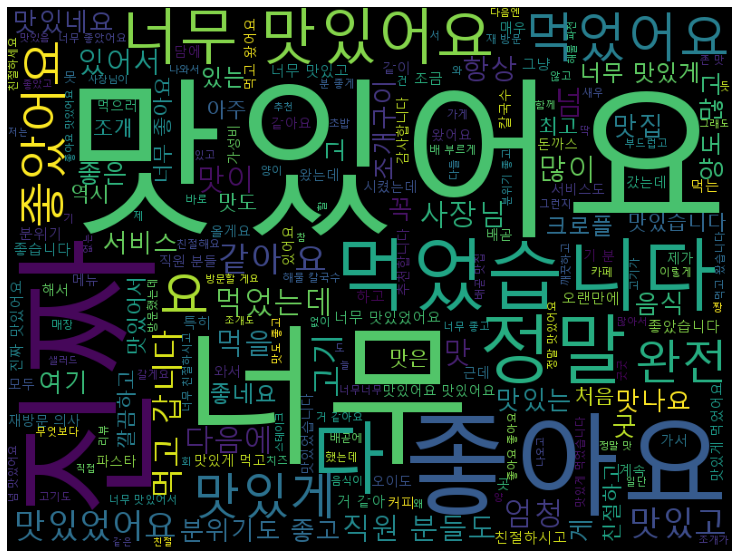

In [ ]:
from wordcloud import WordCloud 
%matplotlib inline
# 불용어를 적용한 리뷰 데이터 특성 파악
f_path = "C:\Windows\Fonts\malgun.ttf"
font_manager.FontProperties(fname=f_path).get_name()
rc('font', family='Malgun Gothic')


wordcloud = WordCloud(font_path=f_path, stopwords=stopwords_list, background_color='black', width=800, height=600).generate(' '.join(train['visitor review']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 5-(5) 기본 파라미터 모델 비교

### 5-(5)-1 비판리뷰, 악성리뷰 데이터 늘리기

In [ ]:
#데이터 불러오기
data = pd.read_csv('processed_place_visitor_review4_1.csv', index_col=[0])

In [ ]:
data.tail(5)

num name blog or review  \
194  NaN   식당          방문자리뷰   
195  NaN   식당          방문자리뷰   
196  NaN   식당          방문자리뷰   
197  NaN   식당          방문자리뷰   
198  NaN   식당          방문자리뷰   

                                        visitor review  label  
194   서비스도 최악에 맛도 없고 갈 필요가 없습니다  일하든 사람들 수준이 정말 별로인 곳       2  
195    맛과 품질이 형편 없어졌네요  직원들의 표정이 음식 맛을 저하시키고 정말 최악입니다       2  
196  정성 하나없고 정말 성의없게 대충 장사하는 집이고 장담하고 이대로 가다 얼마 못가 ...      2  
197             진짜 구라 안치고 퀄리티 대비 가격 개바가지수준임 걍 호구당한 느낌       2  
198                     창렬 긴말 안하고 콜라 355ml가 2 500원입니다       2

In [ ]:
is_ab = data['label'] == 1 # label =1
is_hate = data['label'] ==2 # label =2
ab = data[is_ab]
hate = data[is_hate]

In [ ]:
#데이터 늘리기
adds = pd.concat([ab, hate])
data1=pd.concat([data,adds])

In [ ]:
data1.groupby(['label']).size() # 라벨링별 데이터 수 확인

label
0    13137
1     1272
2      636
dtype: int64

### 5-(5)-2 train, test 분할

In [ ]:
X = data1['visitor review']
y = data1['label']

In [ ]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=2019,
                                                    stratify = y)

### 5-(5)-3 형태소 분석

In [ ]:
okt=Okt()

def okt_tokenizer(text):
    tokens_ko = okt.morphs(text)
    return tokens_ko

### 5-(5)-4 Decision tree

In [ ]:
dtc = DecisionTreeClassifier()

model =dtc

# Pipeline 설정
#머신 러닝 프로세스에서 파라미터를 조정하거나 스케일링 및 정규화와 같은 데이터 변환을 수행
#이때 모델 학습과 테스트를 할때 최소 2번 이상 적용해야 하는데 이러한 과정을 단순화하는 도구
이러한 과정을 단순화 하는 도구
vec_pipe = Pipeline([
                    ("vec", TfidfVectorizer(tokenizer=okt_tokenizer)), #Tfidf와 해당하는 모델 비교
                    ("model", model)
                    ])
    
# 하이퍼파라미터 설정
# tfidf 하이퍼파라미터 설정
vec_pipe_params = {"vec__ngram_range" : [(1,2)], # 단어 묶음 수
                    "vec__stop_words"  : [None], # 한국어 해당 안됨
                    "vec__min_df" : [3], # 학습에 포함하기 위한 최소 빈도 값
                    "vec__max_df" : [0.9]} # 학습에 포함되기 위한 최대 빈도값
    
    
# grid search
vec_gs = GridSearchCV(vec_pipe,
                        param_grid=vec_pipe_params,
                        cv=3)

# model fitting
vec_gs.fit(X_train, y_train);
    
# 예측
y_pred = vec_gs.best_estimator_.predict(X_test)
    


In [ ]:
#best_params_ : 최고 점수를 낸 파라미터
#best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형

print('Best parameters (Grid Search): \n',vec_gs.best_params_)
print(vec_gs.best_estimator_)

Best parameters (Grid Search): 
 {'vec__max_df': 0.9, 'vec__min_df': 3, 'vec__ngram_range': (1, 2), 'vec__stop_words': None}
Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 tokenizer=<function okt_tokenizer at 0x000001D82F9C8160>)),
                ('model', DecisionTreeClassifier())])


### Decision Tree 분류 성능 측정(Accuracy, Precision, Recall, F1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
    
# 성능 지표
print("Model : ", model)
acc = accuracy_score(y_test, y_pred)
print('[Accuracy]: {:.2f}%'.format(acc * 100))
pre = precision_score(y_test, y_pred, average='macro')
print('[Precision]: {:.5f}%'.format(pre * 100))
rec = recall_score(y_test, y_pred, average='macro')
print('[Recall]: {:.5f}%'.format(rec * 100))
f1 = f1_score(y_test, y_pred, average='macro')
print('[F1_score]: {:.5f}%'.format(f1 * 100))


[[2529   74   24]
 [  27  220    8]
 [  13    8  106]]
Model :  DecisionTreeClassifier()
[Accuracy]: 94.88%
[Precision]: 82.70075%
[Recall]: 88.66953%
[F1_score]: 85.44624%


### ROC 분석을 통한 AUC 수치 확인

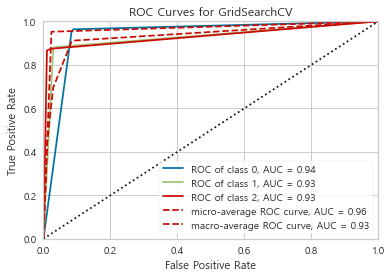

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer_vec_gs = ROCAUC(vec_gs, clases=["1","2"])

visualizer_vec_gs.fit(X_train, y_train)   
visualizer_vec_gs.score(X_test, y_test)      
visualizer_vec_gs.show() 

### 5-(5)-5 XGBoost

In [ ]:
xgb= XGBClassifier()

model = xgb

# Pipeline 설정
vec_pipe = Pipeline([
                    ("vec", TfidfVectorizer(tokenizer=okt_tokenizer)), 
                    ("model", model)
                    ])
    
# 하이퍼파라미터 설정
vec_pipe_params = {"vec__ngram_range" : [(1,2)], 
                    "vec__stop_words"  : [None],
                    "vec__min_df" : [3],
                    "vec__max_df" : [0.9]}
    
    
# grid search
vec_gs2 = GridSearchCV(vec_pipe,
                        param_grid=vec_pipe_params,
                        cv=3)

# model fittingb
vec_gs2.fit(X_train, y_train);
    
# 예측
y_pred = vec_gs2.best_estimator_.predict(X_test)
    


C:\Users\user\.conda\envs\text2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\text2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\text2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:42:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\text2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#best_params_ : 최고 점수를 낸 파라미터
#best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형

print('Best parameters (Grid Search): \n',vec_gs2.best_params_)
print(vec_gs2.best_estimator_)

Best parameters (Grid Search): 
 {'vec__max_df': 0.9, 'vec__min_df': 3, 'vec__ngram_range': (1, 2), 'vec__stop_words': None}
Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 tokenizer=<function okt_tokenizer at 0x000001D82F9C8160>)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1,
                   

### XGBoost 분류 성능 측정(Accuracy, Precision, Recall, F1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
    
# 성능 지표
print("Model : ", model)
acc = accuracy_score(y_test, y_pred)
print('[Accuracy]: {:.2f}%'.format(acc * 100))
pre = precision_score(y_test, y_pred, average='macro')
print('[Precision]: {:.5f}%'.format(pre * 100))
rec = recall_score(y_test, y_pred, average='macro')
print('[Recall]: {:.5f}%'.format(rec * 100))
f1 = f1_score(y_test, y_pred, average='macro')
print('[F1_score]: {:.5f}%'.format(f1 * 100))


[[2606   17    4]
 [  69  181    5]
 [  36    7   84]]
Model :  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)
[Accuracy]: 95.41%
[Precision]: 91.58072%
[Recall]: 78.77424%
[F1_score]: 84.23295%


### ROC 분석을 통한 AUC 수치 확인

C:\Users\user\.conda\envs\text2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\text2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\text2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\text2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


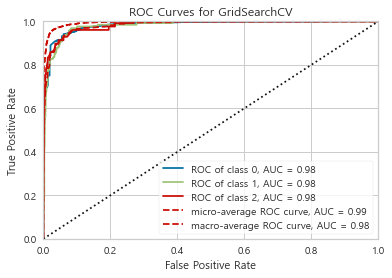

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer_vec_gs2 = ROCAUC(vec_gs2, clases=["1","2"]) 

visualizer_vec_gs2.fit(X_train, y_train)   
visualizer_vec_gs2.score(X_test, y_test)      
visualizer_vec_gs2.show() 

### 5-(5)-6 LGBM Classifier

In [ ]:
lgbm = LGBMClassifier()

model =lgbm

# Pipeline 설정
vec_pipe = Pipeline([
                    ("vec", TfidfVectorizer(tokenizer=okt_tokenizer)), 
                    ("model", model)
                    ])
    
# 하이퍼파라미터 설정
vec_pipe_params = {"vec__ngram_range" : [(1,2)], 
                    "vec__stop_words"  : [None],
                    "vec__min_df" : [3],
                    "vec__max_df" : [0.9]}
    
    
# grid search
vec_gs3 = GridSearchCV(vec_pipe,
                        param_grid=vec_pipe_params,
                        cv=3)

# model fitting
vec_gs3.fit(X_train, y_train);
    
# 예측
y_pred = vec_gs3.best_estimator_.predict(X_test)
    

In [ ]:
#best_params_ : 최고 점수를 낸 파라미터
#best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형

print('Best parameters (Grid Search): \n',vec_gs3.best_params_)
print(vec_gs3.best_estimator_)

Best parameters (Grid Search): 
 {'vec__max_df': 0.9, 'vec__min_df': 3, 'vec__ngram_range': (1, 2), 'vec__stop_words': None}
Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 tokenizer=<function okt_tokenizer at 0x000001D82F9C8160>)),
                ('model', LGBMClassifier())])


### LGBM Classifier 분류 성능 측정(Accuracy, Precision, Recall, F1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
    
# 성능 지표
print("Model : ", model)
acc = accuracy_score(y_test, y_pred)
print('[Accuracy]: {:.2f}%'.format(acc * 100))
pre = precision_score(y_test, y_pred, average='macro')
print('[Precision]: {:.5f}%'.format(pre * 100))
rec = recall_score(y_test, y_pred, average='macro')
print('[Recall]: {:.5f}%'.format(rec * 100))
f1 = f1_score(y_test, y_pred, average='macro')
print('[F1_score]: {:.5f}%'.format(f1 * 100))

[[2595   22   10]
 [  51  200    4]
 [  13    9  105]]
Model :  LGBMClassifier()
[Accuracy]: 96.38%
[Precision]: 90.80282%
[Recall]: 86.63014%
[F1_score]: 88.61809%


### ROC 분석을 통한 AUC 수치 확인

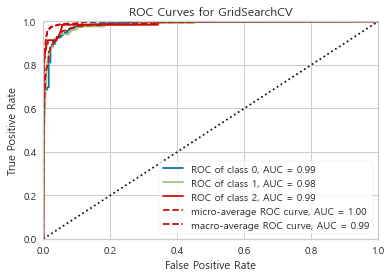

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer_vec_gs3 = ROCAUC(vec_gs3, clases=["1","2"])

visualizer_vec_gs3.fit(X_train, y_train)   
visualizer_vec_gs3.score(X_test, y_test)      
visualizer_vec_gs3.show() 

## 5-(6) LGBM을 이용한 악성리뷰 제거

In [ ]:
#학습한 모델을 X에 적용한 결과
new_y = vec_gs3.best_estimator_.predict(X)

In [ ]:
#데이터 프레임 변환
new_label = pd.DataFrame(new_y,columns=['new_label'])

In [ ]:
# 열 추가
data1.insert(5,"new_label",new_label)

In [ ]:
# 열 추가 확인
data1

num         name blog or review  \
0    1.0  배곧 또잇카페 배곧점         방문자 리뷰   
1    2.0  배곧 또잇카페 배곧점         방문자 리뷰   
2    3.0  배곧 또잇카페 배곧점         방문자 리뷰   
3    4.0  배곧 또잇카페 배곧점         방문자 리뷰   
4    5.0  배곧 또잇카페 배곧점         방문자 리뷰   
..   ...          ...            ...   
194  NaN           식당          방문자리뷰   
195  NaN           식당          방문자리뷰   
196  NaN           식당          방문자리뷰   
197  NaN           식당          방문자리뷰   
198  NaN           식당          방문자리뷰   

                                        visitor review  label  new_label  
0                                                   굿       0          0  
1                                                 좋아요       0          0  
2                                                 조아요       0          0  
3                                                   굿       0          0  
4    바다공원 앞에 위치해서 편하고 좋아요  공원에서 운동하고 아메리카노 급 땡겨서 또잇...      0          0  
..                                                 ...    ...        ...  
194   서비스도 최악에 맛도 없고 갈 필요가 없습니다  일하든 사람들 수준이 정말 별로인 곳       2          2  
195    맛과 품질이 형편 없어졌네요  직원들의 표정이 음식 맛을 저하시키고 정말 최악입니다       2          2  
196  정성 하나없고 정말 성의없게 대충 장사하는 집이고 장담하고 이대로 가다 얼마 못가 ...      2          2  
197             진짜 구라 안치고 퀄리티 대비 가격 개바가지수준임 걍 호구당한 느낌       2          2  
198                     창렬 긴말 안하고 콜라 355ml가 2 500원입니다       2          2  

[15045 rows x 6 columns]

In [ ]:
# 기존에 늘린 리뷰 데이터 삭제
data2 =data1[:13892]

In [ ]:
data3 = data2.copy()

In [ ]:
data3

num         name blog or review  \
0       1.0  배곧 또잇카페 배곧점         방문자 리뷰   
1       2.0  배곧 또잇카페 배곧점         방문자 리뷰   
2       3.0  배곧 또잇카페 배곧점         방문자 리뷰   
3       4.0  배곧 또잇카페 배곧점         방문자 리뷰   
4       5.0  배곧 또잇카페 배곧점         방문자 리뷰   
...     ...          ...            ...   
13887  14.0    배곧 카페바이마스         방문자 리뷰   
13888  15.0    배곧 카페바이마스         방문자 리뷰   
13889  16.0    배곧 카페바이마스         방문자 리뷰   
13890  17.0    배곧 카페바이마스         방문자 리뷰   
13891  18.0    배곧 카페바이마스         방문자 리뷰   

                                          visitor review  label  new_label  
0                                                     굿       0          0  
1                                                   좋아요       0          0  
2                                                   조아요       0          0  
3                                                     굿       0          0  
4      바다공원 앞에 위치해서 편하고 좋아요  공원에서 운동하고 아메리카노 급 땡겨서 또잇...      0          0  
...                                                  ...    ...        ...  
13887                                      밀크티는 정말 진리네요       0          0  
13888                원두 선택할 수 있어서 좋아요  디카페인이 있는 것도 별 5개       0          0  
13889                            음료 다 맛있어요  배곧 커피 맛집이에요       0          0  
13890                                           커피 맛있어요       0          0  
13891          원두 선택할 수 있어서 좋아요  디카페인도 먹을 수 있다고 하더라고요 굿       0          0  

[13892 rows x 6 columns]

In [ ]:
# 삭제할 데이터 인덱스 추출
remove_index = data3[data3['new_label'] == 2].index

In [ ]:
# 제거할 리뷰1
h_review=data3[data3['new_label'] == 2]

In [ ]:
h_review

num           name blog or review  \
518     59.0  배곧 투파인드피터 배곧점         방문자 리뷰   
549     90.0  배곧 투파인드피터 배곧점         방문자 리뷰   
652    194.0  배곧 투파인드피터 배곧점         방문자 리뷰   
670    213.0  배곧 투파인드피터 배곧점         방문자 리뷰   
726    269.0  배곧 투파인드피터 배곧점         방문자 리뷰   
...      ...            ...            ...   
13460  170.0   배곧 스시노칸도 배곧점         방문자 리뷰   
13524   11.0        배곧 오영김밥         방문자 리뷰   
13617   14.0   배곧 훈이네솥뚜껑삼겹살         방문자 리뷰   
13727  124.0   배곧 훈이네솥뚜껑삼겹살         방문자 리뷰   
13883   10.0      배곧 카페바이마스         방문자 리뷰   

                                          visitor review  label  new_label  
518    전복 크림 파스타는 같이 주신 소스 찍어 먹었는데 참 맛있었고 봉골 레도 짠 듯 했...      2          2  
549    필라프 추가 주문했더니 밥이 없어서 안 된다고 하여 목살르테이크로 변경해달라고 함 ...      2          2  
652    서빙 직원 음식을 반쯤 먹었을 때쯤 소스를 가져다 주더니 죄송하단 말 한마디 없이 ...      2          2  
670    평점이 좋아서 한 1년 전에 방문 했었는데 직원 응대 태도 때문이 정 떨어져서 안 ...      2          2  
726    리뷰 잘 안 쓰는데 굳이 영수증까지 받아와서 작성합니다  스테이크 질 기고 나이프도...      2          2  
...                                                  ...    ...        ...  
13460  음식 맛은 좋아요  서비스랑 위생은 글쎄요 직원 한 분이 손 다치신 거 같던데 우왕...      2          2  
13524                                    아비뉴 프랑가면 들리는 곳       0          2  
13617                                             별로였어요       2          2  
13727    사장님도 친절하다고 하고 맛있다고 소문 났길래 가보니까 다 거품이네요  언 빌리버블       2          2  
13883                      밀크티 핵맛 탱 하루에 한 잔은 먹어야 함  무족권       0          2  

[126 rows x 6 columns]

In [ ]:
# 해당하는 인덱스 행 삭제
data3.drop(remove_index, inplace =True)

In [ ]:
data3

num         name blog or review  \
0       1.0  배곧 또잇카페 배곧점         방문자 리뷰   
1       2.0  배곧 또잇카페 배곧점         방문자 리뷰   
2       3.0  배곧 또잇카페 배곧점         방문자 리뷰   
3       4.0  배곧 또잇카페 배곧점         방문자 리뷰   
4       5.0  배곧 또잇카페 배곧점         방문자 리뷰   
...     ...          ...            ...   
13887  14.0    배곧 카페바이마스         방문자 리뷰   
13888  15.0    배곧 카페바이마스         방문자 리뷰   
13889  16.0    배곧 카페바이마스         방문자 리뷰   
13890  17.0    배곧 카페바이마스         방문자 리뷰   
13891  18.0    배곧 카페바이마스         방문자 리뷰   

                                          visitor review  label  new_label  
0                                                     굿       0          0  
1                                                   좋아요       0          0  
2                                                   조아요       0          0  
3                                                     굿       0          0  
4      바다공원 앞에 위치해서 편하고 좋아요  공원에서 운동하고 아메리카노 급 땡겨서 또잇...      0          0  
...                                                  ...    ...        ...  
13887                                      밀크티는 정말 진리네요       0          0  
13888                원두 선택할 수 있어서 좋아요  디카페인이 있는 것도 별 5개       0          0  
13889                            음료 다 맛있어요  배곧 커피 맛집이에요       0          0  
13890                                           커피 맛있어요       0          0  
13891          원두 선택할 수 있어서 좋아요  디카페인도 먹을 수 있다고 하더라고요 굿       0          0  

[13766 rows x 6 columns]

In [ ]:
#인덱스 제거 확인
data3.groupby(['new_label']).size() # 라벨링별 데이터 수 확인

new_label
0    13143
1      623
dtype: int64

In [ ]:
data3.groupby(['label']).size() # 라벨링별 데이터 수 확인

label
0    13126
1      634
2        6
dtype: int64

In [ ]:
# 기존 라벨링에서 확인할 데이터 인덱스 추출
check_index = data3[data3['label'] == 2].index

In [ ]:
# 악성리뷰로 라벨링한 데이터 (제거할 리뷰2)
check=data3[data3['label'] == 2]

In [ ]:
check

num          name blog or review  \
9507    17.0       배곧 조개반장         방문자 리뷰   
9755   265.0       배곧 조개반장         방문자 리뷰   
9790   300.0       배곧 조개반장         방문자 리뷰   
9899   409.0       배곧 조개반장         방문자 리뷰   
11829  122.0  배곧 행복한다이닝 배곧         방문자 리뷰   
12322    3.0    배곧 신복관 배곧점         방문자 리뷰   

                                          visitor review  label  new_label  
9507                                               비위생적       2          0  
9755                           지저분해요  맛은 둘째 치고 청소 좀 하세요       2          1  
9790   1 코로나 코드 없음  2 주문 후 2030분 뒤 메뉴 등 장 3 리필 벨 4번 눌...      2          1  
9899   평이 좋은 곳은 사람이 많어 여기를 예약 그러나 셋팅도 제대로 안 되고 겨우 한참 ...      2          1  
11829  너무 별로 였어요  저희가 간 게 대략 8 20분 쯤에 좀 늦게 갔어요  그리고 마...      2          1  
12322                                                별루       2          0

In [ ]:
# 해당하는 인덱스 행 삭제
data3.drop(check_index, inplace =True)

In [ ]:
# 추가한 new_label 열도 제거
data3=data3.drop(['new_label'], axis=1)

In [ ]:
#인덱스 제거 확인
data3.groupby(['label']).size() # 라벨링별 데이터 수 확인

label
0    13126
1      634
dtype: int64

In [ ]:
#악성리뷰 제거 결과
data3

num         name blog or review  \
0       1.0  배곧 또잇카페 배곧점         방문자 리뷰   
1       2.0  배곧 또잇카페 배곧점         방문자 리뷰   
2       3.0  배곧 또잇카페 배곧점         방문자 리뷰   
3       4.0  배곧 또잇카페 배곧점         방문자 리뷰   
4       5.0  배곧 또잇카페 배곧점         방문자 리뷰   
...     ...          ...            ...   
13887  14.0    배곧 카페바이마스         방문자 리뷰   
13888  15.0    배곧 카페바이마스         방문자 리뷰   
13889  16.0    배곧 카페바이마스         방문자 리뷰   
13890  17.0    배곧 카페바이마스         방문자 리뷰   
13891  18.0    배곧 카페바이마스         방문자 리뷰   

                                          visitor review  label  
0                                                     굿       0  
1                                                   좋아요       0  
2                                                   조아요       0  
3                                                     굿       0  
4      바다공원 앞에 위치해서 편하고 좋아요  공원에서 운동하고 아메리카노 급 땡겨서 또잇...      0  
...                                                  ...    ...  
13887                                      밀크티는 정말 진리네요       0  
13888                원두 선택할 수 있어서 좋아요  디카페인이 있는 것도 별 5개       0  
13889                            음료 다 맛있어요  배곧 커피 맛집이에요       0  
13890                                           커피 맛있어요       0  
13891          원두 선택할 수 있어서 좋아요  디카페인도 먹을 수 있다고 하더라고요 굿       0  

[13760 rows x 5 columns]

In [ ]:
# 제거할 리뷰 합치기
final_hate_review = pd.concat([h_review,check])

In [ ]:
final_hate_review

num           name blog or review  \
518     59.0  배곧 투파인드피터 배곧점         방문자 리뷰   
549     90.0  배곧 투파인드피터 배곧점         방문자 리뷰   
652    194.0  배곧 투파인드피터 배곧점         방문자 리뷰   
670    213.0  배곧 투파인드피터 배곧점         방문자 리뷰   
726    269.0  배곧 투파인드피터 배곧점         방문자 리뷰   
...      ...            ...            ...   
9755   265.0        배곧 조개반장         방문자 리뷰   
9790   300.0        배곧 조개반장         방문자 리뷰   
9899   409.0        배곧 조개반장         방문자 리뷰   
11829  122.0   배곧 행복한다이닝 배곧         방문자 리뷰   
12322    3.0     배곧 신복관 배곧점         방문자 리뷰   

                                          visitor review  label  new_label  
518    전복 크림 파스타는 같이 주신 소스 찍어 먹었는데 참 맛있었고 봉골 레도 짠 듯 했...      2          2  
549    필라프 추가 주문했더니 밥이 없어서 안 된다고 하여 목살르테이크로 변경해달라고 함 ...      2          2  
652    서빙 직원 음식을 반쯤 먹었을 때쯤 소스를 가져다 주더니 죄송하단 말 한마디 없이 ...      2          2  
670    평점이 좋아서 한 1년 전에 방문 했었는데 직원 응대 태도 때문이 정 떨어져서 안 ...      2          2  
726    리뷰 잘 안 쓰는데 굳이 영수증까지 받아와서 작성합니다  스테이크 질 기고 나이프도...      2          2  
...                                                  ...    ...        ...  
9755                           지저분해요  맛은 둘째 치고 청소 좀 하세요       2          1  
9790   1 코로나 코드 없음  2 주문 후 2030분 뒤 메뉴 등 장 3 리필 벨 4번 눌...      2          1  
9899   평이 좋은 곳은 사람이 많어 여기를 예약 그러나 셋팅도 제대로 안 되고 겨우 한참 ...      2          1  
11829  너무 별로 였어요  저희가 간 게 대략 8 20분 쯤에 좀 늦게 갔어요  그리고 마...      2          1  
12322                                                별루       2          0  

[132 rows x 6 columns]

In [ ]:
# 필터링 된 악성 리뷰 저장
final_hate_review.to_csv('processed_hate_review.csv', encoding="utf-8-sig")

In [ ]:
data4= data3.copy()

In [ ]:
# 악성 리뷰 제거한 리뷰
data4=data4.drop(['label'], axis=1)

In [ ]:
data4.to_csv('processed_place_visitor_review4.csv', encoding="utf-8-sig")